In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=4)
mpl.rc('xtick', labelsize=4)
mpl.rc('ytick', labelsize=4)
mpl.rc('font',size=2)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  0.24.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import random




class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME", activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}


def csv_reader_dataset(filepaths, repeat=1, n_readers=1,
                       n_read_threads=None, shuffle_buffer_size=0,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths,shuffle=False).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    #dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[1:])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[:1])
    augment_image = x
    if y > 10:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet.preprocess_input(resized_image)
    
    return final_image, y

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*1.4-0.7
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/4 ~ pi/4
    shift=(random.random()%1)*8-4
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [3]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("./common_file", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [4]:
y_valid=np.loadtxt('./common_file/valid_label.csv', delimiter=",",dtype='uint8')
X_valid=np.loadtxt('./common_file/valid_data.csv', delimiter=",",dtype='uint8')

In [5]:
X_valid=np.reshape(X_valid,[-1,784])
y_valid=np.reshape(y_valid,[-1,1])

y_valid.shape,X_valid.shape

((164015, 1), (164015, 784))

In [6]:
valid_full=np.append(y_valid, X_valid, axis=1)
valid_full.shape

(164015, 785)

In [7]:
batch_size = 5
n_inputs = X_valid.shape[-1]

In [8]:
valid_filepaths=save_to_multiple_csv_files(valid_full,"valid",n_parts=20)

valid_set=csv_reader_dataset(valid_filepaths,batch_size=batch_size, repeat=None)

In [9]:
valid_filepaths

['./common_file\\Emnist\\my_valid_00.csv',
 './common_file\\Emnist\\my_valid_01.csv',
 './common_file\\Emnist\\my_valid_02.csv',
 './common_file\\Emnist\\my_valid_03.csv',
 './common_file\\Emnist\\my_valid_04.csv',
 './common_file\\Emnist\\my_valid_05.csv',
 './common_file\\Emnist\\my_valid_06.csv',
 './common_file\\Emnist\\my_valid_07.csv',
 './common_file\\Emnist\\my_valid_08.csv',
 './common_file\\Emnist\\my_valid_09.csv',
 './common_file\\Emnist\\my_valid_10.csv',
 './common_file\\Emnist\\my_valid_11.csv',
 './common_file\\Emnist\\my_valid_12.csv',
 './common_file\\Emnist\\my_valid_13.csv',
 './common_file\\Emnist\\my_valid_14.csv',
 './common_file\\Emnist\\my_valid_15.csv',
 './common_file\\Emnist\\my_valid_16.csv',
 './common_file\\Emnist\\my_valid_17.csv',
 './common_file\\Emnist\\my_valid_18.csv',
 './common_file\\Emnist\\my_valid_19.csv']

In [10]:
valid_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [11]:
model1=keras.models.load_model('./smv2p_nadam_best.h5',custom_objects={'Inveted_Residual_Block':Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [42]:
#1307 x 89 = 116323
y_pred=model1.predict(valid_set, batch_size=5 ,steps=32803)


In [13]:
#y=valid_set.TensorSpec

In [43]:
y_pred.shape

(164015, 62)

In [44]:
y_pred_classes=np.argmax(y_pred,axis=1)
y_pred_classes

array([ 2,  7,  0, ...,  4, 47, 55], dtype=int64)

In [68]:
y_true=[[0]]

In [69]:
i=0
for x,y in valid_set:
    y_true=tf.concat([y_true,y],0)
    print(y_true)
    i+=1
    print(i)
    if i==32803:
        break

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]], shape=(6, 1), dtype=float32)
1
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]], shape=(11, 1), dtype=float32)
2
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]], shape=(16, 1), dtype=float32)
3
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]], shape=(21, 1), dtype=float32)
4
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]], shape=(26, 1), dtype=float32)
5
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 [ 0.]
 [36.]
 [ 8.]
 [ 8.]
 [ 5.]
 [49.]
 [ 3.]
 [ 2.]
 [ 1.]
 [57.]
 [15.]
 [24.]
 [43.]
 [ 7.]
 [ 8.]
 [10.]
 [ 1.]
 [33.]
 [40.]
 [49.]
 [ 3.]
 [33.]
 [ 7.]
 [11.]
 [ 1.]
 [ 8.]
 [15.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 9.]
 [ 3.]
 [40.]
 [28.]
 [ 2.]
 [ 4.]
 [39.]
 [ 1.]
 [ 1.]
 [ 9.]
 [29.]
 [ 3.]
 [29.]
 [24.]
 [39.]
 [ 6.]
 [13.]
 [30.]
 [15.]
 [53.]
 [39.]
 [ 6.]
 [11.]
 [40.]
 [ 8.]
 [ 8.]
 [ 0.]
 [47.]
 [28.]
 [ 9.]
 [36.]
 [ 7.]
 [ 7.]
 [47.]
 [58.]
 [ 9.]
 [18.]
 [21.]
 [ 7.]
 [ 1.]
 [47.]
 [40.]
 [22.]
 [42.]
 [ 1.]
 [ 1.]
 [ 8.]
 [ 0.]
 [ 7.]
 [18.]
 [ 2.]
 [ 7.]
 [ 5.]
 [39.]
 [15.]
 [57.]
 [40.]
 [ 6.]
 [27.]
 [ 0.]
 [53.]
 [24.]
 [28.]
 [ 5.]
 [ 7.]
 [ 3.]
 [ 6.]
 [25.]
 [ 6.]
 [47.]
 [23.]
 [ 1.]
 [ 7.]
 [ 3.]
 [ 1.]
 [23.]
 [ 2.]
 [ 5.]
 [10.]
 [ 6.]
 [51.]
 [18.]
 [ 8.]
 [55.]
 [ 6.]
 [ 1.]
 [ 4.]
 [14.]
 [22.]
 [ 2.]
 [18.]
 [34.]
 [ 8.]
 [ 3.]
 [28.]
 [47.]
 [28.]
 [30.]
 [ 2.]
 [24.]
 [59.]
 [ 2.]
 [ 6.]
 [44.]
 [40.]
 [ 6.]
 [47.]
 [29.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [53.]
 [30.]], shape=(1096, 1), dtype=float32)
219
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 7.]
 [ 5.]], shape=(1101, 1), dtype=float32)
220
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [34.]
 [ 5.]], shape=(1106, 1), dtype=float32)
221
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [39.]], shape=(1111, 1), dtype=float32)
222
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [37.]
 [40.]], shape=(1116, 1), dtype=float32)
223
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [ 5.]], shape=(1121, 1), dtype=float32)
224
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [47.]
 [ 2.]], shape=(1126, 1), dtype=float32)
225
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [ 1.]], shape=(1131, 1), dtype=float32)
226
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [11.]
 [ 9.]], shape=(1136, 1), dtype=float32)
227
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [15.]
 [12.]], shape=(1141, 1), dtype=float32)
228
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [2

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [55.]
 [39.]], shape=(1741, 1), dtype=float32)
348
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [55.]
 [ 0.]], shape=(1746, 1), dtype=float32)
349
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [61.]
 [ 3.]], shape=(1751, 1), dtype=float32)
350
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 9.]
 [13.]], shape=(1756, 1), dtype=float32)
351
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 4.]
 [36.]], shape=(1761, 1), dtype=float32)
352
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [13.]
 [ 8.]], shape=(1766, 1), dtype=float32)
353
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [30.]], shape=(1771, 1), dtype=float32)
354
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [25.]
 [ 6.]], shape=(1776, 1), dtype=float32)
355
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [17.]
 [ 5.]], shape=(1781, 1), dtype=float32)
356
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [14.]
 [22.]], shape=(1786, 1), dtype=float32)
357
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [32.]
 [24.]], shape=(2396, 1), dtype=float32)
479
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 7.]
 [ 8.]], shape=(2401, 1), dtype=float32)
480
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 0.]
 [39.]], shape=(2406, 1), dtype=float32)
481
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 9.]
 [53.]], shape=(2411, 1), dtype=float32)
482
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [53.]
 [55.]], shape=(2416, 1), dtype=float32)
483
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [55.]
 [ 3.]], shape=(2421, 1), dtype=float32)
484
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [30.]], shape=(2426, 1), dtype=float32)
485
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [40.]
 [46.]], shape=(2431, 1), dtype=float32)
486
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 0.]
 [ 9.]], shape=(2436, 1), dtype=float32)
487
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [40.]
 [ 7.]], shape=(2441, 1), dtype=float32)
488
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [21.]
 [ 4.]], shape=(3091, 1), dtype=float32)
618
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [ 3.]], shape=(3096, 1), dtype=float32)
619
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [18.]
 [ 4.]], shape=(3101, 1), dtype=float32)
620
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [25.]
 [55.]], shape=(3106, 1), dtype=float32)
621
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [22.]
 [37.]], shape=(3111, 1), dtype=float32)
622
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 0.]
 [ 8.]], shape=(3116, 1), dtype=float32)
623
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [47.]
 [49.]], shape=(3121, 1), dtype=float32)
624
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [40.]], shape=(3126, 1), dtype=float32)
625
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [32.]], shape=(3131, 1), dtype=float32)
626
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [55.]
 [49.]], shape=(3136, 1), dtype=float32)
627
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [18.]
 [36.]], shape=(3721, 1), dtype=float32)
744
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [43.]
 [ 6.]], shape=(3726, 1), dtype=float32)
745
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [37.]
 [ 5.]], shape=(3731, 1), dtype=float32)
746
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [53.]
 [14.]], shape=(3736, 1), dtype=float32)
747
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [12.]
 [ 2.]], shape=(3741, 1), dtype=float32)
748
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [29.]
 [55.]], shape=(3746, 1), dtype=float32)
749
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 4.]
 [ 7.]], shape=(3751, 1), dtype=float32)
750
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [42.]
 [ 9.]], shape=(3756, 1), dtype=float32)
751
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [25.]
 [ 1.]], shape=(3761, 1), dtype=float32)
752
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [47.]
 [ 1.]], shape=(3766, 1), dtype=float32)
753
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [3

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 3.]
 [ 0.]], shape=(4341, 1), dtype=float32)
868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [28.]
 [ 2.]], shape=(4346, 1), dtype=float32)
869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [55.]
 [ 5.]], shape=(4351, 1), dtype=float32)
870
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 6.]
 [53.]], shape=(4356, 1), dtype=float32)
871
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [36.]], shape=(4361, 1), dtype=float32)
872
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [25.]
 [45.]], shape=(4366, 1), dtype=float32)
873
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [11.]
 [31.]], shape=(4371, 1), dtype=float32)
874
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [54.]
 [ 4.]], shape=(4376, 1), dtype=float32)
875
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 5.]
 [30.]], shape=(4381, 1), dtype=float32)
876
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [47.]
 [24.]], shape=(4386, 1), dtype=float32)
877
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [36.]], shape=(4971, 1), dtype=float32)
994
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 0.]
 [ 0.]], shape=(4976, 1), dtype=float32)
995
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 1.]
 [55.]], shape=(4981, 1), dtype=float32)
996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [17.]
 [ 0.]], shape=(4986, 1), dtype=float32)
997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 3.]
 [ 5.]], shape=(4991, 1), dtype=float32)
998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [15.]
 [ 1.]], shape=(4996, 1), dtype=float32)
999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [24.]
 [ 9.]], shape=(5001, 1), dtype=float32)
1000
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [48.]
 [30.]
 [ 7.]], shape=(5006, 1), dtype=float32)
1001
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [30.]
 [ 9.]], shape=(5011, 1), dtype=float32)
1002
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [47.]], shape=(5016, 1), dtype=float32)
1003
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [25.]
 [16.]], shape=(5566, 1), dtype=float32)
1113
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 4.]
 [ 9.]], shape=(5571, 1), dtype=float32)
1114
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 0.]
 [ 0.]], shape=(5576, 1), dtype=float32)
1115
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [10.]
 [ 5.]], shape=(5581, 1), dtype=float32)
1116
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 2.]
 [40.]], shape=(5586, 1), dtype=float32)
1117
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [30.]], shape=(5591, 1), dtype=float32)
1118
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 4.]
 [ 1.]], shape=(5596, 1), dtype=float32)
1119
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [15.]
 [19.]], shape=(5601, 1), dtype=float32)
1120
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [14.]
 [ 2.]], shape=(5606, 1), dtype=float32)
1121
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 4.]
 [12.]], shape=(5611, 1), dtype=float32)
1122
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 1.]
 [ 7.]], shape=(6211, 1), dtype=float32)
1242
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 1.]
 [ 6.]], shape=(6216, 1), dtype=float32)
1243
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 7.]
 [ 2.]], shape=(6221, 1), dtype=float32)
1244
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [30.]
 [22.]], shape=(6226, 1), dtype=float32)
1245
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [30.]
 [41.]], shape=(6231, 1), dtype=float32)
1246
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [23.]
 [25.]], shape=(6236, 1), dtype=float32)
1247
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [36.]
 [ 0.]], shape=(6241, 1), dtype=float32)
1248
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [24.]], shape=(6246, 1), dtype=float32)
1249
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [ 7.]], shape=(6251, 1), dtype=float32)
1250
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [ 2.]], shape=(6256, 1), dtype=float32)
1251
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [14.]
 [ 3.]], shape=(6881, 1), dtype=float32)
1376
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [16.]
 [60.]], shape=(6886, 1), dtype=float32)
1377
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [21.]
 [23.]], shape=(6891, 1), dtype=float32)
1378
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 2.]
 [50.]], shape=(6896, 1), dtype=float32)
1379
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [40.]
 [ 1.]], shape=(6901, 1), dtype=float32)
1380
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [ 6.]
 [ 1.]], shape=(6906, 1), dtype=float32)
1381
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [53.]
 [28.]], shape=(6911, 1), dtype=float32)
1382
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [32.]], shape=(6916, 1), dtype=float32)
1383
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 5.]
 [ 4.]], shape=(6921, 1), dtype=float32)
1384
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [37.]
 [36.]], shape=(6926, 1), dtype=float32)
1385
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

1508
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [55.]
 [ 9.]], shape=(7546, 1), dtype=float32)
1509
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [ 3.]], shape=(7551, 1), dtype=float32)
1510
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [10.]], shape=(7556, 1), dtype=float32)
1511
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [40.]
 [55.]], shape=(7561, 1), dtype=float32)
1512
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 8.]
 [ 2.]], shape=(7566, 1), dtype=float32)
1513
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [43.]
 [40.]], shape=(7571, 1), dtype=float32)
1514
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 8.]
 [ 2.]], shape=(7576, 1), dtype=float32)
1515
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 8.]
 [ 8.]], shape=(7581, 1), dtype=float32)
1516
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [18.]], shape=(7586, 1), dtype=float32)
1517
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [53.]
 [ 1.]], shape=(7591, 1), dtype=float32)
1518
tf.Tensor(
[[ 0.]
 [ 7.]


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [36.]], shape=(8146, 1), dtype=float32)
1629
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [23.]
 [37.]], shape=(8151, 1), dtype=float32)
1630
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [47.]], shape=(8156, 1), dtype=float32)
1631
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [24.]
 [ 6.]], shape=(8161, 1), dtype=float32)
1632
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [40.]
 [28.]], shape=(8166, 1), dtype=float32)
1633
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [38.]
 [ 0.]], shape=(8171, 1), dtype=float32)
1634
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 9.]
 [53.]], shape=(8176, 1), dtype=float32)
1635
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 8.]
 [46.]], shape=(8181, 1), dtype=float32)
1636
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 4.]
 [ 6.]], shape=(8186, 1), dtype=float32)
1637
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [24.]], shape=(8191, 1), dtype=float32)
1638
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [31.]
 [22.]], shape=(8781, 1), dtype=float32)
1756
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 6.]
 [29.]], shape=(8786, 1), dtype=float32)
1757
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [47.]
 [22.]], shape=(8791, 1), dtype=float32)
1758
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 1.]
 [ 1.]], shape=(8796, 1), dtype=float32)
1759
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [24.]
 [43.]], shape=(8801, 1), dtype=float32)
1760
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [ 3.]], shape=(8806, 1), dtype=float32)
1761
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 6.]
 [55.]], shape=(8811, 1), dtype=float32)
1762
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [55.]
 [30.]], shape=(8816, 1), dtype=float32)
1763
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [55.]
 [ 9.]], shape=(8821, 1), dtype=float32)
1764
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 0.]
 [ 6.]], shape=(8826, 1), dtype=float32)
1765
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [ 8.]], shape=(9446, 1), dtype=float32)
1889
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [43.]
 [ 1.]], shape=(9451, 1), dtype=float32)
1890
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 2.]
 [ 7.]], shape=(9456, 1), dtype=float32)
1891
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 1.]
 [30.]], shape=(9461, 1), dtype=float32)
1892
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 1.]
 [40.]], shape=(9466, 1), dtype=float32)
1893
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [34.]
 [ 0.]], shape=(9471, 1), dtype=float32)
1894
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [53.]
 [49.]], shape=(9476, 1), dtype=float32)
1895
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [56.]
 [36.]], shape=(9481, 1), dtype=float32)
1896
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [ 6.]], shape=(9486, 1), dtype=float32)
1897
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 4.]
 [47.]], shape=(9491, 1), dtype=float32)
1898
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [49.]], shape=(10121, 1), dtype=float32)
2024
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [24.]], shape=(10126, 1), dtype=float32)
2025
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [40.]
 [ 3.]], shape=(10131, 1), dtype=float32)
2026
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 1.]], shape=(10136, 1), dtype=float32)
2027
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [37.]
 [ 7.]], shape=(10141, 1), dtype=float32)
2028
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [28.]
 [49.]], shape=(10146, 1), dtype=float32)
2029
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 8.]
 [ 6.]], shape=(10151, 1), dtype=float32)
2030
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 7.]
 [19.]], shape=(10156, 1), dtype=float32)
2031
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 0.]
 [40.]], shape=(10161, 1), dtype=float32)
2032
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 4.]
 [ 0.]], shape=(10166, 1), dtype=float32)
2033
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 2.]
 [25.]], shape=(10736, 1), dtype=float32)
2147
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 8.]
 [ 7.]], shape=(10741, 1), dtype=float32)
2148
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [46.]
 [ 2.]], shape=(10746, 1), dtype=float32)
2149
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 0.]
 [49.]], shape=(10751, 1), dtype=float32)
2150
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [31.]
 [49.]], shape=(10756, 1), dtype=float32)
2151
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [30.]
 [ 3.]], shape=(10761, 1), dtype=float32)
2152
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [21.]
 [24.]], shape=(10766, 1), dtype=float32)
2153
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 2.]
 [54.]], shape=(10771, 1), dtype=float32)
2154
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [32.]
 [24.]], shape=(10776, 1), dtype=float32)
2155
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [34.]
 [ 5.]], shape=(10781, 1), dtype=float32)
2156
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 9.]
 [ 1.]], shape=(11401, 1), dtype=float32)
2280
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [30.]
 [ 5.]], shape=(11406, 1), dtype=float32)
2281
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 5.]
 [ 8.]], shape=(11411, 1), dtype=float32)
2282
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 2.]
 [28.]], shape=(11416, 1), dtype=float32)
2283
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [53.]
 [47.]], shape=(11421, 1), dtype=float32)
2284
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [29.]], shape=(11426, 1), dtype=float32)
2285
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [28.]
 [34.]], shape=(11431, 1), dtype=float32)
2286
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [20.]], shape=(11436, 1), dtype=float32)
2287
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 3.]
 [47.]], shape=(11441, 1), dtype=float32)
2288
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 0.]
 [15.]], shape=(11446, 1), dtype=float32)
2289
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [ 1.]], shape=(12026, 1), dtype=float32)
2405
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [24.]
 [ 3.]], shape=(12031, 1), dtype=float32)
2406
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [47.]
 [27.]], shape=(12036, 1), dtype=float32)
2407
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [22.]], shape=(12041, 1), dtype=float32)
2408
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 2.]
 [ 6.]], shape=(12046, 1), dtype=float32)
2409
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 7.]
 [ 0.]], shape=(12051, 1), dtype=float32)
2410
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 4.]
 [ 5.]], shape=(12056, 1), dtype=float32)
2411
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 7.]
 [ 2.]], shape=(12061, 1), dtype=float32)
2412
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [11.]
 [ 0.]], shape=(12066, 1), dtype=float32)
2413
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [53.]
 [ 0.]], shape=(12071, 1), dtype=float32)
2414
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [ 8.]], shape=(12671, 1), dtype=float32)
2534
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [40.]
 [ 6.]], shape=(12676, 1), dtype=float32)
2535
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 7.]
 [18.]], shape=(12681, 1), dtype=float32)
2536
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 5.]
 [ 0.]], shape=(12686, 1), dtype=float32)
2537
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [23.]], shape=(12691, 1), dtype=float32)
2538
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 1.]
 [ 2.]], shape=(12696, 1), dtype=float32)
2539
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [60.]], shape=(12701, 1), dtype=float32)
2540
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [40.]
 [24.]], shape=(12706, 1), dtype=float32)
2541
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [24.]
 [ 5.]], shape=(12711, 1), dtype=float32)
2542
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 3.]
 [ 2.]], shape=(12716, 1), dtype=float32)
2543
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [61.]
 [36.]], shape=(13331, 1), dtype=float32)
2666
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [10.]
 [52.]], shape=(13336, 1), dtype=float32)
2667
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [42.]], shape=(13341, 1), dtype=float32)
2668
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [56.]
 [47.]], shape=(13346, 1), dtype=float32)
2669
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [40.]], shape=(13351, 1), dtype=float32)
2670
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [40.]
 [20.]], shape=(13356, 1), dtype=float32)
2671
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 1.]
 [ 3.]], shape=(13361, 1), dtype=float32)
2672
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [28.]
 [47.]], shape=(13366, 1), dtype=float32)
2673
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [ 3.]
 [54.]], shape=(13371, 1), dtype=float32)
2674
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [29.]
 [13.]], shape=(13376, 1), dtype=float32)
2675
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [ 4.]], shape=(13971, 1), dtype=float32)
2794
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [49.]], shape=(13976, 1), dtype=float32)
2795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [53.]
 [ 1.]], shape=(13981, 1), dtype=float32)
2796
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 4.]
 [ 2.]], shape=(13986, 1), dtype=float32)
2797
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [22.]
 [ 8.]], shape=(13991, 1), dtype=float32)
2798
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [16.]
 [ 6.]], shape=(13996, 1), dtype=float32)
2799
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [58.]], shape=(14001, 1), dtype=float32)
2800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 8.]], shape=(14006, 1), dtype=float32)
2801
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [59.]
 [15.]], shape=(14011, 1), dtype=float32)
2802
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [40.]
 [ 5.]], shape=(14016, 1), dtype=float32)
2803
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [52.]
 [ 2.]], shape=(14571, 1), dtype=float32)
2914
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [ 3.]], shape=(14576, 1), dtype=float32)
2915
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [45.]
 [60.]], shape=(14581, 1), dtype=float32)
2916
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [ 9.]], shape=(14586, 1), dtype=float32)
2917
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [40.]
 [12.]], shape=(14591, 1), dtype=float32)
2918
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 4.]
 [ 0.]], shape=(14596, 1), dtype=float32)
2919
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [18.]], shape=(14601, 1), dtype=float32)
2920
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [60.]], shape=(14606, 1), dtype=float32)
2921
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [40.]
 [24.]], shape=(14611, 1), dtype=float32)
2922
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [28.]
 [ 2.]], shape=(14616, 1), dtype=float32)
2923
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 5.]
 [28.]], shape=(15216, 1), dtype=float32)
3043
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [36.]
 [ 9.]], shape=(15221, 1), dtype=float32)
3044
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [33.]
 [ 7.]], shape=(15226, 1), dtype=float32)
3045
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [ 5.]
 [ 9.]], shape=(15231, 1), dtype=float32)
3046
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [12.]
 [44.]], shape=(15236, 1), dtype=float32)
3047
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [ 3.]], shape=(15241, 1), dtype=float32)
3048
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [ 7.]], shape=(15246, 1), dtype=float32)
3049
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [12.]
 [33.]], shape=(15251, 1), dtype=float32)
3050
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [24.]
 [47.]], shape=(15256, 1), dtype=float32)
3051
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 8.]
 [ 8.]], shape=(15261, 1), dtype=float32)
3052
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [24.]
 [ 5.]], shape=(15866, 1), dtype=float32)
3173
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 8.]
 [57.]], shape=(15871, 1), dtype=float32)
3174
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [27.]
 [ 8.]], shape=(15876, 1), dtype=float32)
3175
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [19.]
 [ 2.]], shape=(15881, 1), dtype=float32)
3176
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 0.]
 [ 1.]], shape=(15886, 1), dtype=float32)
3177
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [22.]
 [51.]], shape=(15891, 1), dtype=float32)
3178
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [43.]], shape=(15896, 1), dtype=float32)
3179
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [28.]
 [49.]], shape=(15901, 1), dtype=float32)
3180
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [30.]
 [20.]], shape=(15906, 1), dtype=float32)
3181
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [22.]
 [17.]], shape=(15911, 1), dtype=float32)
3182
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [24.]
 [ 1.]], shape=(16531, 1), dtype=float32)
3306
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [39.]], shape=(16536, 1), dtype=float32)
3307
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [12.]
 [ 2.]], shape=(16541, 1), dtype=float32)
3308
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [55.]
 [ 6.]], shape=(16546, 1), dtype=float32)
3309
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 6.]
 [ 8.]], shape=(16551, 1), dtype=float32)
3310
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [32.]
 [49.]], shape=(16556, 1), dtype=float32)
3311
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [56.]
 [ 3.]], shape=(16561, 1), dtype=float32)
3312
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [23.]
 [ 2.]], shape=(16566, 1), dtype=float32)
3313
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 9.]
 [39.]], shape=(16571, 1), dtype=float32)
3314
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [30.]
 [ 3.]], shape=(16576, 1), dtype=float32)
3315
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [27.]
 [ 3.]], shape=(17186, 1), dtype=float32)
3437
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 5.]], shape=(17191, 1), dtype=float32)
3438
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [56.]
 [ 9.]], shape=(17196, 1), dtype=float32)
3439
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 8.]
 [18.]], shape=(17201, 1), dtype=float32)
3440
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [36.]
 [24.]], shape=(17206, 1), dtype=float32)
3441
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 7.]
 [47.]], shape=(17211, 1), dtype=float32)
3442
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [29.]
 [15.]], shape=(17216, 1), dtype=float32)
3443
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [24.]
 [ 7.]], shape=(17221, 1), dtype=float32)
3444
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [15.]
 [24.]], shape=(17226, 1), dtype=float32)
3445
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [11.]
 [24.]], shape=(17231, 1), dtype=float32)
3446
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 0.]
 [49.]], shape=(17846, 1), dtype=float32)
3569
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [44.]
 [ 1.]], shape=(17851, 1), dtype=float32)
3570
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [11.]
 [ 7.]], shape=(17856, 1), dtype=float32)
3571
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 4.]
 [55.]], shape=(17861, 1), dtype=float32)
3572
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [ 6.]], shape=(17866, 1), dtype=float32)
3573
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [13.]
 [23.]], shape=(17871, 1), dtype=float32)
3574
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [27.]
 [ 4.]], shape=(17876, 1), dtype=float32)
3575
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 2.]
 [ 1.]], shape=(17881, 1), dtype=float32)
3576
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [49.]
 [13.]], shape=(17886, 1), dtype=float32)
3577
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [60.]
 [29.]], shape=(17891, 1), dtype=float32)
3578
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [28.]
 [36.]], shape=(18466, 1), dtype=float32)
3693
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [13.]
 [ 2.]], shape=(18471, 1), dtype=float32)
3694
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [25.]], shape=(18476, 1), dtype=float32)
3695
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [43.]
 [ 0.]], shape=(18481, 1), dtype=float32)
3696
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [23.]
 [55.]], shape=(18486, 1), dtype=float32)
3697
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 2.]
 [24.]], shape=(18491, 1), dtype=float32)
3698
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [24.]
 [ 1.]], shape=(18496, 1), dtype=float32)
3699
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [55.]
 [ 5.]], shape=(18501, 1), dtype=float32)
3700
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 8.]
 [47.]], shape=(18506, 1), dtype=float32)
3701
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [24.]], shape=(18511, 1), dtype=float32)
3702
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [40.]
 [47.]], shape=(19096, 1), dtype=float32)
3819
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [ 2.]], shape=(19101, 1), dtype=float32)
3820
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 8.]
 [ 1.]], shape=(19106, 1), dtype=float32)
3821
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [28.]
 [23.]], shape=(19111, 1), dtype=float32)
3822
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [36.]
 [ 3.]], shape=(19116, 1), dtype=float32)
3823
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 6.]
 [13.]], shape=(19121, 1), dtype=float32)
3824
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 9.]
 [37.]], shape=(19126, 1), dtype=float32)
3825
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 6.]
 [18.]], shape=(19131, 1), dtype=float32)
3826
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [30.]
 [15.]], shape=(19136, 1), dtype=float32)
3827
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [33.]], shape=(19141, 1), dtype=float32)
3828
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [17.]
 [ 1.]], shape=(19776, 1), dtype=float32)
3955
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 6.]], shape=(19781, 1), dtype=float32)
3956
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [60.]
 [47.]], shape=(19786, 1), dtype=float32)
3957
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 4.]
 [ 5.]], shape=(19791, 1), dtype=float32)
3958
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 7.]
 [40.]], shape=(19796, 1), dtype=float32)
3959
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [14.]
 [28.]], shape=(19801, 1), dtype=float32)
3960
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 1.]
 [18.]], shape=(19806, 1), dtype=float32)
3961
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [44.]
 [ 2.]], shape=(19811, 1), dtype=float32)
3962
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [12.]
 [ 7.]], shape=(19816, 1), dtype=float32)
3963
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 2.]
 [ 3.]], shape=(19821, 1), dtype=float32)
3964
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [ 1.]], shape=(20411, 1), dtype=float32)
4082
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [15.]
 [ 1.]], shape=(20416, 1), dtype=float32)
4083
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [48.]
 [ 6.]], shape=(20421, 1), dtype=float32)
4084
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [11.]
 [35.]], shape=(20426, 1), dtype=float32)
4085
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 5.]
 [ 5.]], shape=(20431, 1), dtype=float32)
4086
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [12.]
 [ 1.]], shape=(20436, 1), dtype=float32)
4087
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [ 7.]], shape=(20441, 1), dtype=float32)
4088
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [22.]
 [ 3.]], shape=(20446, 1), dtype=float32)
4089
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 8.]
 [37.]], shape=(20451, 1), dtype=float32)
4090
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [ 4.]], shape=(20456, 1), dtype=float32)
4091
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 8.]
 [15.]], shape=(21016, 1), dtype=float32)
4203
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [45.]
 [14.]], shape=(21021, 1), dtype=float32)
4204
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [40.]
 [ 8.]], shape=(21026, 1), dtype=float32)
4205
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [ 3.]
 [55.]], shape=(21031, 1), dtype=float32)
4206
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 7.]
 [ 1.]], shape=(21036, 1), dtype=float32)
4207
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [10.]
 [25.]], shape=(21041, 1), dtype=float32)
4208
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [55.]
 [ 7.]], shape=(21046, 1), dtype=float32)
4209
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [49.]
 [ 8.]], shape=(21051, 1), dtype=float32)
4210
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [46.]
 [ 5.]], shape=(21056, 1), dtype=float32)
4211
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 2.]
 [28.]], shape=(21061, 1), dtype=float32)
4212
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [43.]], shape=(21661, 1), dtype=float32)
4332
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [37.]
 [29.]], shape=(21666, 1), dtype=float32)
4333
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [47.]
 [ 8.]], shape=(21671, 1), dtype=float32)
4334
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [47.]
 [ 4.]], shape=(21676, 1), dtype=float32)
4335
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [32.]
 [11.]], shape=(21681, 1), dtype=float32)
4336
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [40.]
 [ 6.]], shape=(21686, 1), dtype=float32)
4337
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [13.]
 [ 5.]], shape=(21691, 1), dtype=float32)
4338
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [59.]
 [47.]], shape=(21696, 1), dtype=float32)
4339
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [28.]
 [ 6.]], shape=(21701, 1), dtype=float32)
4340
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 9.]
 [ 3.]], shape=(21706, 1), dtype=float32)
4341
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 8.]
 [ 0.]], shape=(22281, 1), dtype=float32)
4456
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [53.]
 [ 7.]], shape=(22286, 1), dtype=float32)
4457
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [42.]
 [ 0.]], shape=(22291, 1), dtype=float32)
4458
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [29.]
 [40.]], shape=(22296, 1), dtype=float32)
4459
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [32.]], shape=(22301, 1), dtype=float32)
4460
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [47.]
 [ 3.]], shape=(22306, 1), dtype=float32)
4461
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [49.]
 [ 9.]], shape=(22311, 1), dtype=float32)
4462
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [36.]
 [17.]], shape=(22316, 1), dtype=float32)
4463
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 2.]
 [ 4.]], shape=(22321, 1), dtype=float32)
4464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [32.]
 [ 8.]], shape=(22326, 1), dtype=float32)
4465
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 4.]], shape=(22951, 1), dtype=float32)
4590
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 8.]
 [22.]], shape=(22956, 1), dtype=float32)
4591
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [22.]
 [ 0.]], shape=(22961, 1), dtype=float32)
4592
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 6.]
 [ 6.]], shape=(22966, 1), dtype=float32)
4593
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [ 3.]], shape=(22971, 1), dtype=float32)
4594
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 6.]
 [ 1.]], shape=(22976, 1), dtype=float32)
4595
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [11.]], shape=(22981, 1), dtype=float32)
4596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 4.]
 [51.]], shape=(22986, 1), dtype=float32)
4597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 2.]], shape=(22991, 1), dtype=float32)
4598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 6.]
 [30.]], shape=(22996, 1), dtype=float32)
4599
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [15.]
 [ 1.]], shape=(23586, 1), dtype=float32)
4717
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [23.]], shape=(23591, 1), dtype=float32)
4718
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 4.]
 [22.]], shape=(23596, 1), dtype=float32)
4719
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [18.]
 [ 1.]], shape=(23601, 1), dtype=float32)
4720
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [47.]
 [40.]], shape=(23606, 1), dtype=float32)
4721
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [47.]
 [ 5.]], shape=(23611, 1), dtype=float32)
4722
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [47.]
 [ 5.]], shape=(23616, 1), dtype=float32)
4723
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [30.]
 [ 1.]], shape=(23621, 1), dtype=float32)
4724
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [24.]
 [ 1.]], shape=(23626, 1), dtype=float32)
4725
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [12.]
 [ 0.]], shape=(23631, 1), dtype=float32)
4726
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 1.]
 [ 2.]], shape=(24221, 1), dtype=float32)
4844
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [24.]], shape=(24226, 1), dtype=float32)
4845
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [ 3.]], shape=(24231, 1), dtype=float32)
4846
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 1.]
 [30.]], shape=(24236, 1), dtype=float32)
4847
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [30.]
 [ 7.]], shape=(24241, 1), dtype=float32)
4848
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [28.]
 [ 7.]], shape=(24246, 1), dtype=float32)
4849
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [28.]
 [28.]], shape=(24251, 1), dtype=float32)
4850
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [26.]
 [22.]], shape=(24256, 1), dtype=float32)
4851
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [24.]
 [47.]], shape=(24261, 1), dtype=float32)
4852
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [25.]], shape=(24266, 1), dtype=float32)
4853
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [28.]
 [ 8.]], shape=(24896, 1), dtype=float32)
4979
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [ 6.]
 [ 1.]], shape=(24901, 1), dtype=float32)
4980
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [ 1.]], shape=(24906, 1), dtype=float32)
4981
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [ 5.]], shape=(24911, 1), dtype=float32)
4982
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 1.]
 [ 5.]], shape=(24916, 1), dtype=float32)
4983
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [ 2.]], shape=(24921, 1), dtype=float32)
4984
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [61.]
 [55.]], shape=(24926, 1), dtype=float32)
4985
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 2.]
 [ 0.]], shape=(24931, 1), dtype=float32)
4986
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [19.]], shape=(24936, 1), dtype=float32)
4987
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [47.]
 [45.]], shape=(24941, 1), dtype=float32)
4988
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [12.]
 [43.]], shape=(25521, 1), dtype=float32)
5104
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [19.]
 [ 0.]], shape=(25526, 1), dtype=float32)
5105
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [15.]
 [32.]], shape=(25531, 1), dtype=float32)
5106
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 6.]
 [37.]], shape=(25536, 1), dtype=float32)
5107
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [28.]
 [57.]], shape=(25541, 1), dtype=float32)
5108
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 1.]
 [ 3.]], shape=(25546, 1), dtype=float32)
5109
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 3.]
 [53.]], shape=(25551, 1), dtype=float32)
5110
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [40.]
 [35.]], shape=(25556, 1), dtype=float32)
5111
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 5.]
 [52.]], shape=(25561, 1), dtype=float32)
5112
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [40.]
 [ 3.]], shape=(25566, 1), dtype=float32)
5113
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [53.]
 [ 7.]], shape=(26191, 1), dtype=float32)
5238
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 3.]
 [ 1.]], shape=(26196, 1), dtype=float32)
5239
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 1.]], shape=(26201, 1), dtype=float32)
5240
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [52.]
 [23.]], shape=(26206, 1), dtype=float32)
5241
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 3.]
 [ 0.]], shape=(26211, 1), dtype=float32)
5242
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 1.]
 [ 2.]], shape=(26216, 1), dtype=float32)
5243
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [ 6.]], shape=(26221, 1), dtype=float32)
5244
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 7.]
 [40.]], shape=(26226, 1), dtype=float32)
5245
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [33.]
 [14.]], shape=(26231, 1), dtype=float32)
5246
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [ 3.]
 [54.]], shape=(26236, 1), dtype=float32)
5247
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [ 1.]
 [43.]], shape=(26866, 1), dtype=float32)
5373
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 8.]
 [ 4.]], shape=(26871, 1), dtype=float32)
5374
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [53.]
 [39.]], shape=(26876, 1), dtype=float32)
5375
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [12.]
 [ 0.]], shape=(26881, 1), dtype=float32)
5376
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 5.]
 [22.]], shape=(26886, 1), dtype=float32)
5377
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 2.]
 [ 0.]], shape=(26891, 1), dtype=float32)
5378
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [ 7.]], shape=(26896, 1), dtype=float32)
5379
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 1.]
 [ 1.]], shape=(26901, 1), dtype=float32)
5380
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 8.]
 [55.]], shape=(26906, 1), dtype=float32)
5381
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 7.]
 [36.]], shape=(26911, 1), dtype=float32)
5382
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [13.]], shape=(27526, 1), dtype=float32)
5505
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [20.]
 [44.]], shape=(27531, 1), dtype=float32)
5506
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 9.]
 [ 7.]], shape=(27536, 1), dtype=float32)
5507
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [24.]
 [ 4.]], shape=(27541, 1), dtype=float32)
5508
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [12.]
 [ 5.]], shape=(27546, 1), dtype=float32)
5509
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [36.]
 [ 6.]], shape=(27551, 1), dtype=float32)
5510
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [ 4.]
 [44.]], shape=(27556, 1), dtype=float32)
5511
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [36.]
 [40.]], shape=(27561, 1), dtype=float32)
5512
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 5.]
 [30.]], shape=(27566, 1), dtype=float32)
5513
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 2.]
 [ 4.]], shape=(27571, 1), dtype=float32)
5514
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 0.]
 [ 1.]], shape=(28181, 1), dtype=float32)
5636
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 6.]
 [39.]], shape=(28186, 1), dtype=float32)
5637
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 6.]], shape=(28191, 1), dtype=float32)
5638
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [ 7.]], shape=(28196, 1), dtype=float32)
5639
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [12.]], shape=(28201, 1), dtype=float32)
5640
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [59.]], shape=(28206, 1), dtype=float32)
5641
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [23.]
 [ 0.]], shape=(28211, 1), dtype=float32)
5642
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [24.]
 [ 0.]], shape=(28216, 1), dtype=float32)
5643
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [22.]], shape=(28221, 1), dtype=float32)
5644
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [ 9.]], shape=(28226, 1), dtype=float32)
5645
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [ 1.]], shape=(28851, 1), dtype=float32)
5770
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [27.]
 [ 6.]], shape=(28856, 1), dtype=float32)
5771
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [29.]], shape=(28861, 1), dtype=float32)
5772
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [ 2.]], shape=(28866, 1), dtype=float32)
5773
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [31.]
 [ 1.]], shape=(28871, 1), dtype=float32)
5774
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [ 0.]], shape=(28876, 1), dtype=float32)
5775
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [22.]
 [31.]], shape=(28881, 1), dtype=float32)
5776
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [55.]
 [18.]], shape=(28886, 1), dtype=float32)
5777
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [40.]
 [25.]], shape=(28891, 1), dtype=float32)
5778
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [27.]
 [49.]], shape=(28896, 1), dtype=float32)
5779
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [22.]
 [ 0.]], shape=(29511, 1), dtype=float32)
5902
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [15.]
 [ 0.]], shape=(29516, 1), dtype=float32)
5903
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 0.]
 [12.]], shape=(29521, 1), dtype=float32)
5904
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 9.]
 [40.]], shape=(29526, 1), dtype=float32)
5905
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [47.]
 [ 0.]], shape=(29531, 1), dtype=float32)
5906
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [57.]
 [ 2.]], shape=(29536, 1), dtype=float32)
5907
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [53.]
 [24.]], shape=(29541, 1), dtype=float32)
5908
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [36.]
 [55.]], shape=(29546, 1), dtype=float32)
5909
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 5.]
 [10.]], shape=(29551, 1), dtype=float32)
5910
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [53.]], shape=(29556, 1), dtype=float32)
5911
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 9.]
 [ 3.]], shape=(30176, 1), dtype=float32)
6035
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [ 6.]], shape=(30181, 1), dtype=float32)
6036
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 6.]
 [48.]], shape=(30186, 1), dtype=float32)
6037
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [37.]
 [ 3.]], shape=(30191, 1), dtype=float32)
6038
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 1.]
 [48.]], shape=(30196, 1), dtype=float32)
6039
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [36.]
 [ 4.]], shape=(30201, 1), dtype=float32)
6040
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 3.]
 [22.]], shape=(30206, 1), dtype=float32)
6041
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [26.]
 [ 8.]], shape=(30211, 1), dtype=float32)
6042
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [57.]
 [22.]], shape=(30216, 1), dtype=float32)
6043
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [39.]
 [ 2.]], shape=(30221, 1), dtype=float32)
6044
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 0.]
 [46.]], shape=(30791, 1), dtype=float32)
6158
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [18.]
 [ 0.]], shape=(30796, 1), dtype=float32)
6159
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [10.]
 [ 0.]], shape=(30801, 1), dtype=float32)
6160
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [49.]
 [ 5.]], shape=(30806, 1), dtype=float32)
6161
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [59.]
 [49.]], shape=(30811, 1), dtype=float32)
6162
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 9.]
 [47.]], shape=(30816, 1), dtype=float32)
6163
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 5.]
 [15.]], shape=(30821, 1), dtype=float32)
6164
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [15.]], shape=(30826, 1), dtype=float32)
6165
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [37.]
 [28.]], shape=(30831, 1), dtype=float32)
6166
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [39.]
 [59.]], shape=(30836, 1), dtype=float32)
6167
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [55.]
 [49.]], shape=(31446, 1), dtype=float32)
6289
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [34.]
 [55.]], shape=(31451, 1), dtype=float32)
6290
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [41.]], shape=(31456, 1), dtype=float32)
6291
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 3.]
 [55.]], shape=(31461, 1), dtype=float32)
6292
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [14.]
 [ 5.]], shape=(31466, 1), dtype=float32)
6293
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [54.]
 [ 1.]], shape=(31471, 1), dtype=float32)
6294
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [25.]
 [23.]], shape=(31476, 1), dtype=float32)
6295
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [21.]], shape=(31481, 1), dtype=float32)
6296
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 6.]
 [24.]], shape=(31486, 1), dtype=float32)
6297
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 2.]
 [55.]], shape=(31491, 1), dtype=float32)
6298
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [11.]
 [48.]], shape=(32116, 1), dtype=float32)
6423
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 4.]
 [ 7.]], shape=(32121, 1), dtype=float32)
6424
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [55.]
 [59.]], shape=(32126, 1), dtype=float32)
6425
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [35.]
 [ 7.]], shape=(32131, 1), dtype=float32)
6426
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 7.]
 [47.]], shape=(32136, 1), dtype=float32)
6427
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [24.]], shape=(32141, 1), dtype=float32)
6428
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 9.]
 [24.]], shape=(32146, 1), dtype=float32)
6429
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 1.]
 [ 0.]], shape=(32151, 1), dtype=float32)
6430
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [24.]
 [49.]], shape=(32156, 1), dtype=float32)
6431
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 8.]
 [ 5.]], shape=(32161, 1), dtype=float32)
6432
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [12.]], shape=(32731, 1), dtype=float32)
6546
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 6.]
 [ 7.]], shape=(32736, 1), dtype=float32)
6547
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [55.]
 [ 1.]], shape=(32741, 1), dtype=float32)
6548
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 2.]
 [36.]], shape=(32746, 1), dtype=float32)
6549
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [36.]
 [38.]], shape=(32751, 1), dtype=float32)
6550
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [60.]
 [ 4.]], shape=(32756, 1), dtype=float32)
6551
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [23.]
 [ 5.]], shape=(32761, 1), dtype=float32)
6552
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 6.]
 [52.]], shape=(32766, 1), dtype=float32)
6553
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 5.]
 [ 3.]], shape=(32771, 1), dtype=float32)
6554
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 4.]
 [39.]], shape=(32776, 1), dtype=float32)
6555
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [12.]
 [ 6.]], shape=(33356, 1), dtype=float32)
6671
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [42.]
 [11.]], shape=(33361, 1), dtype=float32)
6672
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [25.]
 [50.]], shape=(33366, 1), dtype=float32)
6673
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [29.]
 [34.]], shape=(33371, 1), dtype=float32)
6674
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [39.]
 [40.]], shape=(33376, 1), dtype=float32)
6675
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 0.]
 [ 2.]], shape=(33381, 1), dtype=float32)
6676
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 8.]
 [30.]], shape=(33386, 1), dtype=float32)
6677
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [13.]], shape=(33391, 1), dtype=float32)
6678
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [13.]
 [ 8.]], shape=(33396, 1), dtype=float32)
6679
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [49.]
 [ 2.]], shape=(33401, 1), dtype=float32)
6680
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [ 9.]], shape=(33991, 1), dtype=float32)
6798
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [22.]
 [53.]], shape=(33996, 1), dtype=float32)
6799
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [53.]
 [25.]], shape=(34001, 1), dtype=float32)
6800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [24.]], shape=(34006, 1), dtype=float32)
6801
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [25.]], shape=(34011, 1), dtype=float32)
6802
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [ 3.]], shape=(34016, 1), dtype=float32)
6803
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [24.]
 [16.]], shape=(34021, 1), dtype=float32)
6804
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 3.]
 [38.]], shape=(34026, 1), dtype=float32)
6805
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [60.]
 [ 9.]], shape=(34031, 1), dtype=float32)
6806
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 4.]
 [ 9.]], shape=(34036, 1), dtype=float32)
6807
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [10.]
 [ 5.]], shape=(34641, 1), dtype=float32)
6928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [12.]
 [ 1.]], shape=(34646, 1), dtype=float32)
6929
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [36.]
 [31.]], shape=(34651, 1), dtype=float32)
6930
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [49.]
 [ 1.]], shape=(34656, 1), dtype=float32)
6931
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [40.]
 [24.]], shape=(34661, 1), dtype=float32)
6932
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [55.]
 [53.]], shape=(34666, 1), dtype=float32)
6933
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [47.]
 [11.]], shape=(34671, 1), dtype=float32)
6934
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 1.]
 [30.]], shape=(34676, 1), dtype=float32)
6935
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [13.]
 [15.]], shape=(34681, 1), dtype=float32)
6936
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 6.]
 [12.]], shape=(34686, 1), dtype=float32)
6937
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [30.]
 [43.]], shape=(35276, 1), dtype=float32)
7055
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [ 1.]
 [ 7.]], shape=(35281, 1), dtype=float32)
7056
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [ 1.]
 [ 9.]], shape=(35286, 1), dtype=float32)
7057
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [26.]
 [15.]], shape=(35291, 1), dtype=float32)
7058
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [53.]
 [ 5.]], shape=(35296, 1), dtype=float32)
7059
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [41.]
 [31.]], shape=(35301, 1), dtype=float32)
7060
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [38.]
 [ 4.]], shape=(35306, 1), dtype=float32)
7061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [12.]
 [ 5.]], shape=(35311, 1), dtype=float32)
7062
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [43.]], shape=(35316, 1), dtype=float32)
7063
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [35.]
 [59.]], shape=(35321, 1), dtype=float32)
7064
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 6.]
 [53.]], shape=(35916, 1), dtype=float32)
7183
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 8.]
 [21.]], shape=(35921, 1), dtype=float32)
7184
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [28.]
 [26.]], shape=(35926, 1), dtype=float32)
7185
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [ 6.]], shape=(35931, 1), dtype=float32)
7186
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [ 6.]], shape=(35936, 1), dtype=float32)
7187
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [47.]], shape=(35941, 1), dtype=float32)
7188
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 0.]
 [21.]], shape=(35946, 1), dtype=float32)
7189
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 8.]
 [57.]], shape=(35951, 1), dtype=float32)
7190
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [25.]
 [ 9.]], shape=(35956, 1), dtype=float32)
7191
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [40.]
 [ 6.]], shape=(35961, 1), dtype=float32)
7192
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [40.]
 [16.]], shape=(36561, 1), dtype=float32)
7312
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [ 5.]], shape=(36566, 1), dtype=float32)
7313
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 6.]
 [ 2.]], shape=(36571, 1), dtype=float32)
7314
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [14.]
 [ 7.]], shape=(36576, 1), dtype=float32)
7315
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 9.]
 [ 1.]], shape=(36581, 1), dtype=float32)
7316
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [36.]
 [ 4.]], shape=(36586, 1), dtype=float32)
7317
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 6.]
 [55.]], shape=(36591, 1), dtype=float32)
7318
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [30.]], shape=(36596, 1), dtype=float32)
7319
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [14.]
 [ 5.]], shape=(36601, 1), dtype=float32)
7320
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 8.]], shape=(36606, 1), dtype=float32)
7321
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [ 8.]], shape=(37231, 1), dtype=float32)
7446
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [24.]
 [ 2.]], shape=(37236, 1), dtype=float32)
7447
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [43.]
 [ 3.]], shape=(37241, 1), dtype=float32)
7448
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [ 9.]], shape=(37246, 1), dtype=float32)
7449
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [36.]
 [ 4.]], shape=(37251, 1), dtype=float32)
7450
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [22.]
 [40.]], shape=(37256, 1), dtype=float32)
7451
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [29.]
 [ 6.]], shape=(37261, 1), dtype=float32)
7452
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [49.]
 [17.]], shape=(37266, 1), dtype=float32)
7453
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [ 2.]], shape=(37271, 1), dtype=float32)
7454
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 5.]
 [40.]], shape=(37276, 1), dtype=float32)
7455
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [39.]
 [ 4.]], shape=(37861, 1), dtype=float32)
7572
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [ 3.]], shape=(37866, 1), dtype=float32)
7573
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 9.]
 [ 8.]], shape=(37871, 1), dtype=float32)
7574
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 1.]], shape=(37876, 1), dtype=float32)
7575
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 1.]
 [ 0.]], shape=(37881, 1), dtype=float32)
7576
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [55.]], shape=(37886, 1), dtype=float32)
7577
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 9.]
 [ 1.]], shape=(37891, 1), dtype=float32)
7578
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [56.]
 [ 8.]], shape=(37896, 1), dtype=float32)
7579
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [17.]], shape=(37901, 1), dtype=float32)
7580
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [55.]
 [25.]], shape=(37906, 1), dtype=float32)
7581
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 6.]
 [24.]], shape=(38536, 1), dtype=float32)
7707
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [39.]
 [ 2.]], shape=(38541, 1), dtype=float32)
7708
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [ 5.]], shape=(38546, 1), dtype=float32)
7709
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 4.]
 [ 6.]], shape=(38551, 1), dtype=float32)
7710
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [40.]
 [21.]], shape=(38556, 1), dtype=float32)
7711
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [ 9.]], shape=(38561, 1), dtype=float32)
7712
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 3.]
 [ 6.]], shape=(38566, 1), dtype=float32)
7713
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [ 3.]], shape=(38571, 1), dtype=float32)
7714
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 1.]
 [ 1.]], shape=(38576, 1), dtype=float32)
7715
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [15.]
 [ 7.]], shape=(38581, 1), dtype=float32)
7716
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [43.]
 [25.]], shape=(39181, 1), dtype=float32)
7836
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 7.]
 [ 5.]], shape=(39186, 1), dtype=float32)
7837
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 7.]
 [55.]], shape=(39191, 1), dtype=float32)
7838
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [43.]
 [ 7.]], shape=(39196, 1), dtype=float32)
7839
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 9.]
 [28.]], shape=(39201, 1), dtype=float32)
7840
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [24.]
 [29.]], shape=(39206, 1), dtype=float32)
7841
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [ 0.]], shape=(39211, 1), dtype=float32)
7842
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [ 1.]], shape=(39216, 1), dtype=float32)
7843
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 3.]
 [24.]], shape=(39221, 1), dtype=float32)
7844
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [30.]], shape=(39226, 1), dtype=float32)
7845
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [55.]], shape=(39811, 1), dtype=float32)
7962
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 6.]
 [ 6.]], shape=(39816, 1), dtype=float32)
7963
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 4.]
 [22.]], shape=(39821, 1), dtype=float32)
7964
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [28.]
 [55.]], shape=(39826, 1), dtype=float32)
7965
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 3.]
 [24.]], shape=(39831, 1), dtype=float32)
7966
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [ 5.]], shape=(39836, 1), dtype=float32)
7967
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 5.]
 [ 4.]], shape=(39841, 1), dtype=float32)
7968
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [43.]
 [ 1.]], shape=(39846, 1), dtype=float32)
7969
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 4.]
 [ 4.]], shape=(39851, 1), dtype=float32)
7970
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [22.]
 [ 6.]], shape=(39856, 1), dtype=float32)
7971
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [59.]
 [ 6.]], shape=(40471, 1), dtype=float32)
8094
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [17.]
 [49.]], shape=(40476, 1), dtype=float32)
8095
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [25.]], shape=(40481, 1), dtype=float32)
8096
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [36.]
 [ 2.]], shape=(40486, 1), dtype=float32)
8097
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [22.]
 [ 7.]], shape=(40491, 1), dtype=float32)
8098
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [ 1.]], shape=(40496, 1), dtype=float32)
8099
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 1.]
 [ 2.]], shape=(40501, 1), dtype=float32)
8100
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [56.]
 [ 7.]], shape=(40506, 1), dtype=float32)
8101
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 7.]
 [ 6.]], shape=(40511, 1), dtype=float32)
8102
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 1.]
 [19.]], shape=(40516, 1), dtype=float32)
8103
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 0.]
 [ 0.]], shape=(41096, 1), dtype=float32)
8219
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 4.]
 [ 3.]], shape=(41101, 1), dtype=float32)
8220
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 4.]
 [44.]], shape=(41106, 1), dtype=float32)
8221
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [21.]
 [ 2.]], shape=(41111, 1), dtype=float32)
8222
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [36.]
 [15.]], shape=(41116, 1), dtype=float32)
8223
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [56.]
 [ 3.]], shape=(41121, 1), dtype=float32)
8224
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 6.]
 [ 2.]], shape=(41126, 1), dtype=float32)
8225
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 4.]
 [18.]], shape=(41131, 1), dtype=float32)
8226
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [12.]], shape=(41136, 1), dtype=float32)
8227
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [22.]
 [ 5.]], shape=(41141, 1), dtype=float32)
8228
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 9.]], shape=(41731, 1), dtype=float32)
8346
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 4.]
 [ 6.]], shape=(41736, 1), dtype=float32)
8347
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [24.]
 [ 2.]], shape=(41741, 1), dtype=float32)
8348
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [53.]
 [ 7.]], shape=(41746, 1), dtype=float32)
8349
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [42.]], shape=(41751, 1), dtype=float32)
8350
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [39.]
 [55.]], shape=(41756, 1), dtype=float32)
8351
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [40.]
 [ 6.]], shape=(41761, 1), dtype=float32)
8352
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 8.]
 [18.]], shape=(41766, 1), dtype=float32)
8353
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [42.]
 [ 7.]], shape=(41771, 1), dtype=float32)
8354
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [30.]], shape=(41776, 1), dtype=float32)
8355
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 5.]], shape=(42361, 1), dtype=float32)
8472
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [53.]
 [25.]], shape=(42366, 1), dtype=float32)
8473
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [ 7.]], shape=(42371, 1), dtype=float32)
8474
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [28.]
 [24.]], shape=(42376, 1), dtype=float32)
8475
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [ 2.]], shape=(42381, 1), dtype=float32)
8476
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [ 1.]
 [38.]], shape=(42386, 1), dtype=float32)
8477
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 3.]
 [ 9.]], shape=(42391, 1), dtype=float32)
8478
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 3.]
 [17.]], shape=(42396, 1), dtype=float32)
8479
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [60.]
 [ 5.]], shape=(42401, 1), dtype=float32)
8480
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 1.]
 [24.]], shape=(42406, 1), dtype=float32)
8481
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 1.]
 [29.]], shape=(43021, 1), dtype=float32)
8604
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [40.]
 [24.]], shape=(43026, 1), dtype=float32)
8605
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 6.]
 [43.]], shape=(43031, 1), dtype=float32)
8606
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [53.]
 [ 6.]], shape=(43036, 1), dtype=float32)
8607
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [56.]
 [24.]], shape=(43041, 1), dtype=float32)
8608
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [ 6.]], shape=(43046, 1), dtype=float32)
8609
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [61.]
 [ 0.]], shape=(43051, 1), dtype=float32)
8610
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 6.]
 [ 0.]], shape=(43056, 1), dtype=float32)
8611
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 2.]
 [23.]], shape=(43061, 1), dtype=float32)
8612
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 9.]
 [ 4.]], shape=(43066, 1), dtype=float32)
8613
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [55.]], shape=(43641, 1), dtype=float32)
8728
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 5.]
 [ 7.]], shape=(43646, 1), dtype=float32)
8729
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [57.]
 [ 0.]], shape=(43651, 1), dtype=float32)
8730
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [55.]
 [55.]], shape=(43656, 1), dtype=float32)
8731
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [ 7.]], shape=(43661, 1), dtype=float32)
8732
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [55.]
 [35.]], shape=(43666, 1), dtype=float32)
8733
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [28.]
 [30.]], shape=(43671, 1), dtype=float32)
8734
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [12.]
 [ 7.]], shape=(43676, 1), dtype=float32)
8735
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 6.]
 [47.]], shape=(43681, 1), dtype=float32)
8736
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [40.]
 [ 1.]], shape=(43686, 1), dtype=float32)
8737
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 5.]
 [29.]], shape=(44306, 1), dtype=float32)
8861
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [28.]
 [20.]], shape=(44311, 1), dtype=float32)
8862
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [24.]
 [ 3.]], shape=(44316, 1), dtype=float32)
8863
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [55.]
 [53.]], shape=(44321, 1), dtype=float32)
8864
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [49.]
 [30.]], shape=(44326, 1), dtype=float32)
8865
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [24.]
 [27.]], shape=(44331, 1), dtype=float32)
8866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [35.]
 [ 2.]], shape=(44336, 1), dtype=float32)
8867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [ 3.]
 [ 3.]], shape=(44341, 1), dtype=float32)
8868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [12.]
 [40.]], shape=(44346, 1), dtype=float32)
8869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 4.]
 [ 2.]], shape=(44351, 1), dtype=float32)
8870
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [ 7.]], shape=(44956, 1), dtype=float32)
8991
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [ 7.]], shape=(44961, 1), dtype=float32)
8992
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 3.]
 [61.]], shape=(44966, 1), dtype=float32)
8993
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [49.]
 [ 3.]], shape=(44971, 1), dtype=float32)
8994
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [15.]
 [18.]], shape=(44976, 1), dtype=float32)
8995
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 2.]
 [39.]], shape=(44981, 1), dtype=float32)
8996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [25.]
 [ 0.]], shape=(44986, 1), dtype=float32)
8997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 6.]], shape=(44991, 1), dtype=float32)
8998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [23.]
 [ 8.]], shape=(44996, 1), dtype=float32)
8999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [53.]
 [47.]], shape=(45001, 1), dtype=float32)
9000
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [15.]
 [ 9.]], shape=(45641, 1), dtype=float32)
9128
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [ 1.]], shape=(45646, 1), dtype=float32)
9129
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [15.]
 [17.]], shape=(45651, 1), dtype=float32)
9130
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 9.]
 [30.]], shape=(45656, 1), dtype=float32)
9131
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [ 7.]
 [29.]], shape=(45661, 1), dtype=float32)
9132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 6.]
 [28.]], shape=(45666, 1), dtype=float32)
9133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 1.]
 [13.]], shape=(45671, 1), dtype=float32)
9134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 6.]
 [ 6.]], shape=(45676, 1), dtype=float32)
9135
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 7.]
 [39.]], shape=(45681, 1), dtype=float32)
9136
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 2.]
 [13.]], shape=(45686, 1), dtype=float32)
9137
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [24.]
 [ 0.]], shape=(46291, 1), dtype=float32)
9258
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 1.]], shape=(46296, 1), dtype=float32)
9259
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [34.]], shape=(46301, 1), dtype=float32)
9260
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 7.]
 [17.]], shape=(46306, 1), dtype=float32)
9261
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [31.]
 [39.]], shape=(46311, 1), dtype=float32)
9262
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [12.]
 [ 4.]], shape=(46316, 1), dtype=float32)
9263
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 1.]
 [ 9.]], shape=(46321, 1), dtype=float32)
9264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [18.]
 [ 0.]], shape=(46326, 1), dtype=float32)
9265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [34.]], shape=(46331, 1), dtype=float32)
9266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [ 4.]], shape=(46336, 1), dtype=float32)
9267
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [47.]], shape=(46966, 1), dtype=float32)
9393
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [55.]
 [ 7.]], shape=(46971, 1), dtype=float32)
9394
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [43.]
 [14.]], shape=(46976, 1), dtype=float32)
9395
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [40.]
 [28.]], shape=(46981, 1), dtype=float32)
9396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [26.]
 [29.]], shape=(46986, 1), dtype=float32)
9397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [55.]], shape=(46991, 1), dtype=float32)
9398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [47.]
 [20.]], shape=(46996, 1), dtype=float32)
9399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [10.]
 [31.]], shape=(47001, 1), dtype=float32)
9400
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 7.]
 [ 6.]], shape=(47006, 1), dtype=float32)
9401
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [40.]
 [24.]], shape=(47011, 1), dtype=float32)
9402
tf.Tensor(
[[ 0.]
 [

9528
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [11.]
 [ 1.]], shape=(47646, 1), dtype=float32)
9529
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [43.]], shape=(47651, 1), dtype=float32)
9530
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 8.]], shape=(47656, 1), dtype=float32)
9531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [28.]
 [ 1.]], shape=(47661, 1), dtype=float32)
9532
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 1.]
 [ 7.]], shape=(47666, 1), dtype=float32)
9533
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [43.]
 [25.]], shape=(47671, 1), dtype=float32)
9534
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [25.]
 [18.]], shape=(47676, 1), dtype=float32)
9535
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [30.]], shape=(47681, 1), dtype=float32)
9536
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [31.]
 [ 6.]], shape=(47686, 1), dtype=float32)
9537
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [47.]], shape=(47691, 1), dtype=float32)
9538
tf.Tensor(
[[ 0

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 3.]
 [17.]], shape=(48286, 1), dtype=float32)
9657
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [24.]], shape=(48291, 1), dtype=float32)
9658
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 4.]
 [28.]], shape=(48296, 1), dtype=float32)
9659
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [20.]
 [ 8.]], shape=(48301, 1), dtype=float32)
9660
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [49.]
 [28.]], shape=(48306, 1), dtype=float32)
9661
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 0.]
 [ 5.]], shape=(48311, 1), dtype=float32)
9662
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 3.]
 [58.]], shape=(48316, 1), dtype=float32)
9663
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [18.]
 [27.]], shape=(48321, 1), dtype=float32)
9664
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 6.]
 [12.]], shape=(48326, 1), dtype=float32)
9665
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 2.]
 [47.]], shape=(48331, 1), dtype=float32)
9666
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [30.]
 [40.]], shape=(48961, 1), dtype=float32)
9792
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [43.]
 [ 3.]], shape=(48966, 1), dtype=float32)
9793
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 9.]
 [ 5.]], shape=(48971, 1), dtype=float32)
9794
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 9.]
 [ 9.]], shape=(48976, 1), dtype=float32)
9795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 1.]
 [ 0.]], shape=(48981, 1), dtype=float32)
9796
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [22.]
 [ 6.]], shape=(48986, 1), dtype=float32)
9797
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 2.]
 [ 0.]], shape=(48991, 1), dtype=float32)
9798
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [ 3.]], shape=(48996, 1), dtype=float32)
9799
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [15.]
 [ 0.]], shape=(49001, 1), dtype=float32)
9800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [30.]
 [12.]], shape=(49006, 1), dtype=float32)
9801
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [21.]
 [30.]], shape=(49621, 1), dtype=float32)
9924
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [ 4.]], shape=(49626, 1), dtype=float32)
9925
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [50.]
 [ 1.]], shape=(49631, 1), dtype=float32)
9926
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [ 0.]], shape=(49636, 1), dtype=float32)
9927
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [ 3.]], shape=(49641, 1), dtype=float32)
9928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [23.]
 [40.]], shape=(49646, 1), dtype=float32)
9929
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [ 9.]], shape=(49651, 1), dtype=float32)
9930
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [37.]
 [40.]], shape=(49656, 1), dtype=float32)
9931
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 9.]
 [ 6.]], shape=(49661, 1), dtype=float32)
9932
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [37.]
 [ 7.]], shape=(49666, 1), dtype=float32)
9933
tf.Tensor(
[[ 0.]
 [

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [15.]
 [57.]], shape=(50266, 1), dtype=float32)
10053
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [13.]
 [ 9.]], shape=(50271, 1), dtype=float32)
10054
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 0.]
 [24.]], shape=(50276, 1), dtype=float32)
10055
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [61.]
 [39.]], shape=(50281, 1), dtype=float32)
10056
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 8.]
 [ 9.]], shape=(50286, 1), dtype=float32)
10057
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [11.]
 [ 7.]], shape=(50291, 1), dtype=float32)
10058
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [11.]], shape=(50296, 1), dtype=float32)
10059
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [ 0.]], shape=(50301, 1), dtype=float32)
10060
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 7.]
 [18.]], shape=(50306, 1), dtype=float32)
10061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [34.]
 [11.]], shape=(50311, 1), dtype=float32)
10062
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [31.]], shape=(50951, 1), dtype=float32)
10190
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 3.]
 [36.]], shape=(50956, 1), dtype=float32)
10191
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [22.]
 [28.]], shape=(50961, 1), dtype=float32)
10192
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [39.]
 [25.]], shape=(50966, 1), dtype=float32)
10193
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [28.]], shape=(50971, 1), dtype=float32)
10194
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 6.]
 [ 3.]], shape=(50976, 1), dtype=float32)
10195
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [14.]], shape=(50981, 1), dtype=float32)
10196
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [29.]
 [ 8.]], shape=(50986, 1), dtype=float32)
10197
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [43.]
 [40.]], shape=(50991, 1), dtype=float32)
10198
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [12.]
 [ 3.]], shape=(50996, 1), dtype=float32)
10199
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [ 8.]], shape=(51616, 1), dtype=float32)
10323
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [30.]
 [29.]], shape=(51621, 1), dtype=float32)
10324
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [ 8.]], shape=(51626, 1), dtype=float32)
10325
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [ 3.]], shape=(51631, 1), dtype=float32)
10326
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [47.]
 [ 9.]], shape=(51636, 1), dtype=float32)
10327
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 7.]
 [ 5.]], shape=(51641, 1), dtype=float32)
10328
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [22.]
 [ 3.]], shape=(51646, 1), dtype=float32)
10329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [32.]
 [49.]], shape=(51651, 1), dtype=float32)
10330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [ 5.]], shape=(51656, 1), dtype=float32)
10331
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [55.]
 [ 8.]], shape=(51661, 1), dtype=float32)
10332
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [41.]
 [28.]], shape=(52281, 1), dtype=float32)
10456
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 5.]
 [ 6.]], shape=(52286, 1), dtype=float32)
10457
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [24.]], shape=(52291, 1), dtype=float32)
10458
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [23.]
 [ 2.]], shape=(52296, 1), dtype=float32)
10459
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [54.]
 [55.]], shape=(52301, 1), dtype=float32)
10460
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [10.]
 [ 7.]], shape=(52306, 1), dtype=float32)
10461
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 0.]
 [39.]], shape=(52311, 1), dtype=float32)
10462
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [32.]
 [30.]], shape=(52316, 1), dtype=float32)
10463
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 1.]
 [ 8.]], shape=(52321, 1), dtype=float32)
10464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [13.]
 [54.]], shape=(52326, 1), dtype=float32)
10465
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 5.]
 [ 2.]], shape=(52971, 1), dtype=float32)
10594
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 8.]
 [ 5.]], shape=(52976, 1), dtype=float32)
10595
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [18.]
 [ 9.]], shape=(52981, 1), dtype=float32)
10596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [ 3.]], shape=(52986, 1), dtype=float32)
10597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [30.]
 [49.]], shape=(52991, 1), dtype=float32)
10598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [ 3.]], shape=(52996, 1), dtype=float32)
10599
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [49.]
 [13.]], shape=(53001, 1), dtype=float32)
10600
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [51.]
 [40.]], shape=(53006, 1), dtype=float32)
10601
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 3.]
 [24.]], shape=(53011, 1), dtype=float32)
10602
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 3.]], shape=(53016, 1), dtype=float32)
10603
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [30.]
 [ 2.]], shape=(53651, 1), dtype=float32)
10730
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [15.]], shape=(53656, 1), dtype=float32)
10731
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [ 8.]
 [ 6.]], shape=(53661, 1), dtype=float32)
10732
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [28.]
 [ 2.]], shape=(53666, 1), dtype=float32)
10733
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [24.]
 [ 8.]], shape=(53671, 1), dtype=float32)
10734
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 4.]
 [ 6.]], shape=(53676, 1), dtype=float32)
10735
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 8.]], shape=(53681, 1), dtype=float32)
10736
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [39.]
 [54.]], shape=(53686, 1), dtype=float32)
10737
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [ 3.]], shape=(53691, 1), dtype=float32)
10738
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 0.]
 [ 3.]], shape=(53696, 1), dtype=float32)
10739
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 2.]
 [ 1.]], shape=(54311, 1), dtype=float32)
10862
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 3.]
 [ 6.]], shape=(54316, 1), dtype=float32)
10863
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 6.]
 [ 2.]], shape=(54321, 1), dtype=float32)
10864
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [33.]], shape=(54326, 1), dtype=float32)
10865
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [24.]
 [ 5.]], shape=(54331, 1), dtype=float32)
10866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 8.]
 [27.]], shape=(54336, 1), dtype=float32)
10867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [24.]
 [ 6.]], shape=(54341, 1), dtype=float32)
10868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 6.]
 [40.]], shape=(54346, 1), dtype=float32)
10869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [44.]
 [ 6.]], shape=(54351, 1), dtype=float32)
10870
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [47.]
 [ 2.]], shape=(54356, 1), dtype=float32)
10871
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [29.]
 [14.]], shape=(54971, 1), dtype=float32)
10994
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [53.]], shape=(54976, 1), dtype=float32)
10995
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [41.]], shape=(54981, 1), dtype=float32)
10996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [53.]], shape=(54986, 1), dtype=float32)
10997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [14.]
 [ 4.]], shape=(54991, 1), dtype=float32)
10998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [ 1.]], shape=(54996, 1), dtype=float32)
10999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [36.]
 [ 9.]], shape=(55001, 1), dtype=float32)
11000
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [40.]
 [35.]], shape=(55006, 1), dtype=float32)
11001
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [23.]], shape=(55011, 1), dtype=float32)
11002
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [47.]
 [ 2.]], shape=(55016, 1), dtype=float32)
11003
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 7.]
 [ 7.]], shape=(55631, 1), dtype=float32)
11126
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [40.]], shape=(55636, 1), dtype=float32)
11127
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [17.]
 [36.]], shape=(55641, 1), dtype=float32)
11128
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [55.]
 [28.]], shape=(55646, 1), dtype=float32)
11129
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 0.]
 [10.]], shape=(55651, 1), dtype=float32)
11130
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [ 0.]], shape=(55656, 1), dtype=float32)
11131
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 1.]
 [29.]], shape=(55661, 1), dtype=float32)
11132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 5.]
 [14.]], shape=(55666, 1), dtype=float32)
11133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [30.]
 [30.]], shape=(55671, 1), dtype=float32)
11134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 7.]
 [31.]], shape=(55676, 1), dtype=float32)
11135
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 3.]
 [28.]], shape=(56316, 1), dtype=float32)
11263
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [17.]], shape=(56321, 1), dtype=float32)
11264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [30.]
 [40.]], shape=(56326, 1), dtype=float32)
11265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 5.]
 [20.]], shape=(56331, 1), dtype=float32)
11266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [35.]
 [ 1.]], shape=(56336, 1), dtype=float32)
11267
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [ 8.]], shape=(56341, 1), dtype=float32)
11268
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [32.]], shape=(56346, 1), dtype=float32)
11269
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [35.]
 [ 7.]], shape=(56351, 1), dtype=float32)
11270
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [28.]
 [22.]], shape=(56356, 1), dtype=float32)
11271
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [55.]
 [ 6.]], shape=(56361, 1), dtype=float32)
11272
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [17.]
 [ 1.]], shape=(56981, 1), dtype=float32)
11396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [28.]
 [58.]], shape=(56986, 1), dtype=float32)
11397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [ 1.]], shape=(56991, 1), dtype=float32)
11398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [35.]
 [ 5.]], shape=(56996, 1), dtype=float32)
11399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [30.]
 [ 9.]], shape=(57001, 1), dtype=float32)
11400
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [ 5.]], shape=(57006, 1), dtype=float32)
11401
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [47.]
 [ 8.]], shape=(57011, 1), dtype=float32)
11402
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [37.]
 [55.]], shape=(57016, 1), dtype=float32)
11403
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [12.]
 [ 2.]], shape=(57021, 1), dtype=float32)
11404
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [43.]
 [53.]], shape=(57026, 1), dtype=float32)
11405
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 4.]
 [ 5.]], shape=(57626, 1), dtype=float32)
11525
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [28.]], shape=(57631, 1), dtype=float32)
11526
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 1.]
 [ 1.]], shape=(57636, 1), dtype=float32)
11527
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [34.]
 [ 7.]], shape=(57641, 1), dtype=float32)
11528
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 5.]
 [40.]], shape=(57646, 1), dtype=float32)
11529
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [24.]
 [11.]], shape=(57651, 1), dtype=float32)
11530
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [15.]
 [ 2.]], shape=(57656, 1), dtype=float32)
11531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 2.]
 [ 8.]], shape=(57661, 1), dtype=float32)
11532
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [30.]], shape=(57666, 1), dtype=float32)
11533
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [23.]
 [30.]], shape=(57671, 1), dtype=float32)
11534
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 4.]
 [31.]], shape=(58306, 1), dtype=float32)
11661
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [38.]
 [44.]], shape=(58311, 1), dtype=float32)
11662
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [35.]
 [33.]], shape=(58316, 1), dtype=float32)
11663
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 1.]
 [ 6.]], shape=(58321, 1), dtype=float32)
11664
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [24.]
 [ 1.]], shape=(58326, 1), dtype=float32)
11665
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [41.]
 [55.]], shape=(58331, 1), dtype=float32)
11666
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 0.]
 [ 7.]], shape=(58336, 1), dtype=float32)
11667
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [32.]
 [33.]], shape=(58341, 1), dtype=float32)
11668
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [ 0.]
 [ 2.]], shape=(58346, 1), dtype=float32)
11669
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [ 2.]], shape=(58351, 1), dtype=float32)
11670
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 8.]
 [30.]], shape=(58936, 1), dtype=float32)
11787
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [50.]
 [ 7.]], shape=(58941, 1), dtype=float32)
11788
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 4.]
 [ 9.]], shape=(58946, 1), dtype=float32)
11789
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 2.]
 [ 6.]], shape=(58951, 1), dtype=float32)
11790
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 3.]
 [ 8.]], shape=(58956, 1), dtype=float32)
11791
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [18.]
 [ 0.]], shape=(58961, 1), dtype=float32)
11792
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 9.]
 [50.]], shape=(58966, 1), dtype=float32)
11793
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [ 5.]], shape=(58971, 1), dtype=float32)
11794
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [23.]
 [ 2.]], shape=(58976, 1), dtype=float32)
11795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [ 4.]], shape=(58981, 1), dtype=float32)
11796
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 5.]
 [ 3.]], shape=(59601, 1), dtype=float32)
11920
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [ 3.]
 [ 9.]], shape=(59606, 1), dtype=float32)
11921
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [53.]], shape=(59611, 1), dtype=float32)
11922
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [55.]
 [12.]], shape=(59616, 1), dtype=float32)
11923
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 3.]
 [ 5.]], shape=(59621, 1), dtype=float32)
11924
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 5.]
 [ 8.]], shape=(59626, 1), dtype=float32)
11925
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [ 3.]
 [ 5.]], shape=(59631, 1), dtype=float32)
11926
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [26.]
 [ 3.]], shape=(59636, 1), dtype=float32)
11927
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [18.]
 [ 1.]], shape=(59641, 1), dtype=float32)
11928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [55.]
 [15.]], shape=(59646, 1), dtype=float32)
11929
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [24.]
 [ 9.]], shape=(60301, 1), dtype=float32)
12060
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [60.]
 [ 7.]], shape=(60306, 1), dtype=float32)
12061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 2.]
 [37.]], shape=(60311, 1), dtype=float32)
12062
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 8.]
 [ 3.]], shape=(60316, 1), dtype=float32)
12063
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [49.]
 [18.]], shape=(60321, 1), dtype=float32)
12064
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 6.]
 [21.]], shape=(60326, 1), dtype=float32)
12065
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [40.]
 [ 6.]], shape=(60331, 1), dtype=float32)
12066
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [20.]
 [25.]], shape=(60336, 1), dtype=float32)
12067
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [14.]
 [ 0.]], shape=(60341, 1), dtype=float32)
12068
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [53.]
 [32.]], shape=(60346, 1), dtype=float32)
12069
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 8.]
 [ 4.]], shape=(60971, 1), dtype=float32)
12194
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [47.]
 [27.]], shape=(60976, 1), dtype=float32)
12195
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [39.]
 [41.]], shape=(60981, 1), dtype=float32)
12196
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 5.]
 [24.]], shape=(60986, 1), dtype=float32)
12197
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [11.]
 [ 3.]], shape=(60991, 1), dtype=float32)
12198
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [ 0.]
 [ 2.]], shape=(60996, 1), dtype=float32)
12199
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [40.]], shape=(61001, 1), dtype=float32)
12200
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [15.]
 [53.]], shape=(61006, 1), dtype=float32)
12201
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [ 0.]], shape=(61011, 1), dtype=float32)
12202
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [ 6.]], shape=(61016, 1), dtype=float32)
12203
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [17.]
 [ 8.]], shape=(61631, 1), dtype=float32)
12326
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [55.]
 [19.]], shape=(61636, 1), dtype=float32)
12327
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [55.]
 [40.]], shape=(61641, 1), dtype=float32)
12328
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [28.]
 [25.]], shape=(61646, 1), dtype=float32)
12329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 2.]
 [ 8.]], shape=(61651, 1), dtype=float32)
12330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 9.]
 [11.]], shape=(61656, 1), dtype=float32)
12331
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 1.]
 [55.]], shape=(61661, 1), dtype=float32)
12332
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [14.]], shape=(61666, 1), dtype=float32)
12333
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 8.]
 [ 8.]], shape=(61671, 1), dtype=float32)
12334
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 4.]
 [55.]], shape=(61676, 1), dtype=float32)
12335
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [ 6.]
 [28.]], shape=(62316, 1), dtype=float32)
12463
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [61.]
 [ 8.]], shape=(62321, 1), dtype=float32)
12464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [10.]
 [ 6.]], shape=(62326, 1), dtype=float32)
12465
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [28.]
 [18.]], shape=(62331, 1), dtype=float32)
12466
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [49.]
 [ 1.]], shape=(62336, 1), dtype=float32)
12467
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 9.]
 [ 1.]], shape=(62341, 1), dtype=float32)
12468
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [40.]], shape=(62346, 1), dtype=float32)
12469
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [55.]], shape=(62351, 1), dtype=float32)
12470
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [ 6.]], shape=(62356, 1), dtype=float32)
12471
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 5.]
 [ 2.]], shape=(62361, 1), dtype=float32)
12472
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [53.]
 [ 0.]], shape=(62971, 1), dtype=float32)
12594
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [24.]
 [18.]], shape=(62976, 1), dtype=float32)
12595
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [23.]
 [13.]], shape=(62981, 1), dtype=float32)
12596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [ 4.]], shape=(62986, 1), dtype=float32)
12597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [47.]
 [19.]], shape=(62991, 1), dtype=float32)
12598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 0.]
 [22.]], shape=(62996, 1), dtype=float32)
12599
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [29.]
 [16.]], shape=(63001, 1), dtype=float32)
12600
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [57.]
 [53.]], shape=(63006, 1), dtype=float32)
12601
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [12.]
 [59.]], shape=(63011, 1), dtype=float32)
12602
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [28.]
 [23.]], shape=(63016, 1), dtype=float32)
12603
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [23.]
 [16.]], shape=(63626, 1), dtype=float32)
12725
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [55.]], shape=(63631, 1), dtype=float32)
12726
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [18.]
 [55.]], shape=(63636, 1), dtype=float32)
12727
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 2.]
 [ 5.]], shape=(63641, 1), dtype=float32)
12728
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [32.]
 [24.]], shape=(63646, 1), dtype=float32)
12729
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [40.]
 [ 1.]], shape=(63651, 1), dtype=float32)
12730
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 0.]
 [53.]], shape=(63656, 1), dtype=float32)
12731
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 4.]
 [ 1.]], shape=(63661, 1), dtype=float32)
12732
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 7.]
 [53.]], shape=(63666, 1), dtype=float32)
12733
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 7.]
 [ 4.]], shape=(63671, 1), dtype=float32)
12734
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [56.]
 [45.]], shape=(64306, 1), dtype=float32)
12861
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 9.]
 [18.]], shape=(64311, 1), dtype=float32)
12862
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [43.]
 [42.]], shape=(64316, 1), dtype=float32)
12863
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [37.]
 [ 0.]], shape=(64321, 1), dtype=float32)
12864
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [30.]
 [ 2.]], shape=(64326, 1), dtype=float32)
12865
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [24.]
 [ 9.]], shape=(64331, 1), dtype=float32)
12866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [55.]
 [55.]], shape=(64336, 1), dtype=float32)
12867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 1.]
 [18.]], shape=(64341, 1), dtype=float32)
12868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [ 5.]], shape=(64346, 1), dtype=float32)
12869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 6.]
 [55.]], shape=(64351, 1), dtype=float32)
12870
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 9.]
 [ 0.]], shape=(64991, 1), dtype=float32)
12998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [27.]
 [ 1.]], shape=(64996, 1), dtype=float32)
12999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [51.]
 [49.]], shape=(65001, 1), dtype=float32)
13000
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [36.]
 [32.]], shape=(65006, 1), dtype=float32)
13001
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 3.]
 [39.]], shape=(65011, 1), dtype=float32)
13002
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [53.]
 [49.]], shape=(65016, 1), dtype=float32)
13003
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 2.]
 [55.]], shape=(65021, 1), dtype=float32)
13004
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [10.]
 [ 2.]], shape=(65026, 1), dtype=float32)
13005
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [28.]
 [59.]], shape=(65031, 1), dtype=float32)
13006
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [24.]], shape=(65036, 1), dtype=float32)
13007
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [27.]
 [10.]], shape=(65646, 1), dtype=float32)
13129
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 2.]
 [53.]], shape=(65651, 1), dtype=float32)
13130
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [49.]
 [ 2.]], shape=(65656, 1), dtype=float32)
13131
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [55.]
 [ 1.]], shape=(65661, 1), dtype=float32)
13132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [37.]
 [ 2.]], shape=(65666, 1), dtype=float32)
13133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [25.]
 [ 7.]], shape=(65671, 1), dtype=float32)
13134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [23.]
 [ 1.]], shape=(65676, 1), dtype=float32)
13135
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [45.]
 [53.]], shape=(65681, 1), dtype=float32)
13136
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [40.]
 [14.]], shape=(65686, 1), dtype=float32)
13137
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 0.]
 [ 3.]], shape=(65691, 1), dtype=float32)
13138
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 9.]
 [ 0.]], shape=(66291, 1), dtype=float32)
13258
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [48.]
 [ 8.]
 [ 9.]], shape=(66296, 1), dtype=float32)
13259
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 1.]
 [24.]], shape=(66301, 1), dtype=float32)
13260
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [24.]
 [27.]], shape=(66306, 1), dtype=float32)
13261
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [26.]
 [ 2.]], shape=(66311, 1), dtype=float32)
13262
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 5.]
 [ 0.]], shape=(66316, 1), dtype=float32)
13263
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [52.]
 [ 8.]], shape=(66321, 1), dtype=float32)
13264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [18.]
 [40.]], shape=(66326, 1), dtype=float32)
13265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [14.]
 [47.]], shape=(66331, 1), dtype=float32)
13266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [30.]
 [ 1.]], shape=(66336, 1), dtype=float32)
13267
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [40.]
 [ 6.]], shape=(66956, 1), dtype=float32)
13391
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [ 8.]], shape=(66961, 1), dtype=float32)
13392
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [30.]
 [34.]], shape=(66966, 1), dtype=float32)
13393
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 1.]
 [ 3.]], shape=(66971, 1), dtype=float32)
13394
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 3.]
 [19.]], shape=(66976, 1), dtype=float32)
13395
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [40.]
 [30.]], shape=(66981, 1), dtype=float32)
13396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 3.]
 [18.]], shape=(66986, 1), dtype=float32)
13397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [53.]
 [42.]], shape=(66991, 1), dtype=float32)
13398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 7.]
 [10.]], shape=(66996, 1), dtype=float32)
13399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [37.]
 [28.]], shape=(67001, 1), dtype=float32)
13400
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 1.]
 [ 0.]], shape=(67616, 1), dtype=float32)
13523
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [12.]
 [ 0.]], shape=(67621, 1), dtype=float32)
13524
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [ 6.]], shape=(67626, 1), dtype=float32)
13525
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [ 6.]], shape=(67631, 1), dtype=float32)
13526
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [ 5.]
 [ 6.]], shape=(67636, 1), dtype=float32)
13527
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 8.]
 [ 6.]], shape=(67641, 1), dtype=float32)
13528
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 8.]
 [28.]], shape=(67646, 1), dtype=float32)
13529
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [16.]
 [12.]], shape=(67651, 1), dtype=float32)
13530
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 0.]
 [ 7.]], shape=(67656, 1), dtype=float32)
13531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [47.]
 [ 1.]], shape=(67661, 1), dtype=float32)
13532
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [47.]
 [ 2.]], shape=(68291, 1), dtype=float32)
13658
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [55.]], shape=(68296, 1), dtype=float32)
13659
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [ 8.]], shape=(68301, 1), dtype=float32)
13660
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [42.]
 [44.]], shape=(68306, 1), dtype=float32)
13661
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 4.]
 [21.]], shape=(68311, 1), dtype=float32)
13662
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [22.]
 [ 0.]], shape=(68316, 1), dtype=float32)
13663
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [ 4.]
 [43.]], shape=(68321, 1), dtype=float32)
13664
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [ 5.]], shape=(68326, 1), dtype=float32)
13665
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 5.]
 [43.]], shape=(68331, 1), dtype=float32)
13666
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [24.]
 [ 9.]], shape=(68336, 1), dtype=float32)
13667
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 3.]
 [ 6.]], shape=(68976, 1), dtype=float32)
13795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [19.]
 [ 9.]], shape=(68981, 1), dtype=float32)
13796
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [ 6.]
 [24.]], shape=(68986, 1), dtype=float32)
13797
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [30.]], shape=(68991, 1), dtype=float32)
13798
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 5.]
 [25.]], shape=(68996, 1), dtype=float32)
13799
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [32.]
 [30.]], shape=(69001, 1), dtype=float32)
13800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [23.]
 [ 1.]], shape=(69006, 1), dtype=float32)
13801
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [31.]
 [29.]], shape=(69011, 1), dtype=float32)
13802
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [37.]
 [10.]], shape=(69016, 1), dtype=float32)
13803
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [14.]
 [ 1.]], shape=(69021, 1), dtype=float32)
13804
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [ 3.]
 [ 0.]], shape=(69626, 1), dtype=float32)
13925
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [53.]
 [ 5.]], shape=(69631, 1), dtype=float32)
13926
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [49.]
 [49.]], shape=(69636, 1), dtype=float32)
13927
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [43.]
 [ 3.]], shape=(69641, 1), dtype=float32)
13928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [24.]
 [ 6.]], shape=(69646, 1), dtype=float32)
13929
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [42.]
 [22.]], shape=(69651, 1), dtype=float32)
13930
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [ 2.]], shape=(69656, 1), dtype=float32)
13931
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [25.]], shape=(69661, 1), dtype=float32)
13932
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 7.]], shape=(69666, 1), dtype=float32)
13933
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [28.]
 [35.]], shape=(69671, 1), dtype=float32)
13934
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [47.]
 [47.]], shape=(70291, 1), dtype=float32)
14058
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [59.]
 [ 3.]], shape=(70296, 1), dtype=float32)
14059
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 9.]
 [ 7.]], shape=(70301, 1), dtype=float32)
14060
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 6.]
 [12.]], shape=(70306, 1), dtype=float32)
14061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [55.]
 [49.]], shape=(70311, 1), dtype=float32)
14062
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 3.]
 [28.]], shape=(70316, 1), dtype=float32)
14063
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [28.]
 [24.]], shape=(70321, 1), dtype=float32)
14064
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 3.]
 [ 9.]], shape=(70326, 1), dtype=float32)
14065
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [15.]
 [ 0.]], shape=(70331, 1), dtype=float32)
14066
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [29.]
 [40.]], shape=(70336, 1), dtype=float32)
14067
tf.Tensor(

14193
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [30.]], shape=(70971, 1), dtype=float32)
14194
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 2.]
 [ 6.]], shape=(70976, 1), dtype=float32)
14195
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 5.]
 [28.]], shape=(70981, 1), dtype=float32)
14196
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 1.]
 [ 5.]], shape=(70986, 1), dtype=float32)
14197
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [40.]
 [ 2.]], shape=(70991, 1), dtype=float32)
14198
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [36.]
 [53.]], shape=(70996, 1), dtype=float32)
14199
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [36.]], shape=(71001, 1), dtype=float32)
14200
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 0.]
 [40.]], shape=(71006, 1), dtype=float32)
14201
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [ 5.]], shape=(71011, 1), dtype=float32)
14202
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [55.]
 [39.]], shape=(71016, 1), dtype=float32)
14203
tf.T

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [17.]
 [ 6.]], shape=(71641, 1), dtype=float32)
14328
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [ 9.]], shape=(71646, 1), dtype=float32)
14329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [44.]], shape=(71651, 1), dtype=float32)
14330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 7.]
 [ 5.]], shape=(71656, 1), dtype=float32)
14331
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 1.]
 [ 9.]], shape=(71661, 1), dtype=float32)
14332
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 1.]
 [15.]], shape=(71666, 1), dtype=float32)
14333
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [20.]], shape=(71671, 1), dtype=float32)
14334
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [30.]
 [ 9.]], shape=(71676, 1), dtype=float32)
14335
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [23.]
 [ 7.]], shape=(71681, 1), dtype=float32)
14336
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [49.]], shape=(71686, 1), dtype=float32)
14337
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [53.]
 [46.]], shape=(72306, 1), dtype=float32)
14461
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [28.]
 [55.]], shape=(72311, 1), dtype=float32)
14462
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [23.]], shape=(72316, 1), dtype=float32)
14463
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [47.]
 [ 0.]], shape=(72321, 1), dtype=float32)
14464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [ 4.]], shape=(72326, 1), dtype=float32)
14465
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [36.]
 [ 7.]], shape=(72331, 1), dtype=float32)
14466
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 7.]
 [ 5.]], shape=(72336, 1), dtype=float32)
14467
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [ 8.]], shape=(72341, 1), dtype=float32)
14468
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [ 6.]], shape=(72346, 1), dtype=float32)
14469
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 1.]
 [ 6.]], shape=(72351, 1), dtype=float32)
14470
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [ 5.]], shape=(72976, 1), dtype=float32)
14595
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [49.]], shape=(72981, 1), dtype=float32)
14596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [56.]
 [ 1.]], shape=(72986, 1), dtype=float32)
14597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 4.]
 [34.]], shape=(72991, 1), dtype=float32)
14598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 3.]
 [40.]], shape=(72996, 1), dtype=float32)
14599
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [29.]
 [ 3.]], shape=(73001, 1), dtype=float32)
14600
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [ 6.]], shape=(73006, 1), dtype=float32)
14601
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [15.]
 [ 3.]], shape=(73011, 1), dtype=float32)
14602
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [57.]
 [12.]], shape=(73016, 1), dtype=float32)
14603
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 1.]
 [25.]], shape=(73021, 1), dtype=float32)
14604
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [18.]
 [ 8.]], shape=(73636, 1), dtype=float32)
14727
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 4.]
 [40.]], shape=(73641, 1), dtype=float32)
14728
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 4.]
 [ 7.]], shape=(73646, 1), dtype=float32)
14729
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [47.]
 [ 2.]], shape=(73651, 1), dtype=float32)
14730
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 8.]
 [52.]], shape=(73656, 1), dtype=float32)
14731
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [14.]], shape=(73661, 1), dtype=float32)
14732
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [30.]
 [ 5.]], shape=(73666, 1), dtype=float32)
14733
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [12.]
 [ 9.]], shape=(73671, 1), dtype=float32)
14734
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [21.]
 [ 8.]], shape=(73676, 1), dtype=float32)
14735
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [32.]
 [27.]], shape=(73681, 1), dtype=float32)
14736
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 7.]
 [42.]], shape=(74301, 1), dtype=float32)
14860
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [40.]
 [ 7.]], shape=(74306, 1), dtype=float32)
14861
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 5.]
 [ 9.]], shape=(74311, 1), dtype=float32)
14862
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [28.]
 [ 2.]], shape=(74316, 1), dtype=float32)
14863
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 3.]
 [ 6.]], shape=(74321, 1), dtype=float32)
14864
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [22.]
 [33.]], shape=(74326, 1), dtype=float32)
14865
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [23.]
 [ 4.]], shape=(74331, 1), dtype=float32)
14866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [39.]
 [59.]], shape=(74336, 1), dtype=float32)
14867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [24.]
 [ 4.]], shape=(74341, 1), dtype=float32)
14868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [26.]
 [40.]], shape=(74346, 1), dtype=float32)
14869
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [24.]
 [ 8.]], shape=(74981, 1), dtype=float32)
14996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [15.]
 [16.]], shape=(74986, 1), dtype=float32)
14997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 0.]
 [ 9.]], shape=(74991, 1), dtype=float32)
14998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [ 2.]
 [ 5.]], shape=(74996, 1), dtype=float32)
14999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [10.]
 [53.]], shape=(75001, 1), dtype=float32)
15000
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 8.]
 [25.]], shape=(75006, 1), dtype=float32)
15001
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [10.]], shape=(75011, 1), dtype=float32)
15002
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [15.]], shape=(75016, 1), dtype=float32)
15003
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 7.]
 [22.]], shape=(75021, 1), dtype=float32)
15004
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [55.]
 [ 4.]], shape=(75026, 1), dtype=float32)
15005
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [14.]
 [ 2.]], shape=(75661, 1), dtype=float32)
15132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 6.]
 [ 7.]], shape=(75666, 1), dtype=float32)
15133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [55.]
 [42.]], shape=(75671, 1), dtype=float32)
15134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [ 9.]], shape=(75676, 1), dtype=float32)
15135
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 2.]
 [ 8.]], shape=(75681, 1), dtype=float32)
15136
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [43.]
 [ 3.]], shape=(75686, 1), dtype=float32)
15137
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [53.]], shape=(75691, 1), dtype=float32)
15138
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [12.]
 [21.]], shape=(75696, 1), dtype=float32)
15139
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 8.]
 [ 0.]], shape=(75701, 1), dtype=float32)
15140
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [15.]
 [24.]], shape=(75706, 1), dtype=float32)
15141
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [ 9.]
 [ 3.]], shape=(76321, 1), dtype=float32)
15264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [28.]
 [ 6.]], shape=(76326, 1), dtype=float32)
15265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [47.]
 [ 9.]], shape=(76331, 1), dtype=float32)
15266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 6.]
 [ 3.]], shape=(76336, 1), dtype=float32)
15267
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [47.]], shape=(76341, 1), dtype=float32)
15268
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [61.]
 [ 9.]], shape=(76346, 1), dtype=float32)
15269
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [12.]
 [38.]], shape=(76351, 1), dtype=float32)
15270
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [40.]
 [ 8.]], shape=(76356, 1), dtype=float32)
15271
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [17.]
 [24.]], shape=(76361, 1), dtype=float32)
15272
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [24.]
 [ 4.]], shape=(76366, 1), dtype=float32)
15273
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [49.]
 [ 7.]], shape=(76961, 1), dtype=float32)
15392
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 9.]
 [49.]], shape=(76966, 1), dtype=float32)
15393
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [17.]], shape=(76971, 1), dtype=float32)
15394
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [24.]], shape=(76976, 1), dtype=float32)
15395
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 0.]
 [ 2.]], shape=(76981, 1), dtype=float32)
15396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 5.]
 [ 4.]], shape=(76986, 1), dtype=float32)
15397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [13.]
 [36.]], shape=(76991, 1), dtype=float32)
15398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [10.]
 [ 9.]], shape=(76996, 1), dtype=float32)
15399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [24.]
 [ 1.]], shape=(77001, 1), dtype=float32)
15400
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [22.]
 [ 3.]], shape=(77006, 1), dtype=float32)
15401
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [30.]], shape=(77616, 1), dtype=float32)
15523
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [40.]
 [49.]], shape=(77621, 1), dtype=float32)
15524
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 8.]
 [28.]], shape=(77626, 1), dtype=float32)
15525
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [30.]
 [ 3.]], shape=(77631, 1), dtype=float32)
15526
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 9.]
 [ 0.]], shape=(77636, 1), dtype=float32)
15527
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [ 8.]], shape=(77641, 1), dtype=float32)
15528
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 1.]
 [28.]], shape=(77646, 1), dtype=float32)
15529
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 2.]
 [12.]], shape=(77651, 1), dtype=float32)
15530
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [22.]
 [55.]], shape=(77656, 1), dtype=float32)
15531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [15.]
 [18.]], shape=(77661, 1), dtype=float32)
15532
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [53.]
 [31.]], shape=(78271, 1), dtype=float32)
15654
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [18.]], shape=(78276, 1), dtype=float32)
15655
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [44.]
 [14.]], shape=(78281, 1), dtype=float32)
15656
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [ 6.]], shape=(78286, 1), dtype=float32)
15657
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 0.]
 [ 1.]], shape=(78291, 1), dtype=float32)
15658
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 5.]
 [24.]], shape=(78296, 1), dtype=float32)
15659
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [61.]
 [ 5.]], shape=(78301, 1), dtype=float32)
15660
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [53.]
 [55.]], shape=(78306, 1), dtype=float32)
15661
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [48.]
 [ 5.]
 [ 8.]], shape=(78311, 1), dtype=float32)
15662
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [51.]], shape=(78316, 1), dtype=float32)
15663
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [40.]
 [41.]], shape=(78941, 1), dtype=float32)
15788
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [60.]
 [ 4.]], shape=(78946, 1), dtype=float32)
15789
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [40.]
 [38.]], shape=(78951, 1), dtype=float32)
15790
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 2.]
 [ 6.]], shape=(78956, 1), dtype=float32)
15791
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [57.]
 [ 0.]], shape=(78961, 1), dtype=float32)
15792
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 6.]
 [ 5.]], shape=(78966, 1), dtype=float32)
15793
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 7.]
 [21.]], shape=(78971, 1), dtype=float32)
15794
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [36.]
 [10.]], shape=(78976, 1), dtype=float32)
15795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 2.]
 [ 4.]], shape=(78981, 1), dtype=float32)
15796
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [24.]
 [41.]], shape=(78986, 1), dtype=float32)
15797
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 9.]], shape=(79626, 1), dtype=float32)
15925
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [23.]
 [15.]], shape=(79631, 1), dtype=float32)
15926
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [14.]
 [ 3.]], shape=(79636, 1), dtype=float32)
15927
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [ 1.]], shape=(79641, 1), dtype=float32)
15928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [49.]], shape=(79646, 1), dtype=float32)
15929
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [29.]
 [ 9.]], shape=(79651, 1), dtype=float32)
15930
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [36.]
 [53.]], shape=(79656, 1), dtype=float32)
15931
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [ 8.]
 [ 8.]], shape=(79661, 1), dtype=float32)
15932
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [30.]
 [47.]], shape=(79666, 1), dtype=float32)
15933
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [ 3.]], shape=(79671, 1), dtype=float32)
15934
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [12.]
 [55.]], shape=(80276, 1), dtype=float32)
16055
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [32.]
 [40.]], shape=(80281, 1), dtype=float32)
16056
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [40.]], shape=(80286, 1), dtype=float32)
16057
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [12.]
 [47.]], shape=(80291, 1), dtype=float32)
16058
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [ 6.]], shape=(80296, 1), dtype=float32)
16059
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 5.]
 [ 2.]], shape=(80301, 1), dtype=float32)
16060
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [36.]
 [ 9.]], shape=(80306, 1), dtype=float32)
16061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 9.]
 [ 8.]], shape=(80311, 1), dtype=float32)
16062
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 2.]
 [49.]], shape=(80316, 1), dtype=float32)
16063
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [45.]
 [10.]], shape=(80321, 1), dtype=float32)
16064
tf.Tensor(

16188
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [ 7.]], shape=(80946, 1), dtype=float32)
16189
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [23.]
 [38.]], shape=(80951, 1), dtype=float32)
16190
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [10.]
 [24.]], shape=(80956, 1), dtype=float32)
16191
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 4.]
 [24.]], shape=(80961, 1), dtype=float32)
16192
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [27.]
 [48.]], shape=(80966, 1), dtype=float32)
16193
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [55.]
 [ 4.]], shape=(80971, 1), dtype=float32)
16194
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [24.]
 [ 5.]], shape=(80976, 1), dtype=float32)
16195
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [40.]
 [23.]], shape=(80981, 1), dtype=float32)
16196
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 2.]
 [ 9.]], shape=(80986, 1), dtype=float32)
16197
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 0.]
 [28.]], shape=(80991, 1), dtype=float32)
16198
tf.T

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [55.]
 [ 2.]], shape=(81611, 1), dtype=float32)
16322
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 5.]
 [40.]], shape=(81616, 1), dtype=float32)
16323
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 9.]
 [ 8.]], shape=(81621, 1), dtype=float32)
16324
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [47.]], shape=(81626, 1), dtype=float32)
16325
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [29.]
 [37.]], shape=(81631, 1), dtype=float32)
16326
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 1.]
 [31.]], shape=(81636, 1), dtype=float32)
16327
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [55.]
 [ 6.]], shape=(81641, 1), dtype=float32)
16328
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 9.]
 [ 0.]], shape=(81646, 1), dtype=float32)
16329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [28.]
 [23.]], shape=(81651, 1), dtype=float32)
16330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [40.]
 [40.]], shape=(81656, 1), dtype=float32)
16331
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 5.]
 [ 8.]], shape=(82241, 1), dtype=float32)
16448
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [38.]
 [47.]], shape=(82246, 1), dtype=float32)
16449
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [11.]
 [15.]], shape=(82251, 1), dtype=float32)
16450
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [40.]
 [ 2.]], shape=(82256, 1), dtype=float32)
16451
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [ 5.]
 [37.]], shape=(82261, 1), dtype=float32)
16452
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [40.]
 [ 2.]], shape=(82266, 1), dtype=float32)
16453
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 0.]
 [ 2.]], shape=(82271, 1), dtype=float32)
16454
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [47.]
 [24.]], shape=(82276, 1), dtype=float32)
16455
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 8.]
 [33.]], shape=(82281, 1), dtype=float32)
16456
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [57.]
 [ 9.]], shape=(82286, 1), dtype=float32)
16457
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 1.]
 [52.]], shape=(82901, 1), dtype=float32)
16580
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [53.]], shape=(82906, 1), dtype=float32)
16581
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 8.]
 [53.]], shape=(82911, 1), dtype=float32)
16582
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [10.]
 [25.]], shape=(82916, 1), dtype=float32)
16583
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 1.]
 [ 9.]], shape=(82921, 1), dtype=float32)
16584
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 7.]
 [27.]], shape=(82926, 1), dtype=float32)
16585
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [28.]
 [ 2.]], shape=(82931, 1), dtype=float32)
16586
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [39.]
 [17.]], shape=(82936, 1), dtype=float32)
16587
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [36.]
 [ 5.]], shape=(82941, 1), dtype=float32)
16588
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [24.]
 [ 2.]], shape=(82946, 1), dtype=float32)
16589
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [39.]], shape=(83571, 1), dtype=float32)
16714
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 9.]
 [ 3.]], shape=(83576, 1), dtype=float32)
16715
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [28.]
 [49.]], shape=(83581, 1), dtype=float32)
16716
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 7.]
 [ 3.]], shape=(83586, 1), dtype=float32)
16717
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [14.]
 [53.]], shape=(83591, 1), dtype=float32)
16718
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 9.]
 [ 4.]], shape=(83596, 1), dtype=float32)
16719
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 2.]
 [ 2.]], shape=(83601, 1), dtype=float32)
16720
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 8.]
 [29.]], shape=(83606, 1), dtype=float32)
16721
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 6.]
 [29.]], shape=(83611, 1), dtype=float32)
16722
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 0.]
 [18.]], shape=(83616, 1), dtype=float32)
16723
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [28.]
 [ 8.]], shape=(84241, 1), dtype=float32)
16848
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [48.]
 [ 9.]], shape=(84246, 1), dtype=float32)
16849
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [40.]
 [11.]], shape=(84251, 1), dtype=float32)
16850
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [37.]], shape=(84256, 1), dtype=float32)
16851
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [37.]
 [26.]], shape=(84261, 1), dtype=float32)
16852
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [ 3.]], shape=(84266, 1), dtype=float32)
16853
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [ 5.]], shape=(84271, 1), dtype=float32)
16854
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 5.]
 [29.]], shape=(84276, 1), dtype=float32)
16855
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 3.]
 [ 1.]], shape=(84281, 1), dtype=float32)
16856
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [ 5.]], shape=(84286, 1), dtype=float32)
16857
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [22.]
 [ 5.]], shape=(84901, 1), dtype=float32)
16980
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [40.]], shape=(84906, 1), dtype=float32)
16981
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [25.]
 [28.]], shape=(84911, 1), dtype=float32)
16982
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [39.]
 [25.]], shape=(84916, 1), dtype=float32)
16983
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [40.]], shape=(84921, 1), dtype=float32)
16984
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 6.]
 [23.]], shape=(84926, 1), dtype=float32)
16985
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [ 7.]
 [ 1.]], shape=(84931, 1), dtype=float32)
16986
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [19.]
 [25.]], shape=(84936, 1), dtype=float32)
16987
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [ 0.]
 [ 8.]], shape=(84941, 1), dtype=float32)
16988
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [14.]
 [51.]], shape=(84946, 1), dtype=float32)
16989
tf.Tensor(

 [ 2.]], shape=(85561, 1), dtype=float32)
17112
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [29.]
 [28.]], shape=(85566, 1), dtype=float32)
17113
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [36.]
 [ 6.]], shape=(85571, 1), dtype=float32)
17114
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [25.]
 [ 1.]], shape=(85576, 1), dtype=float32)
17115
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [47.]
 [51.]], shape=(85581, 1), dtype=float32)
17116
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [ 7.]], shape=(85586, 1), dtype=float32)
17117
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 1.]
 [ 1.]], shape=(85591, 1), dtype=float32)
17118
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [36.]
 [ 6.]], shape=(85596, 1), dtype=float32)
17119
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [31.]
 [ 8.]], shape=(85601, 1), dtype=float32)
17120
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [24.]], shape=(85606, 1), dtype=float32)
17121
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [30.]
 [34.]], s

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 6.]
 [ 3.]], shape=(86246, 1), dtype=float32)
17249
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [58.]
 [15.]], shape=(86251, 1), dtype=float32)
17250
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [24.]
 [44.]], shape=(86256, 1), dtype=float32)
17251
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [ 6.]], shape=(86261, 1), dtype=float32)
17252
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [ 2.]
 [ 7.]], shape=(86266, 1), dtype=float32)
17253
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [40.]
 [38.]], shape=(86271, 1), dtype=float32)
17254
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 5.]], shape=(86276, 1), dtype=float32)
17255
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [49.]
 [ 0.]], shape=(86281, 1), dtype=float32)
17256
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [47.]], shape=(86286, 1), dtype=float32)
17257
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [29.]], shape=(86291, 1), dtype=float32)
17258
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [45.]], shape=(86911, 1), dtype=float32)
17382
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [21.]
 [25.]], shape=(86916, 1), dtype=float32)
17383
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 6.]
 [ 0.]], shape=(86921, 1), dtype=float32)
17384
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 9.]
 [ 4.]], shape=(86926, 1), dtype=float32)
17385
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [ 0.]], shape=(86931, 1), dtype=float32)
17386
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [47.]
 [47.]], shape=(86936, 1), dtype=float32)
17387
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [24.]], shape=(86941, 1), dtype=float32)
17388
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [ 0.]], shape=(86946, 1), dtype=float32)
17389
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [36.]], shape=(86951, 1), dtype=float32)
17390
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [23.]
 [24.]], shape=(86956, 1), dtype=float32)
17391
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [33.]
 [10.]], shape=(87571, 1), dtype=float32)
17514
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [27.]
 [ 6.]], shape=(87576, 1), dtype=float32)
17515
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [ 3.]], shape=(87581, 1), dtype=float32)
17516
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [10.]], shape=(87586, 1), dtype=float32)
17517
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [ 1.]], shape=(87591, 1), dtype=float32)
17518
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [38.]
 [30.]], shape=(87596, 1), dtype=float32)
17519
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 2.]
 [43.]], shape=(87601, 1), dtype=float32)
17520
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [59.]
 [27.]], shape=(87606, 1), dtype=float32)
17521
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [10.]
 [ 2.]], shape=(87611, 1), dtype=float32)
17522
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [24.]
 [ 2.]], shape=(87616, 1), dtype=float32)
17523
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [38.]
 [40.]], shape=(88226, 1), dtype=float32)
17645
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [24.]
 [14.]], shape=(88231, 1), dtype=float32)
17646
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [ 4.]
 [ 7.]], shape=(88236, 1), dtype=float32)
17647
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 7.]
 [ 2.]], shape=(88241, 1), dtype=float32)
17648
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [13.]
 [55.]], shape=(88246, 1), dtype=float32)
17649
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 9.]
 [25.]], shape=(88251, 1), dtype=float32)
17650
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [21.]
 [ 9.]], shape=(88256, 1), dtype=float32)
17651
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 1.]
 [47.]], shape=(88261, 1), dtype=float32)
17652
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 6.]
 [ 6.]], shape=(88266, 1), dtype=float32)
17653
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [32.]
 [ 4.]], shape=(88271, 1), dtype=float32)
17654
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [55.]], shape=(88876, 1), dtype=float32)
17775
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 2.]
 [18.]], shape=(88881, 1), dtype=float32)
17776
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [28.]], shape=(88886, 1), dtype=float32)
17777
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 1.]
 [ 0.]], shape=(88891, 1), dtype=float32)
17778
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [55.]
 [ 4.]], shape=(88896, 1), dtype=float32)
17779
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [27.]
 [ 1.]], shape=(88901, 1), dtype=float32)
17780
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 2.]
 [58.]], shape=(88906, 1), dtype=float32)
17781
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [29.]
 [ 1.]], shape=(88911, 1), dtype=float32)
17782
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 6.]
 [ 0.]], shape=(88916, 1), dtype=float32)
17783
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 4.]
 [23.]], shape=(88921, 1), dtype=float32)
17784
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [10.]
 [ 5.]], shape=(89541, 1), dtype=float32)
17908
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [ 3.]], shape=(89546, 1), dtype=float32)
17909
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [52.]], shape=(89551, 1), dtype=float32)
17910
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [24.]
 [55.]], shape=(89556, 1), dtype=float32)
17911
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 6.]
 [29.]], shape=(89561, 1), dtype=float32)
17912
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [54.]], shape=(89566, 1), dtype=float32)
17913
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 0.]
 [46.]], shape=(89571, 1), dtype=float32)
17914
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [ 2.]], shape=(89576, 1), dtype=float32)
17915
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [30.]
 [40.]], shape=(89581, 1), dtype=float32)
17916
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [39.]
 [ 7.]], shape=(89586, 1), dtype=float32)
17917
tf.Tensor(

18044
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 6.]
 [ 1.]], shape=(90226, 1), dtype=float32)
18045
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [18.]
 [40.]], shape=(90231, 1), dtype=float32)
18046
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 5.]
 [42.]], shape=(90236, 1), dtype=float32)
18047
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [24.]
 [22.]], shape=(90241, 1), dtype=float32)
18048
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [56.]
 [ 9.]], shape=(90246, 1), dtype=float32)
18049
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [48.]
 [ 5.]
 [40.]], shape=(90251, 1), dtype=float32)
18050
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [28.]
 [38.]], shape=(90256, 1), dtype=float32)
18051
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [39.]
 [28.]], shape=(90261, 1), dtype=float32)
18052
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [ 1.]
 [ 1.]], shape=(90266, 1), dtype=float32)
18053
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [18.]], shape=(90271, 1), dtype=float32)
18054
tf.T

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [40.]
 [ 2.]], shape=(90886, 1), dtype=float32)
18177
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [13.]
 [14.]], shape=(90891, 1), dtype=float32)
18178
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [29.]
 [27.]], shape=(90896, 1), dtype=float32)
18179
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [12.]
 [ 8.]], shape=(90901, 1), dtype=float32)
18180
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [18.]
 [15.]], shape=(90906, 1), dtype=float32)
18181
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [51.]
 [53.]], shape=(90911, 1), dtype=float32)
18182
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [22.]
 [ 6.]], shape=(90916, 1), dtype=float32)
18183
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [23.]
 [55.]], shape=(90921, 1), dtype=float32)
18184
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 4.]
 [ 6.]], shape=(90926, 1), dtype=float32)
18185
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [20.]
 [ 3.]], shape=(90931, 1), dtype=float32)
18186
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [24.]
 [ 5.]], shape=(91541, 1), dtype=float32)
18308
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [55.]
 [ 9.]], shape=(91546, 1), dtype=float32)
18309
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [ 8.]], shape=(91551, 1), dtype=float32)
18310
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [39.]
 [ 7.]], shape=(91556, 1), dtype=float32)
18311
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [37.]
 [ 0.]], shape=(91561, 1), dtype=float32)
18312
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [29.]
 [ 2.]], shape=(91566, 1), dtype=float32)
18313
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [39.]
 [ 6.]], shape=(91571, 1), dtype=float32)
18314
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 6.]
 [ 8.]], shape=(91576, 1), dtype=float32)
18315
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 3.]
 [ 9.]], shape=(91581, 1), dtype=float32)
18316
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [18.]
 [ 4.]], shape=(91586, 1), dtype=float32)
18317
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [43.]
 [ 0.]], shape=(92211, 1), dtype=float32)
18442
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [40.]
 [ 1.]], shape=(92216, 1), dtype=float32)
18443
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [11.]
 [19.]], shape=(92221, 1), dtype=float32)
18444
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [22.]
 [ 0.]], shape=(92226, 1), dtype=float32)
18445
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [49.]
 [36.]], shape=(92231, 1), dtype=float32)
18446
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [28.]
 [46.]], shape=(92236, 1), dtype=float32)
18447
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [49.]
 [28.]], shape=(92241, 1), dtype=float32)
18448
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [ 2.]
 [10.]], shape=(92246, 1), dtype=float32)
18449
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [32.]], shape=(92251, 1), dtype=float32)
18450
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [24.]], shape=(92256, 1), dtype=float32)
18451
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [29.]
 [ 7.]], shape=(92866, 1), dtype=float32)
18573
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [56.]], shape=(92871, 1), dtype=float32)
18574
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 6.]
 [39.]], shape=(92876, 1), dtype=float32)
18575
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [47.]
 [ 4.]], shape=(92881, 1), dtype=float32)
18576
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [18.]
 [ 5.]], shape=(92886, 1), dtype=float32)
18577
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [20.]
 [ 1.]], shape=(92891, 1), dtype=float32)
18578
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [29.]], shape=(92896, 1), dtype=float32)
18579
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [ 6.]], shape=(92901, 1), dtype=float32)
18580
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [ 1.]], shape=(92906, 1), dtype=float32)
18581
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [59.]
 [ 9.]], shape=(92911, 1), dtype=float32)
18582
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [18.]
 [26.]], shape=(93531, 1), dtype=float32)
18706
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [15.]
 [47.]], shape=(93536, 1), dtype=float32)
18707
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 2.]
 [ 6.]], shape=(93541, 1), dtype=float32)
18708
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [24.]
 [24.]], shape=(93546, 1), dtype=float32)
18709
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [30.]
 [55.]], shape=(93551, 1), dtype=float32)
18710
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [55.]
 [ 8.]], shape=(93556, 1), dtype=float32)
18711
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 2.]
 [61.]], shape=(93561, 1), dtype=float32)
18712
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [53.]
 [17.]], shape=(93566, 1), dtype=float32)
18713
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [55.]], shape=(93571, 1), dtype=float32)
18714
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 8.]
 [55.]], shape=(93576, 1), dtype=float32)
18715
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [14.]
 [ 1.]], shape=(94211, 1), dtype=float32)
18842
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [55.]
 [57.]], shape=(94216, 1), dtype=float32)
18843
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [10.]
 [ 9.]], shape=(94221, 1), dtype=float32)
18844
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [ 8.]], shape=(94226, 1), dtype=float32)
18845
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 2.]
 [ 0.]], shape=(94231, 1), dtype=float32)
18846
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [29.]
 [12.]], shape=(94236, 1), dtype=float32)
18847
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [31.]], shape=(94241, 1), dtype=float32)
18848
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [53.]
 [24.]], shape=(94246, 1), dtype=float32)
18849
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 4.]
 [ 3.]], shape=(94251, 1), dtype=float32)
18850
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [40.]
 [43.]], shape=(94256, 1), dtype=float32)
18851
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [33.]
 [ 1.]], shape=(94866, 1), dtype=float32)
18973
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [40.]
 [ 2.]], shape=(94871, 1), dtype=float32)
18974
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [58.]
 [ 0.]], shape=(94876, 1), dtype=float32)
18975
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [47.]], shape=(94881, 1), dtype=float32)
18976
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 4.]
 [22.]], shape=(94886, 1), dtype=float32)
18977
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [27.]
 [43.]], shape=(94891, 1), dtype=float32)
18978
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [21.]
 [23.]], shape=(94896, 1), dtype=float32)
18979
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 0.]
 [ 1.]], shape=(94901, 1), dtype=float32)
18980
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 1.]
 [ 6.]], shape=(94906, 1), dtype=float32)
18981
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [13.]
 [ 0.]], shape=(94911, 1), dtype=float32)
18982
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [32.]], shape=(95536, 1), dtype=float32)
19107
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 9.]
 [ 3.]], shape=(95541, 1), dtype=float32)
19108
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [12.]
 [ 1.]], shape=(95546, 1), dtype=float32)
19109
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [40.]
 [ 4.]], shape=(95551, 1), dtype=float32)
19110
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 4.]
 [28.]], shape=(95556, 1), dtype=float32)
19111
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 5.]], shape=(95561, 1), dtype=float32)
19112
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 8.]
 [31.]], shape=(95566, 1), dtype=float32)
19113
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 1.]
 [18.]], shape=(95571, 1), dtype=float32)
19114
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 3.]
 [18.]], shape=(95576, 1), dtype=float32)
19115
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [24.]
 [52.]], shape=(95581, 1), dtype=float32)
19116
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 1.]
 [21.]], shape=(96201, 1), dtype=float32)
19240
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [14.]
 [15.]], shape=(96206, 1), dtype=float32)
19241
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [22.]
 [ 4.]], shape=(96211, 1), dtype=float32)
19242
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 6.]
 [ 0.]], shape=(96216, 1), dtype=float32)
19243
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [18.]
 [ 0.]], shape=(96221, 1), dtype=float32)
19244
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [24.]
 [27.]], shape=(96226, 1), dtype=float32)
19245
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [11.]
 [39.]], shape=(96231, 1), dtype=float32)
19246
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 1.]
 [ 9.]], shape=(96236, 1), dtype=float32)
19247
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [26.]
 [ 3.]], shape=(96241, 1), dtype=float32)
19248
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [47.]
 [55.]], shape=(96246, 1), dtype=float32)
19249
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [53.]], shape=(96831, 1), dtype=float32)
19366
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [27.]], shape=(96836, 1), dtype=float32)
19367
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 9.]
 [ 9.]], shape=(96841, 1), dtype=float32)
19368
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [ 0.]
 [ 7.]], shape=(96846, 1), dtype=float32)
19369
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [22.]
 [ 9.]], shape=(96851, 1), dtype=float32)
19370
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [24.]
 [30.]], shape=(96856, 1), dtype=float32)
19371
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [ 5.]], shape=(96861, 1), dtype=float32)
19372
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 0.]
 [ 5.]], shape=(96866, 1), dtype=float32)
19373
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [40.]
 [ 6.]], shape=(96871, 1), dtype=float32)
19374
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [ 1.]
 [ 4.]], shape=(96876, 1), dtype=float32)
19375
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [26.]
 [ 3.]], shape=(97486, 1), dtype=float32)
19497
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [28.]
 [ 3.]], shape=(97491, 1), dtype=float32)
19498
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [53.]
 [44.]], shape=(97496, 1), dtype=float32)
19499
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [28.]
 [ 7.]], shape=(97501, 1), dtype=float32)
19500
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 0.]], shape=(97506, 1), dtype=float32)
19501
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [12.]
 [47.]], shape=(97511, 1), dtype=float32)
19502
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [53.]
 [28.]], shape=(97516, 1), dtype=float32)
19503
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [28.]], shape=(97521, 1), dtype=float32)
19504
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 3.]
 [23.]], shape=(97526, 1), dtype=float32)
19505
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 3.]
 [ 0.]], shape=(97531, 1), dtype=float32)
19506
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 0.]
 [49.]], shape=(98141, 1), dtype=float32)
19628
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [ 3.]], shape=(98146, 1), dtype=float32)
19629
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [ 9.]], shape=(98151, 1), dtype=float32)
19630
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [55.]
 [35.]], shape=(98156, 1), dtype=float32)
19631
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [27.]
 [40.]], shape=(98161, 1), dtype=float32)
19632
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [52.]
 [ 9.]], shape=(98166, 1), dtype=float32)
19633
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [14.]
 [23.]], shape=(98171, 1), dtype=float32)
19634
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [39.]], shape=(98176, 1), dtype=float32)
19635
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [40.]], shape=(98181, 1), dtype=float32)
19636
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [49.]
 [38.]], shape=(98186, 1), dtype=float32)
19637
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [12.]], shape=(98816, 1), dtype=float32)
19763
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 7.]
 [54.]], shape=(98821, 1), dtype=float32)
19764
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 2.]
 [23.]], shape=(98826, 1), dtype=float32)
19765
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [28.]
 [55.]], shape=(98831, 1), dtype=float32)
19766
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [31.]
 [ 9.]], shape=(98836, 1), dtype=float32)
19767
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [54.]
 [ 6.]], shape=(98841, 1), dtype=float32)
19768
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [53.]
 [ 4.]], shape=(98846, 1), dtype=float32)
19769
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [47.]
 [ 8.]], shape=(98851, 1), dtype=float32)
19770
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 2.]
 [52.]], shape=(98856, 1), dtype=float32)
19771
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [55.]
 [57.]], shape=(98861, 1), dtype=float32)
19772
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 0.]
 [ 7.]], shape=(99451, 1), dtype=float32)
19890
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [47.]
 [ 9.]], shape=(99456, 1), dtype=float32)
19891
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 1.]
 [ 1.]], shape=(99461, 1), dtype=float32)
19892
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [ 6.]
 [40.]], shape=(99466, 1), dtype=float32)
19893
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 9.]
 [ 0.]], shape=(99471, 1), dtype=float32)
19894
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 5.]
 [ 9.]], shape=(99476, 1), dtype=float32)
19895
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [15.]
 [ 7.]], shape=(99481, 1), dtype=float32)
19896
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [24.]
 [ 1.]], shape=(99486, 1), dtype=float32)
19897
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [32.]], shape=(99491, 1), dtype=float32)
19898
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [30.]
 [14.]], shape=(99496, 1), dtype=float32)
19899
tf.Tensor(

tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 5.]
 [ 3.]], shape=(100111, 1), dtype=float32)
20022
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [ 3.]
 [38.]], shape=(100116, 1), dtype=float32)
20023
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [49.]
 [36.]], shape=(100121, 1), dtype=float32)
20024
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 5.]
 [10.]], shape=(100126, 1), dtype=float32)
20025
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [10.]
 [ 2.]], shape=(100131, 1), dtype=float32)
20026
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [18.]], shape=(100136, 1), dtype=float32)
20027
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [39.]], shape=(100141, 1), dtype=float32)
20028
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [33.]
 [ 3.]], shape=(100146, 1), dtype=float32)
20029
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [48.]
 [43.]], shape=(100151, 1), dtype=float32)
20030
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 8.]
 [40.]], shape=(100156, 1), dtype=float32)
20031


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [14.]
 [28.]], shape=(100796, 1), dtype=float32)
20159
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [55.]
 [ 5.]], shape=(100801, 1), dtype=float32)
20160
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [ 2.]], shape=(100806, 1), dtype=float32)
20161
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [13.]
 [ 2.]], shape=(100811, 1), dtype=float32)
20162
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 6.]
 [34.]], shape=(100816, 1), dtype=float32)
20163
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [37.]
 [53.]], shape=(100821, 1), dtype=float32)
20164
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [55.]
 [ 7.]], shape=(100826, 1), dtype=float32)
20165
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [25.]
 [37.]], shape=(100831, 1), dtype=float32)
20166
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [31.]
 [21.]], shape=(100836, 1), dtype=float32)
20167
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [ 6.]], shape=(100841, 1), dtype=float32)
20168


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [27.]
 [ 1.]], shape=(101446, 1), dtype=float32)
20289
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [ 7.]], shape=(101451, 1), dtype=float32)
20290
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [39.]
 [ 9.]], shape=(101456, 1), dtype=float32)
20291
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [36.]
 [25.]], shape=(101461, 1), dtype=float32)
20292
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [43.]
 [38.]], shape=(101466, 1), dtype=float32)
20293
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [34.]
 [ 4.]], shape=(101471, 1), dtype=float32)
20294
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [10.]
 [59.]], shape=(101476, 1), dtype=float32)
20295
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 9.]
 [ 4.]], shape=(101481, 1), dtype=float32)
20296
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 7.]
 [ 1.]], shape=(101486, 1), dtype=float32)
20297
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [28.]
 [30.]], shape=(101491, 1), dtype=float32)
20298


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [53.]
 [ 1.]], shape=(102111, 1), dtype=float32)
20422
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [53.]
 [32.]], shape=(102116, 1), dtype=float32)
20423
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 0.]
 [23.]], shape=(102121, 1), dtype=float32)
20424
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [23.]
 [52.]], shape=(102126, 1), dtype=float32)
20425
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [58.]
 [ 4.]], shape=(102131, 1), dtype=float32)
20426
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [34.]], shape=(102136, 1), dtype=float32)
20427
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 3.]
 [14.]], shape=(102141, 1), dtype=float32)
20428
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [12.]
 [24.]], shape=(102146, 1), dtype=float32)
20429
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [40.]
 [ 9.]], shape=(102151, 1), dtype=float32)
20430
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [14.]
 [ 1.]], shape=(102156, 1), dtype=float32)
20431


20559
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [40.]], shape=(102801, 1), dtype=float32)
20560
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [53.]
 [47.]], shape=(102806, 1), dtype=float32)
20561
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 0.]
 [60.]], shape=(102811, 1), dtype=float32)
20562
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [36.]], shape=(102816, 1), dtype=float32)
20563
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 3.]
 [23.]], shape=(102821, 1), dtype=float32)
20564
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [49.]
 [11.]], shape=(102826, 1), dtype=float32)
20565
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [24.]
 [ 7.]], shape=(102831, 1), dtype=float32)
20566
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [18.]
 [40.]], shape=(102836, 1), dtype=float32)
20567
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [53.]
 [ 5.]], shape=(102841, 1), dtype=float32)
20568
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [24.]
 [29.]], shape=(102846, 1), dtype=float32)


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [29.]
 [40.]], shape=(103461, 1), dtype=float32)
20692
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [43.]
 [ 8.]], shape=(103466, 1), dtype=float32)
20693
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [52.]
 [ 8.]], shape=(103471, 1), dtype=float32)
20694
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [39.]
 [ 7.]], shape=(103476, 1), dtype=float32)
20695
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 6.]
 [42.]], shape=(103481, 1), dtype=float32)
20696
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [57.]
 [29.]], shape=(103486, 1), dtype=float32)
20697
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [58.]
 [37.]], shape=(103491, 1), dtype=float32)
20698
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [ 3.]], shape=(103496, 1), dtype=float32)
20699
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [ 2.]], shape=(103501, 1), dtype=float32)
20700
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [14.]
 [ 4.]], shape=(103506, 1), dtype=float32)
20701


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 1.]
 [24.]], shape=(104121, 1), dtype=float32)
20824
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [47.]
 [ 4.]], shape=(104126, 1), dtype=float32)
20825
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [ 9.]], shape=(104131, 1), dtype=float32)
20826
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [48.]], shape=(104136, 1), dtype=float32)
20827
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [29.]], shape=(104141, 1), dtype=float32)
20828
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [17.]], shape=(104146, 1), dtype=float32)
20829
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [32.]
 [39.]], shape=(104151, 1), dtype=float32)
20830
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [ 7.]], shape=(104156, 1), dtype=float32)
20831
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [19.]
 [40.]], shape=(104161, 1), dtype=float32)
20832
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [34.]
 [ 6.]], shape=(104166, 1), dtype=float32)
20833


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [24.]
 [53.]], shape=(104796, 1), dtype=float32)
20959
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [25.]
 [25.]], shape=(104801, 1), dtype=float32)
20960
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 2.]
 [40.]], shape=(104806, 1), dtype=float32)
20961
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [53.]
 [15.]], shape=(104811, 1), dtype=float32)
20962
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 6.]
 [47.]], shape=(104816, 1), dtype=float32)
20963
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [46.]
 [ 1.]], shape=(104821, 1), dtype=float32)
20964
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 5.]
 [31.]], shape=(104826, 1), dtype=float32)
20965
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 4.]
 [ 8.]], shape=(104831, 1), dtype=float32)
20966
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [ 7.]], shape=(104836, 1), dtype=float32)
20967
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 5.]
 [ 9.]], shape=(104841, 1), dtype=float32)
20968


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 9.]
 [ 4.]], shape=(105466, 1), dtype=float32)
21093
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [11.]
 [ 8.]], shape=(105471, 1), dtype=float32)
21094
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 6.]
 [ 0.]], shape=(105476, 1), dtype=float32)
21095
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [24.]
 [ 2.]], shape=(105481, 1), dtype=float32)
21096
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [45.]
 [ 5.]], shape=(105486, 1), dtype=float32)
21097
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [12.]
 [49.]], shape=(105491, 1), dtype=float32)
21098
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 7.]
 [ 1.]], shape=(105496, 1), dtype=float32)
21099
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [22.]], shape=(105501, 1), dtype=float32)
21100
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [14.]], shape=(105506, 1), dtype=float32)
21101
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [40.]
 [29.]], shape=(105511, 1), dtype=float32)
21102


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [17.]
 [38.]], shape=(106141, 1), dtype=float32)
21228
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 5.]
 [40.]], shape=(106146, 1), dtype=float32)
21229
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [40.]], shape=(106151, 1), dtype=float32)
21230
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [27.]], shape=(106156, 1), dtype=float32)
21231
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 5.]
 [ 7.]], shape=(106161, 1), dtype=float32)
21232
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 8.]
 [ 4.]], shape=(106166, 1), dtype=float32)
21233
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 5.]
 [ 0.]], shape=(106171, 1), dtype=float32)
21234
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [22.]], shape=(106176, 1), dtype=float32)
21235
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [43.]
 [30.]], shape=(106181, 1), dtype=float32)
21236
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [43.]
 [35.]], shape=(106186, 1), dtype=float32)
21237


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 1.]], shape=(106811, 1), dtype=float32)
21362
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 3.]
 [ 0.]], shape=(106816, 1), dtype=float32)
21363
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [30.]], shape=(106821, 1), dtype=float32)
21364
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [30.]
 [37.]], shape=(106826, 1), dtype=float32)
21365
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [37.]
 [55.]], shape=(106831, 1), dtype=float32)
21366
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [ 4.]
 [27.]], shape=(106836, 1), dtype=float32)
21367
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [40.]
 [19.]], shape=(106841, 1), dtype=float32)
21368
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 5.]
 [ 9.]], shape=(106846, 1), dtype=float32)
21369
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [40.]
 [40.]], shape=(106851, 1), dtype=float32)
21370
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [47.]
 [23.]], shape=(106856, 1), dtype=float32)
21371


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 6.]], shape=(107471, 1), dtype=float32)
21494
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [25.]
 [ 0.]], shape=(107476, 1), dtype=float32)
21495
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [ 7.]], shape=(107481, 1), dtype=float32)
21496
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 9.]
 [ 0.]], shape=(107486, 1), dtype=float32)
21497
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [49.]
 [ 8.]], shape=(107491, 1), dtype=float32)
21498
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 5.]
 [ 8.]], shape=(107496, 1), dtype=float32)
21499
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [15.]
 [20.]], shape=(107501, 1), dtype=float32)
21500
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [41.]
 [ 6.]], shape=(107506, 1), dtype=float32)
21501
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [43.]
 [43.]], shape=(107511, 1), dtype=float32)
21502
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [ 9.]], shape=(107516, 1), dtype=float32)
21503


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 3.]
 [ 1.]], shape=(108136, 1), dtype=float32)
21627
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [24.]
 [ 7.]], shape=(108141, 1), dtype=float32)
21628
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 0.]
 [41.]], shape=(108146, 1), dtype=float32)
21629
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 8.]
 [38.]], shape=(108151, 1), dtype=float32)
21630
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [15.]], shape=(108156, 1), dtype=float32)
21631
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 7.]
 [18.]], shape=(108161, 1), dtype=float32)
21632
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [18.]
 [ 7.]], shape=(108166, 1), dtype=float32)
21633
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [22.]
 [14.]], shape=(108171, 1), dtype=float32)
21634
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [49.]
 [24.]], shape=(108176, 1), dtype=float32)
21635
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [ 1.]
 [ 1.]], shape=(108181, 1), dtype=float32)
21636


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [ 4.]
 [ 9.]], shape=(108816, 1), dtype=float32)
21763
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 6.]
 [ 2.]], shape=(108821, 1), dtype=float32)
21764
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [27.]
 [ 3.]], shape=(108826, 1), dtype=float32)
21765
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [41.]
 [23.]], shape=(108831, 1), dtype=float32)
21766
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [49.]
 [ 1.]], shape=(108836, 1), dtype=float32)
21767
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 3.]
 [12.]], shape=(108841, 1), dtype=float32)
21768
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [14.]
 [ 4.]], shape=(108846, 1), dtype=float32)
21769
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [38.]
 [37.]
 [22.]], shape=(108851, 1), dtype=float32)
21770
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [11.]
 [ 5.]], shape=(108856, 1), dtype=float32)
21771
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [29.]
 [ 7.]], shape=(108861, 1), dtype=float32)
21772


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 0.]
 [44.]], shape=(109486, 1), dtype=float32)
21897
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [24.]
 [ 5.]], shape=(109491, 1), dtype=float32)
21898
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [12.]
 [28.]], shape=(109496, 1), dtype=float32)
21899
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [28.]
 [ 6.]], shape=(109501, 1), dtype=float32)
21900
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 6.]
 [47.]], shape=(109506, 1), dtype=float32)
21901
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [19.]
 [ 8.]], shape=(109511, 1), dtype=float32)
21902
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [ 4.]], shape=(109516, 1), dtype=float32)
21903
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [ 1.]], shape=(109521, 1), dtype=float32)
21904
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [49.]
 [51.]], shape=(109526, 1), dtype=float32)
21905
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [13.]
 [53.]], shape=(109531, 1), dtype=float32)
21906


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [24.]
 [ 7.]], shape=(110146, 1), dtype=float32)
22029
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [36.]
 [ 5.]], shape=(110151, 1), dtype=float32)
22030
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [39.]
 [ 3.]], shape=(110156, 1), dtype=float32)
22031
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 5.]
 [ 8.]], shape=(110161, 1), dtype=float32)
22032
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 3.]
 [47.]], shape=(110166, 1), dtype=float32)
22033
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 8.]
 [ 6.]], shape=(110171, 1), dtype=float32)
22034
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [12.]
 [ 0.]], shape=(110176, 1), dtype=float32)
22035
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [30.]], shape=(110181, 1), dtype=float32)
22036
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [11.]
 [15.]], shape=(110186, 1), dtype=float32)
22037
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 9.]
 [ 2.]], shape=(110191, 1), dtype=float32)
22038


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [53.]
 [ 8.]], shape=(110791, 1), dtype=float32)
22158
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [21.]
 [60.]], shape=(110796, 1), dtype=float32)
22159
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [30.]
 [ 0.]], shape=(110801, 1), dtype=float32)
22160
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [22.]], shape=(110806, 1), dtype=float32)
22161
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 4.]
 [ 5.]], shape=(110811, 1), dtype=float32)
22162
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [60.]
 [61.]], shape=(110816, 1), dtype=float32)
22163
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 5.]
 [ 0.]], shape=(110821, 1), dtype=float32)
22164
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [28.]
 [29.]], shape=(110826, 1), dtype=float32)
22165
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 3.]
 [ 1.]], shape=(110831, 1), dtype=float32)
22166
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [ 7.]], shape=(110836, 1), dtype=float32)
22167


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [35.]
 [61.]], shape=(111466, 1), dtype=float32)
22293
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [39.]
 [ 7.]], shape=(111471, 1), dtype=float32)
22294
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 9.]
 [ 2.]], shape=(111476, 1), dtype=float32)
22295
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [49.]], shape=(111481, 1), dtype=float32)
22296
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [23.]
 [ 3.]], shape=(111486, 1), dtype=float32)
22297
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 8.]
 [ 4.]], shape=(111491, 1), dtype=float32)
22298
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 9.]
 [11.]], shape=(111496, 1), dtype=float32)
22299
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 2.]
 [55.]], shape=(111501, 1), dtype=float32)
22300
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [53.]], shape=(111506, 1), dtype=float32)
22301
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [17.]
 [60.]], shape=(111511, 1), dtype=float32)
22302


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [ 5.]], shape=(112136, 1), dtype=float32)
22427
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [58.]
 [53.]], shape=(112141, 1), dtype=float32)
22428
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [33.]
 [38.]], shape=(112146, 1), dtype=float32)
22429
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [27.]
 [ 9.]], shape=(112151, 1), dtype=float32)
22430
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [43.]
 [ 2.]], shape=(112156, 1), dtype=float32)
22431
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [50.]
 [36.]], shape=(112161, 1), dtype=float32)
22432
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [37.]
 [29.]], shape=(112166, 1), dtype=float32)
22433
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 8.]
 [22.]], shape=(112171, 1), dtype=float32)
22434
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [25.]
 [ 0.]], shape=(112176, 1), dtype=float32)
22435
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 0.]
 [ 4.]], shape=(112181, 1), dtype=float32)
22436


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [ 2.]], shape=(112801, 1), dtype=float32)
22560
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 1.]
 [ 9.]], shape=(112806, 1), dtype=float32)
22561
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [33.]
 [28.]], shape=(112811, 1), dtype=float32)
22562
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [55.]
 [55.]], shape=(112816, 1), dtype=float32)
22563
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [36.]
 [40.]], shape=(112821, 1), dtype=float32)
22564
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 7.]
 [53.]], shape=(112826, 1), dtype=float32)
22565
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [25.]
 [ 2.]], shape=(112831, 1), dtype=float32)
22566
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 2.]
 [ 3.]], shape=(112836, 1), dtype=float32)
22567
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [ 9.]], shape=(112841, 1), dtype=float32)
22568
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 7.]
 [ 6.]], shape=(112846, 1), dtype=float32)
22569


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [10.]
 [55.]], shape=(113491, 1), dtype=float32)
22698
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [ 2.]], shape=(113496, 1), dtype=float32)
22699
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [49.]
 [24.]], shape=(113501, 1), dtype=float32)
22700
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [40.]
 [23.]], shape=(113506, 1), dtype=float32)
22701
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [50.]
 [44.]], shape=(113511, 1), dtype=float32)
22702
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 5.]
 [ 1.]], shape=(113516, 1), dtype=float32)
22703
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [47.]
 [40.]], shape=(113521, 1), dtype=float32)
22704
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 7.]
 [55.]], shape=(113526, 1), dtype=float32)
22705
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [53.]
 [22.]], shape=(113531, 1), dtype=float32)
22706
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [14.]
 [ 0.]], shape=(113536, 1), dtype=float32)
22707


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 2.]
 [18.]], shape=(114156, 1), dtype=float32)
22831
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [51.]
 [ 1.]], shape=(114161, 1), dtype=float32)
22832
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [55.]
 [ 5.]], shape=(114166, 1), dtype=float32)
22833
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [ 0.]], shape=(114171, 1), dtype=float32)
22834
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [14.]
 [42.]], shape=(114176, 1), dtype=float32)
22835
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [53.]], shape=(114181, 1), dtype=float32)
22836
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 3.]
 [55.]], shape=(114186, 1), dtype=float32)
22837
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 9.]
 [ 4.]], shape=(114191, 1), dtype=float32)
22838
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [37.]
 [29.]], shape=(114196, 1), dtype=float32)
22839
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [32.]], shape=(114201, 1), dtype=float32)
22840


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 3.]
 [23.]], shape=(114821, 1), dtype=float32)
22964
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [12.]
 [ 5.]], shape=(114826, 1), dtype=float32)
22965
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 5.]
 [22.]], shape=(114831, 1), dtype=float32)
22966
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [28.]
 [ 4.]], shape=(114836, 1), dtype=float32)
22967
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 7.]
 [47.]], shape=(114841, 1), dtype=float32)
22968
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [35.]
 [ 1.]], shape=(114846, 1), dtype=float32)
22969
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 3.]
 [ 0.]], shape=(114851, 1), dtype=float32)
22970
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [53.]
 [ 0.]], shape=(114856, 1), dtype=float32)
22971
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [24.]], shape=(114861, 1), dtype=float32)
22972
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [20.]
 [43.]], shape=(114866, 1), dtype=float32)
22973


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [39.]
 [ 0.]], shape=(115486, 1), dtype=float32)
23097
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [14.]], shape=(115491, 1), dtype=float32)
23098
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 0.]
 [ 6.]], shape=(115496, 1), dtype=float32)
23099
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [54.]
 [43.]], shape=(115501, 1), dtype=float32)
23100
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [49.]], shape=(115506, 1), dtype=float32)
23101
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [36.]
 [40.]], shape=(115511, 1), dtype=float32)
23102
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 4.]
 [55.]], shape=(115516, 1), dtype=float32)
23103
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [22.]
 [25.]], shape=(115521, 1), dtype=float32)
23104
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 2.]
 [ 7.]], shape=(115526, 1), dtype=float32)
23105
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [43.]
 [42.]], shape=(115531, 1), dtype=float32)
23106


23228
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [ 5.]], shape=(116146, 1), dtype=float32)
23229
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [45.]
 [ 9.]], shape=(116151, 1), dtype=float32)
23230
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [18.]
 [23.]], shape=(116156, 1), dtype=float32)
23231
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [43.]
 [ 9.]], shape=(116161, 1), dtype=float32)
23232
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 6.]
 [43.]], shape=(116166, 1), dtype=float32)
23233
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [28.]], shape=(116171, 1), dtype=float32)
23234
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [25.]
 [ 2.]], shape=(116176, 1), dtype=float32)
23235
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [27.]
 [19.]], shape=(116181, 1), dtype=float32)
23236
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 9.]], shape=(116186, 1), dtype=float32)
23237
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [33.]
 [24.]], shape=(116191, 1), dtype=float32)


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 9.]
 [ 7.]], shape=(116786, 1), dtype=float32)
23357
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [14.]
 [ 0.]], shape=(116791, 1), dtype=float32)
23358
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [38.]], shape=(116796, 1), dtype=float32)
23359
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 6.]
 [49.]], shape=(116801, 1), dtype=float32)
23360
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [18.]], shape=(116806, 1), dtype=float32)
23361
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [43.]], shape=(116811, 1), dtype=float32)
23362
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [61.]
 [ 5.]], shape=(116816, 1), dtype=float32)
23363
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [55.]
 [10.]], shape=(116821, 1), dtype=float32)
23364
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 5.]
 [53.]], shape=(116826, 1), dtype=float32)
23365
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [47.]
 [ 7.]], shape=(116831, 1), dtype=float32)
23366


23492
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 5.]
 [ 0.]], shape=(117466, 1), dtype=float32)
23493
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 3.]
 [ 4.]], shape=(117471, 1), dtype=float32)
23494
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [18.]
 [ 4.]], shape=(117476, 1), dtype=float32)
23495
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [47.]], shape=(117481, 1), dtype=float32)
23496
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [55.]
 [ 8.]], shape=(117486, 1), dtype=float32)
23497
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [54.]], shape=(117491, 1), dtype=float32)
23498
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [29.]
 [ 9.]], shape=(117496, 1), dtype=float32)
23499
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [61.]
 [ 6.]], shape=(117501, 1), dtype=float32)
23500
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [34.]
 [ 3.]], shape=(117506, 1), dtype=float32)
23501
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 8.]
 [ 3.]], shape=(117511, 1), dtype=float32)


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [ 3.]], shape=(118126, 1), dtype=float32)
23625
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [28.]
 [47.]], shape=(118131, 1), dtype=float32)
23626
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [36.]
 [ 9.]], shape=(118136, 1), dtype=float32)
23627
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [10.]
 [ 6.]], shape=(118141, 1), dtype=float32)
23628
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 8.]
 [26.]], shape=(118146, 1), dtype=float32)
23629
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [25.]
 [ 0.]], shape=(118151, 1), dtype=float32)
23630
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [27.]
 [44.]], shape=(118156, 1), dtype=float32)
23631
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [22.]
 [ 8.]], shape=(118161, 1), dtype=float32)
23632
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [12.]
 [ 0.]], shape=(118166, 1), dtype=float32)
23633
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 0.]
 [15.]], shape=(118171, 1), dtype=float32)
23634


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 4.]
 [28.]], shape=(118756, 1), dtype=float32)
23751
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [47.]
 [ 6.]], shape=(118761, 1), dtype=float32)
23752
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [29.]
 [ 6.]], shape=(118766, 1), dtype=float32)
23753
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [29.]], shape=(118771, 1), dtype=float32)
23754
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [12.]
 [ 5.]], shape=(118776, 1), dtype=float32)
23755
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [ 3.]], shape=(118781, 1), dtype=float32)
23756
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [49.]
 [ 4.]], shape=(118786, 1), dtype=float32)
23757
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [34.]
 [40.]], shape=(118791, 1), dtype=float32)
23758
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 8.]], shape=(118796, 1), dtype=float32)
23759
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [59.]
 [28.]], shape=(118801, 1), dtype=float32)
23760


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [ 4.]
 [ 7.]], shape=(119436, 1), dtype=float32)
23887
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 4.]
 [28.]], shape=(119441, 1), dtype=float32)
23888
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [15.]], shape=(119446, 1), dtype=float32)
23889
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [15.]
 [30.]], shape=(119451, 1), dtype=float32)
23890
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [55.]
 [ 1.]], shape=(119456, 1), dtype=float32)
23891
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 5.]
 [40.]], shape=(119461, 1), dtype=float32)
23892
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [28.]
 [ 8.]], shape=(119466, 1), dtype=float32)
23893
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [30.]
 [ 7.]], shape=(119471, 1), dtype=float32)
23894
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 2.]
 [40.]], shape=(119476, 1), dtype=float32)
23895
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [30.]], shape=(119481, 1), dtype=float32)
23896


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [34.]
 [ 1.]], shape=(120101, 1), dtype=float32)
24020
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 4.]
 [25.]], shape=(120106, 1), dtype=float32)
24021
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [ 7.]
 [47.]], shape=(120111, 1), dtype=float32)
24022
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [11.]
 [47.]], shape=(120116, 1), dtype=float32)
24023
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [57.]
 [ 0.]], shape=(120121, 1), dtype=float32)
24024
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 5.]
 [ 4.]], shape=(120126, 1), dtype=float32)
24025
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [40.]
 [14.]], shape=(120131, 1), dtype=float32)
24026
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [52.]
 [ 6.]], shape=(120136, 1), dtype=float32)
24027
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [55.]
 [50.]], shape=(120141, 1), dtype=float32)
24028
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [13.]
 [35.]], shape=(120146, 1), dtype=float32)
24029


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [40.]
 [ 0.]], shape=(120756, 1), dtype=float32)
24151
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 1.]
 [ 0.]], shape=(120761, 1), dtype=float32)
24152
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [24.]
 [19.]], shape=(120766, 1), dtype=float32)
24153
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 4.]
 [53.]], shape=(120771, 1), dtype=float32)
24154
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [55.]
 [29.]], shape=(120776, 1), dtype=float32)
24155
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [ 5.]], shape=(120781, 1), dtype=float32)
24156
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [ 2.]], shape=(120786, 1), dtype=float32)
24157
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [18.]
 [12.]], shape=(120791, 1), dtype=float32)
24158
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [13.]
 [30.]], shape=(120796, 1), dtype=float32)
24159
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [28.]
 [ 7.]], shape=(120801, 1), dtype=float32)
24160


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [ 5.]], shape=(121406, 1), dtype=float32)
24281
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [ 0.]], shape=(121411, 1), dtype=float32)
24282
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [55.]], shape=(121416, 1), dtype=float32)
24283
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 0.]
 [ 1.]], shape=(121421, 1), dtype=float32)
24284
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [58.]
 [47.]], shape=(121426, 1), dtype=float32)
24285
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 5.]
 [29.]], shape=(121431, 1), dtype=float32)
24286
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 3.]
 [ 5.]], shape=(121436, 1), dtype=float32)
24287
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [34.]
 [48.]], shape=(121441, 1), dtype=float32)
24288
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [34.]], shape=(121446, 1), dtype=float32)
24289
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [24.]
 [ 1.]], shape=(121451, 1), dtype=float32)
24290


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [43.]
 [ 7.]], shape=(122071, 1), dtype=float32)
24414
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 9.]
 [40.]], shape=(122076, 1), dtype=float32)
24415
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 0.]
 [49.]], shape=(122081, 1), dtype=float32)
24416
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [42.]
 [ 1.]], shape=(122086, 1), dtype=float32)
24417
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [37.]
 [ 9.]], shape=(122091, 1), dtype=float32)
24418
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 8.]
 [ 3.]], shape=(122096, 1), dtype=float32)
24419
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [12.]
 [ 2.]], shape=(122101, 1), dtype=float32)
24420
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [ 6.]], shape=(122106, 1), dtype=float32)
24421
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [58.]
 [34.]], shape=(122111, 1), dtype=float32)
24422
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 4.]
 [ 3.]], shape=(122116, 1), dtype=float32)
24423


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [22.]
 [ 0.]], shape=(122736, 1), dtype=float32)
24547
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 5.]
 [ 8.]], shape=(122741, 1), dtype=float32)
24548
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [27.]
 [23.]], shape=(122746, 1), dtype=float32)
24549
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 9.]
 [ 3.]], shape=(122751, 1), dtype=float32)
24550
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 0.]
 [ 6.]], shape=(122756, 1), dtype=float32)
24551
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 0.]
 [ 0.]], shape=(122761, 1), dtype=float32)
24552
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [20.]
 [49.]], shape=(122766, 1), dtype=float32)
24553
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [28.]
 [28.]], shape=(122771, 1), dtype=float32)
24554
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [53.]
 [13.]], shape=(122776, 1), dtype=float32)
24555
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 9.]
 [33.]], shape=(122781, 1), dtype=float32)
24556


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [57.]
 [24.]], shape=(123401, 1), dtype=float32)
24680
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [39.]
 [ 1.]], shape=(123406, 1), dtype=float32)
24681
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [43.]], shape=(123411, 1), dtype=float32)
24682
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [53.]
 [ 1.]], shape=(123416, 1), dtype=float32)
24683
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [29.]
 [59.]], shape=(123421, 1), dtype=float32)
24684
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 4.]
 [ 5.]], shape=(123426, 1), dtype=float32)
24685
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 8.]
 [ 1.]], shape=(123431, 1), dtype=float32)
24686
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [21.]
 [26.]], shape=(123436, 1), dtype=float32)
24687
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [18.]
 [ 3.]], shape=(123441, 1), dtype=float32)
24688
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [ 6.]], shape=(123446, 1), dtype=float32)
24689


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [28.]
 [ 4.]], shape=(124086, 1), dtype=float32)
24817
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [29.]
 [ 3.]], shape=(124091, 1), dtype=float32)
24818
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 8.]
 [30.]], shape=(124096, 1), dtype=float32)
24819
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [55.]], shape=(124101, 1), dtype=float32)
24820
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 5.]
 [15.]], shape=(124106, 1), dtype=float32)
24821
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 9.]
 [ 8.]], shape=(124111, 1), dtype=float32)
24822
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [ 0.]
 [ 3.]], shape=(124116, 1), dtype=float32)
24823
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [30.]
 [12.]], shape=(124121, 1), dtype=float32)
24824
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [41.]], shape=(124126, 1), dtype=float32)
24825
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 7.]
 [39.]], shape=(124131, 1), dtype=float32)
24826


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [ 8.]
 [ 9.]], shape=(124761, 1), dtype=float32)
24952
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [ 8.]], shape=(124766, 1), dtype=float32)
24953
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 4.]
 [44.]], shape=(124771, 1), dtype=float32)
24954
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [11.]], shape=(124776, 1), dtype=float32)
24955
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [42.]
 [24.]], shape=(124781, 1), dtype=float32)
24956
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [22.]
 [ 8.]], shape=(124786, 1), dtype=float32)
24957
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [10.]
 [24.]], shape=(124791, 1), dtype=float32)
24958
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [15.]
 [ 6.]], shape=(124796, 1), dtype=float32)
24959
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [55.]
 [40.]], shape=(124801, 1), dtype=float32)
24960
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [45.]
 [54.]], shape=(124806, 1), dtype=float32)
24961


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [ 3.]], shape=(125416, 1), dtype=float32)
25083
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 3.]
 [22.]], shape=(125421, 1), dtype=float32)
25084
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [11.]
 [ 2.]], shape=(125426, 1), dtype=float32)
25085
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [32.]], shape=(125431, 1), dtype=float32)
25086
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [ 1.]], shape=(125436, 1), dtype=float32)
25087
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [ 2.]], shape=(125441, 1), dtype=float32)
25088
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [23.]
 [ 2.]], shape=(125446, 1), dtype=float32)
25089
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [40.]
 [ 4.]], shape=(125451, 1), dtype=float32)
25090
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 5.]
 [ 8.]], shape=(125456, 1), dtype=float32)
25091
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [29.]
 [48.]], shape=(125461, 1), dtype=float32)
25092


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [40.]
 [ 3.]], shape=(126086, 1), dtype=float32)
25217
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 2.]
 [25.]], shape=(126091, 1), dtype=float32)
25218
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 3.]
 [40.]], shape=(126096, 1), dtype=float32)
25219
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [30.]
 [ 2.]], shape=(126101, 1), dtype=float32)
25220
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [47.]
 [ 6.]], shape=(126106, 1), dtype=float32)
25221
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 6.]
 [48.]], shape=(126111, 1), dtype=float32)
25222
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [58.]
 [30.]], shape=(126116, 1), dtype=float32)
25223
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [30.]
 [ 1.]], shape=(126121, 1), dtype=float32)
25224
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [40.]], shape=(126126, 1), dtype=float32)
25225
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [43.]
 [ 0.]], shape=(126131, 1), dtype=float32)
25226


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 9.]
 [ 0.]], shape=(126751, 1), dtype=float32)
25350
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [30.]
 [25.]], shape=(126756, 1), dtype=float32)
25351
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 0.]
 [ 8.]], shape=(126761, 1), dtype=float32)
25352
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [27.]
 [ 0.]], shape=(126766, 1), dtype=float32)
25353
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [49.]
 [55.]], shape=(126771, 1), dtype=float32)
25354
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [22.]
 [ 4.]], shape=(126776, 1), dtype=float32)
25355
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [28.]], shape=(126781, 1), dtype=float32)
25356
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [29.]
 [21.]], shape=(126786, 1), dtype=float32)
25357
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 1.]
 [15.]], shape=(126791, 1), dtype=float32)
25358
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [28.]], shape=(126796, 1), dtype=float32)
25359


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [50.]
 [34.]], shape=(127411, 1), dtype=float32)
25482
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [28.]
 [56.]], shape=(127416, 1), dtype=float32)
25483
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [39.]
 [ 6.]], shape=(127421, 1), dtype=float32)
25484
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [18.]
 [ 8.]], shape=(127426, 1), dtype=float32)
25485
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 8.]
 [28.]], shape=(127431, 1), dtype=float32)
25486
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [28.]
 [ 5.]], shape=(127436, 1), dtype=float32)
25487
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [ 4.]], shape=(127441, 1), dtype=float32)
25488
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [ 2.]], shape=(127446, 1), dtype=float32)
25489
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 2.]
 [40.]], shape=(127451, 1), dtype=float32)
25490
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [36.]
 [ 8.]], shape=(127456, 1), dtype=float32)
25491


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 4.]
 [20.]], shape=(128086, 1), dtype=float32)
25617
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [14.]
 [ 9.]], shape=(128091, 1), dtype=float32)
25618
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 6.]
 [20.]], shape=(128096, 1), dtype=float32)
25619
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [17.]
 [29.]], shape=(128101, 1), dtype=float32)
25620
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [28.]
 [ 5.]], shape=(128106, 1), dtype=float32)
25621
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [15.]], shape=(128111, 1), dtype=float32)
25622
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [12.]
 [ 4.]], shape=(128116, 1), dtype=float32)
25623
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [ 2.]], shape=(128121, 1), dtype=float32)
25624
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 2.]
 [14.]], shape=(128126, 1), dtype=float32)
25625
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 7.]
 [36.]], shape=(128131, 1), dtype=float32)
25626


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [28.]
 [ 9.]], shape=(128746, 1), dtype=float32)
25749
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [13.]
 [ 6.]], shape=(128751, 1), dtype=float32)
25750
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [23.]
 [ 0.]], shape=(128756, 1), dtype=float32)
25751
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [49.]
 [22.]], shape=(128761, 1), dtype=float32)
25752
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [51.]
 [ 7.]
 [ 9.]], shape=(128766, 1), dtype=float32)
25753
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [47.]
 [59.]], shape=(128771, 1), dtype=float32)
25754
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [24.]
 [ 9.]], shape=(128776, 1), dtype=float32)
25755
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [28.]
 [27.]], shape=(128781, 1), dtype=float32)
25756
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [16.]], shape=(128786, 1), dtype=float32)
25757
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [55.]
 [ 9.]], shape=(128791, 1), dtype=float32)
25758


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [30.]
 [18.]], shape=(129381, 1), dtype=float32)
25876
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 5.]
 [ 5.]], shape=(129386, 1), dtype=float32)
25877
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [53.]
 [40.]], shape=(129391, 1), dtype=float32)
25878
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [55.]
 [ 6.]], shape=(129396, 1), dtype=float32)
25879
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [ 2.]
 [ 4.]], shape=(129401, 1), dtype=float32)
25880
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [55.]
 [14.]], shape=(129406, 1), dtype=float32)
25881
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [ 1.]
 [ 4.]], shape=(129411, 1), dtype=float32)
25882
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [36.]
 [36.]], shape=(129416, 1), dtype=float32)
25883
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [24.]], shape=(129421, 1), dtype=float32)
25884
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [41.]
 [24.]], shape=(129426, 1), dtype=float32)
25885


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [56.]
 [ 0.]], shape=(130056, 1), dtype=float32)
26011
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [ 6.]], shape=(130061, 1), dtype=float32)
26012
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [48.]
 [ 2.]], shape=(130066, 1), dtype=float32)
26013
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [23.]
 [ 3.]], shape=(130071, 1), dtype=float32)
26014
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [28.]
 [43.]], shape=(130076, 1), dtype=float32)
26015
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [40.]], shape=(130081, 1), dtype=float32)
26016
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [28.]
 [ 6.]], shape=(130086, 1), dtype=float32)
26017
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 4.]
 [40.]], shape=(130091, 1), dtype=float32)
26018
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [40.]
 [34.]], shape=(130096, 1), dtype=float32)
26019
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 1.]
 [ 7.]], shape=(130101, 1), dtype=float32)
26020


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [47.]
 [ 3.]], shape=(130716, 1), dtype=float32)
26143
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [24.]
 [40.]], shape=(130721, 1), dtype=float32)
26144
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 8.]
 [ 9.]], shape=(130726, 1), dtype=float32)
26145
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 9.]
 [ 2.]], shape=(130731, 1), dtype=float32)
26146
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 8.]
 [33.]], shape=(130736, 1), dtype=float32)
26147
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [55.]
 [21.]], shape=(130741, 1), dtype=float32)
26148
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [49.]
 [32.]], shape=(130746, 1), dtype=float32)
26149
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [43.]
 [45.]], shape=(130751, 1), dtype=float32)
26150
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [55.]
 [ 8.]], shape=(130756, 1), dtype=float32)
26151
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 2.]
 [ 8.]], shape=(130761, 1), dtype=float32)
26152


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [53.]
 [12.]], shape=(131361, 1), dtype=float32)
26272
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 0.]
 [54.]], shape=(131366, 1), dtype=float32)
26273
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [ 4.]], shape=(131371, 1), dtype=float32)
26274
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [33.]
 [ 3.]], shape=(131376, 1), dtype=float32)
26275
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [28.]
 [55.]], shape=(131381, 1), dtype=float32)
26276
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [22.]
 [48.]], shape=(131386, 1), dtype=float32)
26277
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [17.]
 [ 5.]], shape=(131391, 1), dtype=float32)
26278
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [23.]], shape=(131396, 1), dtype=float32)
26279
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [ 7.]
 [ 0.]], shape=(131401, 1), dtype=float32)
26280
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [52.]
 [39.]], shape=(131406, 1), dtype=float32)
26281


26404
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 0.]
 [43.]], shape=(132026, 1), dtype=float32)
26405
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 7.]
 [18.]], shape=(132031, 1), dtype=float32)
26406
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [37.]
 [ 6.]], shape=(132036, 1), dtype=float32)
26407
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [29.]
 [11.]], shape=(132041, 1), dtype=float32)
26408
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [18.]
 [ 5.]], shape=(132046, 1), dtype=float32)
26409
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [10.]
 [45.]], shape=(132051, 1), dtype=float32)
26410
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [31.]], shape=(132056, 1), dtype=float32)
26411
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [40.]
 [47.]], shape=(132061, 1), dtype=float32)
26412
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [19.]
 [ 9.]], shape=(132066, 1), dtype=float32)
26413
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [ 6.]], shape=(132071, 1), dtype=float32)


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [43.]
 [ 3.]], shape=(132686, 1), dtype=float32)
26537
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [28.]
 [ 0.]], shape=(132691, 1), dtype=float32)
26538
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [55.]], shape=(132696, 1), dtype=float32)
26539
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [13.]
 [40.]], shape=(132701, 1), dtype=float32)
26540
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 7.]
 [ 4.]], shape=(132706, 1), dtype=float32)
26541
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [28.]
 [ 8.]], shape=(132711, 1), dtype=float32)
26542
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [21.]
 [13.]], shape=(132716, 1), dtype=float32)
26543
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [40.]
 [28.]], shape=(132721, 1), dtype=float32)
26544
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 5.]
 [ 5.]], shape=(132726, 1), dtype=float32)
26545
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [10.]
 [55.]], shape=(132731, 1), dtype=float32)
26546


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [21.]], shape=(133341, 1), dtype=float32)
26668
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 6.]
 [ 6.]], shape=(133346, 1), dtype=float32)
26669
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [35.]
 [36.]], shape=(133351, 1), dtype=float32)
26670
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [49.]
 [ 9.]], shape=(133356, 1), dtype=float32)
26671
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [34.]], shape=(133361, 1), dtype=float32)
26672
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [22.]
 [12.]], shape=(133366, 1), dtype=float32)
26673
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 5.]
 [15.]], shape=(133371, 1), dtype=float32)
26674
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 9.]
 [ 6.]], shape=(133376, 1), dtype=float32)
26675
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [ 9.]], shape=(133381, 1), dtype=float32)
26676
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [24.]], shape=(133386, 1), dtype=float32)
26677


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [22.]
 [ 1.]], shape=(134001, 1), dtype=float32)
26800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [59.]
 [ 5.]], shape=(134006, 1), dtype=float32)
26801
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 3.]
 [ 5.]], shape=(134011, 1), dtype=float32)
26802
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [30.]
 [40.]], shape=(134016, 1), dtype=float32)
26803
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 0.]
 [46.]], shape=(134021, 1), dtype=float32)
26804
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 0.]
 [25.]], shape=(134026, 1), dtype=float32)
26805
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [36.]], shape=(134031, 1), dtype=float32)
26806
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [30.]
 [15.]], shape=(134036, 1), dtype=float32)
26807
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [30.]
 [12.]], shape=(134041, 1), dtype=float32)
26808
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [59.]
 [30.]
 [ 8.]], shape=(134046, 1), dtype=float32)
26809


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [18.]], shape=(134676, 1), dtype=float32)
26935
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [22.]
 [18.]], shape=(134681, 1), dtype=float32)
26936
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 0.]
 [55.]], shape=(134686, 1), dtype=float32)
26937
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 6.]
 [40.]], shape=(134691, 1), dtype=float32)
26938
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [30.]], shape=(134696, 1), dtype=float32)
26939
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 2.]
 [15.]], shape=(134701, 1), dtype=float32)
26940
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [22.]], shape=(134706, 1), dtype=float32)
26941
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [ 7.]
 [55.]], shape=(134711, 1), dtype=float32)
26942
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [ 3.]], shape=(134716, 1), dtype=float32)
26943
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 7.]
 [ 1.]], shape=(134721, 1), dtype=float32)
26944


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 8.]
 [ 0.]], shape=(135346, 1), dtype=float32)
27069
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [30.]
 [40.]], shape=(135351, 1), dtype=float32)
27070
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [61.]
 [ 0.]], shape=(135356, 1), dtype=float32)
27071
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 7.]
 [ 9.]], shape=(135361, 1), dtype=float32)
27072
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [ 7.]
 [32.]], shape=(135366, 1), dtype=float32)
27073
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [31.]
 [49.]], shape=(135371, 1), dtype=float32)
27074
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [34.]
 [ 9.]], shape=(135376, 1), dtype=float32)
27075
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [28.]], shape=(135381, 1), dtype=float32)
27076
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [22.]
 [36.]], shape=(135386, 1), dtype=float32)
27077
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [ 4.]], shape=(135391, 1), dtype=float32)
27078


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [25.]
 [ 6.]], shape=(135991, 1), dtype=float32)
27198
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 1.]
 [28.]], shape=(135996, 1), dtype=float32)
27199
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [39.]
 [ 4.]], shape=(136001, 1), dtype=float32)
27200
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [41.]
 [ 8.]], shape=(136006, 1), dtype=float32)
27201
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 9.]
 [30.]], shape=(136011, 1), dtype=float32)
27202
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 1.]
 [28.]], shape=(136016, 1), dtype=float32)
27203
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 8.]
 [30.]], shape=(136021, 1), dtype=float32)
27204
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [28.]
 [ 8.]], shape=(136026, 1), dtype=float32)
27205
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [24.]
 [29.]], shape=(136031, 1), dtype=float32)
27206
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 8.]
 [ 9.]], shape=(136036, 1), dtype=float32)
27207


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 5.]
 [ 0.]], shape=(136646, 1), dtype=float32)
27329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [29.]
 [15.]], shape=(136651, 1), dtype=float32)
27330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 6.]
 [ 4.]], shape=(136656, 1), dtype=float32)
27331
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [25.]
 [36.]], shape=(136661, 1), dtype=float32)
27332
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [47.]
 [24.]], shape=(136666, 1), dtype=float32)
27333
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [30.]
 [15.]], shape=(136671, 1), dtype=float32)
27334
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [36.]
 [44.]], shape=(136676, 1), dtype=float32)
27335
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [58.]
 [39.]], shape=(136681, 1), dtype=float32)
27336
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [40.]
 [19.]], shape=(136686, 1), dtype=float32)
27337
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [51.]
 [ 3.]], shape=(136691, 1), dtype=float32)
27338


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [42.]
 [ 5.]], shape=(137321, 1), dtype=float32)
27464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [59.]
 [ 6.]], shape=(137326, 1), dtype=float32)
27465
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 9.]
 [ 4.]], shape=(137331, 1), dtype=float32)
27466
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [58.]
 [ 4.]], shape=(137336, 1), dtype=float32)
27467
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [40.]
 [13.]], shape=(137341, 1), dtype=float32)
27468
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [24.]
 [22.]], shape=(137346, 1), dtype=float32)
27469
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [38.]
 [ 0.]], shape=(137351, 1), dtype=float32)
27470
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [24.]
 [18.]], shape=(137356, 1), dtype=float32)
27471
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [55.]
 [ 7.]], shape=(137361, 1), dtype=float32)
27472
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 7.]
 [12.]], shape=(137366, 1), dtype=float32)
27473


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 2.]
 [ 2.]], shape=(137981, 1), dtype=float32)
27596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [47.]
 [29.]], shape=(137986, 1), dtype=float32)
27597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [32.]
 [ 0.]], shape=(137991, 1), dtype=float32)
27598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [55.]
 [28.]], shape=(137996, 1), dtype=float32)
27599
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 0.]
 [ 9.]], shape=(138001, 1), dtype=float32)
27600
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [34.]], shape=(138006, 1), dtype=float32)
27601
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 4.]
 [ 1.]], shape=(138011, 1), dtype=float32)
27602
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 4.]
 [ 0.]], shape=(138016, 1), dtype=float32)
27603
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [ 8.]], shape=(138021, 1), dtype=float32)
27604
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 6.]
 [12.]], shape=(138026, 1), dtype=float32)
27605


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [30.]], shape=(138666, 1), dtype=float32)
27733
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [25.]
 [ 0.]], shape=(138671, 1), dtype=float32)
27734
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 9.]
 [10.]], shape=(138676, 1), dtype=float32)
27735
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [40.]
 [55.]], shape=(138681, 1), dtype=float32)
27736
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 1.]
 [ 6.]], shape=(138686, 1), dtype=float32)
27737
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [31.]
 [49.]], shape=(138691, 1), dtype=float32)
27738
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [16.]
 [ 7.]], shape=(138696, 1), dtype=float32)
27739
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 4.]
 [55.]], shape=(138701, 1), dtype=float32)
27740
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [28.]
 [55.]], shape=(138706, 1), dtype=float32)
27741
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 2.]
 [ 6.]], shape=(138711, 1), dtype=float32)
27742


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 4.]
 [23.]], shape=(139331, 1), dtype=float32)
27866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [ 1.]], shape=(139336, 1), dtype=float32)
27867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [39.]
 [ 8.]], shape=(139341, 1), dtype=float32)
27868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [ 9.]], shape=(139346, 1), dtype=float32)
27869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [51.]
 [ 9.]], shape=(139351, 1), dtype=float32)
27870
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 5.]
 [ 1.]], shape=(139356, 1), dtype=float32)
27871
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [10.]], shape=(139361, 1), dtype=float32)
27872
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [53.]
 [ 5.]], shape=(139366, 1), dtype=float32)
27873
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [53.]
 [36.]], shape=(139371, 1), dtype=float32)
27874
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [24.]
 [52.]], shape=(139376, 1), dtype=float32)
27875


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 0.]
 [31.]], shape=(139956, 1), dtype=float32)
27991
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 7.]
 [47.]], shape=(139961, 1), dtype=float32)
27992
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 5.]
 [41.]], shape=(139966, 1), dtype=float32)
27993
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 1.]
 [57.]], shape=(139971, 1), dtype=float32)
27994
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 8.]
 [ 1.]], shape=(139976, 1), dtype=float32)
27995
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [55.]
 [ 7.]], shape=(139981, 1), dtype=float32)
27996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 7.]
 [ 7.]], shape=(139986, 1), dtype=float32)
27997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [15.]
 [29.]], shape=(139991, 1), dtype=float32)
27998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [36.]
 [ 2.]], shape=(139996, 1), dtype=float32)
27999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 3.]
 [37.]], shape=(140001, 1), dtype=float32)
28000


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [24.]
 [ 0.]], shape=(140636, 1), dtype=float32)
28127
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 3.]
 [ 4.]], shape=(140641, 1), dtype=float32)
28128
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 8.]
 [31.]], shape=(140646, 1), dtype=float32)
28129
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [30.]
 [ 8.]], shape=(140651, 1), dtype=float32)
28130
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [50.]
 [ 5.]], shape=(140656, 1), dtype=float32)
28131
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [55.]], shape=(140661, 1), dtype=float32)
28132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [32.]
 [55.]], shape=(140666, 1), dtype=float32)
28133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [21.]
 [18.]], shape=(140671, 1), dtype=float32)
28134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [ 6.]
 [31.]], shape=(140676, 1), dtype=float32)
28135
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [53.]
 [ 5.]], shape=(140681, 1), dtype=float32)
28136


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [17.]
 [ 8.]], shape=(141311, 1), dtype=float32)
28262
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [26.]
 [24.]], shape=(141316, 1), dtype=float32)
28263
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 8.]
 [27.]], shape=(141321, 1), dtype=float32)
28264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 4.]
 [ 5.]], shape=(141326, 1), dtype=float32)
28265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [ 0.]
 [ 7.]], shape=(141331, 1), dtype=float32)
28266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [28.]], shape=(141336, 1), dtype=float32)
28267
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 5.]
 [53.]], shape=(141341, 1), dtype=float32)
28268
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [53.]
 [ 8.]], shape=(141346, 1), dtype=float32)
28269
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [ 7.]], shape=(141351, 1), dtype=float32)
28270
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [31.]
 [ 3.]], shape=(141356, 1), dtype=float32)
28271


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 3.]
 [47.]], shape=(141981, 1), dtype=float32)
28396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 5.]
 [ 7.]], shape=(141986, 1), dtype=float32)
28397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [53.]
 [ 9.]], shape=(141991, 1), dtype=float32)
28398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 9.]], shape=(141996, 1), dtype=float32)
28399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [54.]
 [55.]
 [ 4.]], shape=(142001, 1), dtype=float32)
28400
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [49.]
 [42.]], shape=(142006, 1), dtype=float32)
28401
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [40.]
 [23.]], shape=(142011, 1), dtype=float32)
28402
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 1.]
 [55.]], shape=(142016, 1), dtype=float32)
28403
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [ 8.]], shape=(142021, 1), dtype=float32)
28404
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 5.]
 [15.]], shape=(142026, 1), dtype=float32)
28405


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [40.]
 [30.]], shape=(142656, 1), dtype=float32)
28531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 6.]
 [ 8.]], shape=(142661, 1), dtype=float32)
28532
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [48.]
 [ 6.]], shape=(142666, 1), dtype=float32)
28533
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [39.]
 [23.]], shape=(142671, 1), dtype=float32)
28534
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 6.]
 [ 6.]], shape=(142676, 1), dtype=float32)
28535
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [29.]
 [ 6.]], shape=(142681, 1), dtype=float32)
28536
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 9.]
 [ 8.]], shape=(142686, 1), dtype=float32)
28537
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [34.]
 [18.]], shape=(142691, 1), dtype=float32)
28538
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [29.]
 [ 4.]
 [15.]], shape=(142696, 1), dtype=float32)
28539
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [28.]
 [24.]], shape=(142701, 1), dtype=float32)
28540


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [ 5.]], shape=(143326, 1), dtype=float32)
28665
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [36.]
 [39.]], shape=(143331, 1), dtype=float32)
28666
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [11.]], shape=(143336, 1), dtype=float32)
28667
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 4.]
 [24.]], shape=(143341, 1), dtype=float32)
28668
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [32.]
 [56.]], shape=(143346, 1), dtype=float32)
28669
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [25.]
 [30.]], shape=(143351, 1), dtype=float32)
28670
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [60.]
 [56.]], shape=(143356, 1), dtype=float32)
28671
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [37.]
 [ 8.]], shape=(143361, 1), dtype=float32)
28672
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [12.]], shape=(143366, 1), dtype=float32)
28673
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [47.]
 [ 3.]], shape=(143371, 1), dtype=float32)
28674


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [54.]], shape=(143966, 1), dtype=float32)
28793
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [40.]
 [ 2.]], shape=(143971, 1), dtype=float32)
28794
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [24.]
 [33.]], shape=(143976, 1), dtype=float32)
28795
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 0.]
 [ 4.]], shape=(143981, 1), dtype=float32)
28796
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [39.]
 [28.]], shape=(143986, 1), dtype=float32)
28797
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [12.]], shape=(143991, 1), dtype=float32)
28798
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 5.]], shape=(143996, 1), dtype=float32)
28799
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 7.]
 [ 2.]], shape=(144001, 1), dtype=float32)
28800
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 5.]
 [18.]], shape=(144006, 1), dtype=float32)
28801
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [33.]
 [47.]], shape=(144011, 1), dtype=float32)
28802


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 4.]
 [ 5.]], shape=(144621, 1), dtype=float32)
28924
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [40.]
 [ 6.]], shape=(144626, 1), dtype=float32)
28925
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [29.]], shape=(144631, 1), dtype=float32)
28926
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 7.]
 [51.]], shape=(144636, 1), dtype=float32)
28927
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 9.]
 [31.]], shape=(144641, 1), dtype=float32)
28928
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [10.]
 [ 2.]], shape=(144646, 1), dtype=float32)
28929
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 2.]
 [ 3.]], shape=(144651, 1), dtype=float32)
28930
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [11.]], shape=(144656, 1), dtype=float32)
28931
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [47.]], shape=(144661, 1), dtype=float32)
28932
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [ 5.]], shape=(144666, 1), dtype=float32)
28933


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 8.]
 [28.]], shape=(145306, 1), dtype=float32)
29061
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [ 7.]
 [ 6.]], shape=(145311, 1), dtype=float32)
29062
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [39.]
 [28.]], shape=(145316, 1), dtype=float32)
29063
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [19.]], shape=(145321, 1), dtype=float32)
29064
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [24.]
 [ 8.]], shape=(145326, 1), dtype=float32)
29065
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [29.]], shape=(145331, 1), dtype=float32)
29066
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [30.]], shape=(145336, 1), dtype=float32)
29067
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [14.]
 [44.]], shape=(145341, 1), dtype=float32)
29068
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [27.]], shape=(145346, 1), dtype=float32)
29069
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [14.]
 [55.]], shape=(145351, 1), dtype=float32)
29070


29194
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 3.]
 [41.]], shape=(145976, 1), dtype=float32)
29195
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [47.]], shape=(145981, 1), dtype=float32)
29196
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [21.]
 [28.]
 [ 8.]], shape=(145986, 1), dtype=float32)
29197
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 8.]
 [29.]], shape=(145991, 1), dtype=float32)
29198
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 0.]
 [ 5.]], shape=(145996, 1), dtype=float32)
29199
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [18.]
 [ 7.]], shape=(146001, 1), dtype=float32)
29200
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [49.]
 [ 6.]], shape=(146006, 1), dtype=float32)
29201
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 1.]
 [40.]], shape=(146011, 1), dtype=float32)
29202
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [30.]
 [21.]], shape=(146016, 1), dtype=float32)
29203
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [25.]
 [ 9.]], shape=(146021, 1), dtype=float32)


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 2.]
 [43.]], shape=(146626, 1), dtype=float32)
29325
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [30.]
 [ 2.]], shape=(146631, 1), dtype=float32)
29326
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [25.]
 [ 4.]], shape=(146636, 1), dtype=float32)
29327
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 9.]
 [ 4.]], shape=(146641, 1), dtype=float32)
29328
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [55.]
 [13.]], shape=(146646, 1), dtype=float32)
29329
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 6.]
 [ 1.]], shape=(146651, 1), dtype=float32)
29330
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 1.]
 [ 5.]], shape=(146656, 1), dtype=float32)
29331
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 2.]
 [32.]], shape=(146661, 1), dtype=float32)
29332
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 7.]
 [ 4.]], shape=(146666, 1), dtype=float32)
29333
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 8.]
 [ 2.]], shape=(146671, 1), dtype=float32)
29334


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 2.]
 [22.]], shape=(147286, 1), dtype=float32)
29457
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [33.]
 [ 8.]
 [10.]], shape=(147291, 1), dtype=float32)
29458
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [12.]
 [60.]], shape=(147296, 1), dtype=float32)
29459
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 7.]
 [54.]], shape=(147301, 1), dtype=float32)
29460
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 3.]
 [ 7.]], shape=(147306, 1), dtype=float32)
29461
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [18.]
 [ 9.]], shape=(147311, 1), dtype=float32)
29462
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [28.]
 [25.]], shape=(147316, 1), dtype=float32)
29463
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 5.]
 [40.]], shape=(147321, 1), dtype=float32)
29464
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 3.]
 [47.]], shape=(147326, 1), dtype=float32)
29465
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 9.]
 [ 1.]], shape=(147331, 1), dtype=float32)
29466


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [48.]
 [ 1.]], shape=(147971, 1), dtype=float32)
29594
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 4.]
 [53.]], shape=(147976, 1), dtype=float32)
29595
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [24.]
 [57.]], shape=(147981, 1), dtype=float32)
29596
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 0.]
 [ 0.]], shape=(147986, 1), dtype=float32)
29597
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 6.]
 [56.]], shape=(147991, 1), dtype=float32)
29598
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 3.]
 [36.]], shape=(147996, 1), dtype=float32)
29599
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [44.]
 [ 1.]], shape=(148001, 1), dtype=float32)
29600
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [19.]
 [25.]], shape=(148006, 1), dtype=float32)
29601
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [40.]
 [ 7.]], shape=(148011, 1), dtype=float32)
29602
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 3.]
 [37.]], shape=(148016, 1), dtype=float32)
29603


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [ 2.]], shape=(148616, 1), dtype=float32)
29723
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [24.]
 [ 3.]], shape=(148621, 1), dtype=float32)
29724
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [39.]
 [54.]], shape=(148626, 1), dtype=float32)
29725
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [18.]
 [ 7.]], shape=(148631, 1), dtype=float32)
29726
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [47.]
 [ 8.]], shape=(148636, 1), dtype=float32)
29727
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 3.]
 [ 2.]], shape=(148641, 1), dtype=float32)
29728
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 2.]
 [18.]], shape=(148646, 1), dtype=float32)
29729
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 1.]
 [15.]], shape=(148651, 1), dtype=float32)
29730
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [55.]
 [49.]], shape=(148656, 1), dtype=float32)
29731
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [24.]
 [ 4.]], shape=(148661, 1), dtype=float32)
29732


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [28.]
 [60.]], shape=(149311, 1), dtype=float32)
29862
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 0.]
 [24.]], shape=(149316, 1), dtype=float32)
29863
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [18.]
 [47.]], shape=(149321, 1), dtype=float32)
29864
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [39.]
 [ 4.]], shape=(149326, 1), dtype=float32)
29865
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [47.]
 [22.]], shape=(149331, 1), dtype=float32)
29866
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 2.]
 [28.]], shape=(149336, 1), dtype=float32)
29867
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [38.]
 [33.]], shape=(149341, 1), dtype=float32)
29868
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [40.]
 [ 1.]], shape=(149346, 1), dtype=float32)
29869
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [53.]
 [37.]], shape=(149351, 1), dtype=float32)
29870
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [55.]
 [53.]], shape=(149356, 1), dtype=float32)
29871


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 3.]
 [ 1.]], shape=(149981, 1), dtype=float32)
29996
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 5.]], shape=(149986, 1), dtype=float32)
29997
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [ 3.]
 [ 8.]], shape=(149991, 1), dtype=float32)
29998
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [24.]
 [36.]], shape=(149996, 1), dtype=float32)
29999
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 4.]
 [ 5.]], shape=(150001, 1), dtype=float32)
30000
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [48.]
 [25.]
 [37.]], shape=(150006, 1), dtype=float32)
30001
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [ 5.]
 [ 9.]], shape=(150011, 1), dtype=float32)
30002
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [12.]
 [56.]], shape=(150016, 1), dtype=float32)
30003
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [24.]
 [15.]], shape=(150021, 1), dtype=float32)
30004
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [40.]
 [ 6.]], shape=(150026, 1), dtype=float32)
30005


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 8.]
 [49.]], shape=(150631, 1), dtype=float32)
30126
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [39.]
 [14.]], shape=(150636, 1), dtype=float32)
30127
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [ 3.]], shape=(150641, 1), dtype=float32)
30128
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [ 4.]
 [53.]], shape=(150646, 1), dtype=float32)
30129
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [55.]
 [43.]], shape=(150651, 1), dtype=float32)
30130
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [ 3.]
 [ 3.]], shape=(150656, 1), dtype=float32)
30131
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [15.]
 [ 1.]
 [ 2.]], shape=(150661, 1), dtype=float32)
30132
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [40.]
 [51.]], shape=(150666, 1), dtype=float32)
30133
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [12.]
 [ 1.]], shape=(150671, 1), dtype=float32)
30134
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [33.]
 [ 9.]
 [ 2.]], shape=(150676, 1), dtype=float32)
30135


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 6.]
 [14.]], shape=(151301, 1), dtype=float32)
30260
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 3.]
 [ 0.]], shape=(151306, 1), dtype=float32)
30261
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [47.]
 [45.]], shape=(151311, 1), dtype=float32)
30262
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [21.]
 [ 2.]], shape=(151316, 1), dtype=float32)
30263
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [13.]
 [40.]], shape=(151321, 1), dtype=float32)
30264
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 5.]
 [28.]], shape=(151326, 1), dtype=float32)
30265
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [ 6.]], shape=(151331, 1), dtype=float32)
30266
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 7.]
 [ 9.]], shape=(151336, 1), dtype=float32)
30267
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [55.]
 [12.]], shape=(151341, 1), dtype=float32)
30268
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [18.]
 [53.]], shape=(151346, 1), dtype=float32)
30269


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 3.]
 [49.]], shape=(151956, 1), dtype=float32)
30391
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 6.]
 [ 1.]], shape=(151961, 1), dtype=float32)
30392
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 9.]
 [45.]], shape=(151966, 1), dtype=float32)
30393
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [49.]
 [ 2.]], shape=(151971, 1), dtype=float32)
30394
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [44.]
 [ 0.]], shape=(151976, 1), dtype=float32)
30395
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [20.]
 [45.]
 [47.]], shape=(151981, 1), dtype=float32)
30396
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [53.]
 [10.]], shape=(151986, 1), dtype=float32)
30397
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 0.]
 [ 6.]], shape=(151991, 1), dtype=float32)
30398
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [40.]], shape=(151996, 1), dtype=float32)
30399
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [ 8.]
 [43.]], shape=(152001, 1), dtype=float32)
30400


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [17.]
 [ 8.]
 [ 1.]], shape=(152616, 1), dtype=float32)
30523
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [15.]
 [ 9.]], shape=(152621, 1), dtype=float32)
30524
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [55.]
 [40.]], shape=(152626, 1), dtype=float32)
30525
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [22.]], shape=(152631, 1), dtype=float32)
30526
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 8.]
 [ 3.]], shape=(152636, 1), dtype=float32)
30527
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 3.]
 [ 3.]], shape=(152641, 1), dtype=float32)
30528
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 1.]], shape=(152646, 1), dtype=float32)
30529
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [22.]
 [25.]], shape=(152651, 1), dtype=float32)
30530
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 9.]
 [23.]], shape=(152656, 1), dtype=float32)
30531
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 1.]
 [34.]], shape=(152661, 1), dtype=float32)
30532


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [23.]
 [37.]], shape=(153236, 1), dtype=float32)
30647
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [46.]
 [ 4.]], shape=(153241, 1), dtype=float32)
30648
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [35.]
 [ 4.]
 [ 3.]], shape=(153246, 1), dtype=float32)
30649
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [61.]
 [40.]
 [ 1.]], shape=(153251, 1), dtype=float32)
30650
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 8.]
 [18.]], shape=(153256, 1), dtype=float32)
30651
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [29.]], shape=(153261, 1), dtype=float32)
30652
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [45.]
 [23.]
 [ 4.]], shape=(153266, 1), dtype=float32)
30653
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [30.]
 [40.]], shape=(153271, 1), dtype=float32)
30654
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [24.]
 [53.]], shape=(153276, 1), dtype=float32)
30655
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [22.]
 [30.]], shape=(153281, 1), dtype=float32)
30656


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 1.]
 [ 1.]], shape=(153886, 1), dtype=float32)
30777
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [42.]
 [ 2.]], shape=(153891, 1), dtype=float32)
30778
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 4.]
 [ 1.]], shape=(153896, 1), dtype=float32)
30779
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [47.]
 [24.]], shape=(153901, 1), dtype=float32)
30780
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 5.]
 [ 0.]], shape=(153906, 1), dtype=float32)
30781
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [ 0.]
 [43.]], shape=(153911, 1), dtype=float32)
30782
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 6.]
 [15.]], shape=(153916, 1), dtype=float32)
30783
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 7.]
 [59.]], shape=(153921, 1), dtype=float32)
30784
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [55.]
 [ 1.]], shape=(153926, 1), dtype=float32)
30785
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [40.]
 [16.]], shape=(153931, 1), dtype=float32)
30786


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 9.]
 [ 3.]], shape=(154526, 1), dtype=float32)
30905
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [50.]
 [ 7.]
 [ 3.]], shape=(154531, 1), dtype=float32)
30906
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [37.]
 [ 1.]
 [43.]], shape=(154536, 1), dtype=float32)
30907
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 7.]], shape=(154541, 1), dtype=float32)
30908
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [10.]
 [59.]], shape=(154546, 1), dtype=float32)
30909
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [60.]
 [ 5.]], shape=(154551, 1), dtype=float32)
30910
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 2.]
 [55.]], shape=(154556, 1), dtype=float32)
30911
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [52.]
 [40.]
 [ 2.]], shape=(154561, 1), dtype=float32)
30912
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [ 0.]
 [ 1.]], shape=(154566, 1), dtype=float32)
30913
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [13.]
 [ 5.]
 [28.]], shape=(154571, 1), dtype=float32)
30914


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [30.]
 [18.]], shape=(155166, 1), dtype=float32)
31033
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 5.]
 [ 8.]], shape=(155171, 1), dtype=float32)
31034
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 7.]
 [ 5.]], shape=(155176, 1), dtype=float32)
31035
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 9.]
 [55.]], shape=(155181, 1), dtype=float32)
31036
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 3.]
 [14.]], shape=(155186, 1), dtype=float32)
31037
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [32.]
 [39.]
 [ 7.]], shape=(155191, 1), dtype=float32)
31038
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [38.]
 [ 8.]], shape=(155196, 1), dtype=float32)
31039
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [16.]
 [ 6.]
 [ 7.]], shape=(155201, 1), dtype=float32)
31040
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [28.]
 [ 7.]], shape=(155206, 1), dtype=float32)
31041
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 6.]
 [15.]], shape=(155211, 1), dtype=float32)
31042


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 6.]
 [ 6.]], shape=(155801, 1), dtype=float32)
31160
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [47.]
 [ 9.]], shape=(155806, 1), dtype=float32)
31161
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [53.]
 [40.]], shape=(155811, 1), dtype=float32)
31162
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [49.]
 [ 0.]], shape=(155816, 1), dtype=float32)
31163
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [30.]
 [40.]], shape=(155821, 1), dtype=float32)
31164
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [24.]
 [ 6.]], shape=(155826, 1), dtype=float32)
31165
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 7.]
 [ 2.]], shape=(155831, 1), dtype=float32)
31166
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [39.]
 [40.]], shape=(155836, 1), dtype=float32)
31167
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [23.]
 [ 4.]], shape=(155841, 1), dtype=float32)
31168
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 0.]
 [29.]], shape=(155846, 1), dtype=float32)
31169


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [28.]
 [ 1.]], shape=(156486, 1), dtype=float32)
31297
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [22.]
 [ 7.]], shape=(156491, 1), dtype=float32)
31298
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [39.]
 [39.]], shape=(156496, 1), dtype=float32)
31299
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [15.]], shape=(156501, 1), dtype=float32)
31300
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [33.]
 [ 1.]
 [ 1.]], shape=(156506, 1), dtype=float32)
31301
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [55.]
 [ 6.]], shape=(156511, 1), dtype=float32)
31302
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 9.]
 [ 8.]], shape=(156516, 1), dtype=float32)
31303
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [47.]
 [ 4.]], shape=(156521, 1), dtype=float32)
31304
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 1.]
 [36.]], shape=(156526, 1), dtype=float32)
31305
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 1.]
 [ 1.]], shape=(156531, 1), dtype=float32)
31306


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 9.]
 [ 9.]], shape=(157136, 1), dtype=float32)
31427
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [39.]
 [22.]
 [ 4.]], shape=(157141, 1), dtype=float32)
31428
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 2.]
 [43.]], shape=(157146, 1), dtype=float32)
31429
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [19.]
 [ 3.]], shape=(157151, 1), dtype=float32)
31430
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 1.]
 [ 5.]], shape=(157156, 1), dtype=float32)
31431
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [ 1.]
 [ 9.]], shape=(157161, 1), dtype=float32)
31432
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 1.]
 [37.]], shape=(157166, 1), dtype=float32)
31433
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [59.]
 [29.]], shape=(157171, 1), dtype=float32)
31434
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [54.]
 [40.]], shape=(157176, 1), dtype=float32)
31435
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [11.]
 [ 8.]
 [15.]], shape=(157181, 1), dtype=float32)
31436


 [55.]], shape=(157786, 1), dtype=float32)
31557
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [43.]
 [24.]], shape=(157791, 1), dtype=float32)
31558
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 4.]
 [ 3.]], shape=(157796, 1), dtype=float32)
31559
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [26.]
 [37.]
 [15.]], shape=(157801, 1), dtype=float32)
31560
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 1.]
 [ 8.]], shape=(157806, 1), dtype=float32)
31561
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [ 2.]
 [11.]], shape=(157811, 1), dtype=float32)
31562
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [ 8.]
 [ 2.]], shape=(157816, 1), dtype=float32)
31563
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [27.]
 [ 3.]], shape=(157821, 1), dtype=float32)
31564
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 1.]
 [29.]], shape=(157826, 1), dtype=float32)
31565
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [57.]
 [ 9.]], shape=(157831, 1), dtype=float32)
31566
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [36.]


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [49.]
 [24.]], shape=(158456, 1), dtype=float32)
31691
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [27.]
 [28.]
 [ 9.]], shape=(158461, 1), dtype=float32)
31692
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [ 1.]
 [40.]], shape=(158466, 1), dtype=float32)
31693
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 1.]
 [ 0.]], shape=(158471, 1), dtype=float32)
31694
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 1.]
 [ 5.]], shape=(158476, 1), dtype=float32)
31695
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 7.]
 [ 6.]], shape=(158481, 1), dtype=float32)
31696
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [39.]
 [ 0.]], shape=(158486, 1), dtype=float32)
31697
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 8.]
 [ 2.]], shape=(158491, 1), dtype=float32)
31698
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [17.]
 [55.]], shape=(158496, 1), dtype=float32)
31699
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [23.]
 [ 2.]
 [ 1.]], shape=(158501, 1), dtype=float32)
31700


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [33.]
 [ 3.]
 [ 9.]], shape=(159106, 1), dtype=float32)
31821
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 0.]
 [51.]], shape=(159111, 1), dtype=float32)
31822
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 4.]
 [30.]], shape=(159116, 1), dtype=float32)
31823
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [58.]
 [30.]
 [ 2.]], shape=(159121, 1), dtype=float32)
31824
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 4.]
 [14.]], shape=(159126, 1), dtype=float32)
31825
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [60.]
 [ 6.]
 [ 1.]], shape=(159131, 1), dtype=float32)
31826
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [ 5.]
 [ 7.]], shape=(159136, 1), dtype=float32)
31827
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [ 0.]
 [ 2.]], shape=(159141, 1), dtype=float32)
31828
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [57.]
 [22.]
 [ 9.]], shape=(159146, 1), dtype=float32)
31829
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 5.]
 [40.]], shape=(159151, 1), dtype=float32)
31830


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [ 6.]
 [ 8.]], shape=(159791, 1), dtype=float32)
31958
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [ 8.]
 [ 2.]], shape=(159796, 1), dtype=float32)
31959
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [32.]
 [19.]], shape=(159801, 1), dtype=float32)
31960
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 6.]
 [11.]], shape=(159806, 1), dtype=float32)
31961
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [55.]
 [ 5.]], shape=(159811, 1), dtype=float32)
31962
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 5.]
 [ 5.]], shape=(159816, 1), dtype=float32)
31963
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 3.]
 [55.]], shape=(159821, 1), dtype=float32)
31964
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [ 3.]], shape=(159826, 1), dtype=float32)
31965
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 8.]
 [47.]], shape=(159831, 1), dtype=float32)
31966
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 9.]
 [61.]], shape=(159836, 1), dtype=float32)
31967


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [55.]
 [40.]], shape=(160466, 1), dtype=float32)
32093
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [30.]
 [49.]
 [ 3.]], shape=(160471, 1), dtype=float32)
32094
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [46.]
 [ 7.]
 [15.]], shape=(160476, 1), dtype=float32)
32095
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [25.]
 [40.]], shape=(160481, 1), dtype=float32)
32096
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [40.]
 [ 2.]], shape=(160486, 1), dtype=float32)
32097
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [ 0.]
 [ 5.]], shape=(160491, 1), dtype=float32)
32098
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [56.]
 [ 6.]
 [ 0.]], shape=(160496, 1), dtype=float32)
32099
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [27.]
 [ 7.]], shape=(160501, 1), dtype=float32)
32100
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [33.]
 [ 2.]], shape=(160506, 1), dtype=float32)
32101
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [ 0.]
 [ 6.]], shape=(160511, 1), dtype=float32)
32102


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [47.]
 [24.]], shape=(161111, 1), dtype=float32)
32222
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [10.]
 [10.]], shape=(161116, 1), dtype=float32)
32223
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [36.]
 [ 2.]
 [ 9.]], shape=(161121, 1), dtype=float32)
32224
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [36.]
 [ 3.]], shape=(161126, 1), dtype=float32)
32225
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [30.]
 [29.]], shape=(161131, 1), dtype=float32)
32226
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [43.]
 [30.]], shape=(161136, 1), dtype=float32)
32227
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 7.]
 [ 8.]], shape=(161141, 1), dtype=float32)
32228
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [28.]
 [ 2.]
 [ 2.]], shape=(161146, 1), dtype=float32)
32229
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 3.]
 [47.]
 [47.]], shape=(161151, 1), dtype=float32)
32230
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 9.]
 [ 4.]], shape=(161156, 1), dtype=float32)
32231


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [55.]
 [53.]
 [24.]], shape=(161781, 1), dtype=float32)
32356
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [ 2.]
 [37.]], shape=(161786, 1), dtype=float32)
32357
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [47.]
 [20.]
 [ 2.]], shape=(161791, 1), dtype=float32)
32358
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [30.]
 [49.]], shape=(161796, 1), dtype=float32)
32359
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [18.]
 [39.]
 [ 6.]], shape=(161801, 1), dtype=float32)
32360
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [41.]
 [ 1.]
 [61.]], shape=(161806, 1), dtype=float32)
32361
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 7.]
 [ 4.]], shape=(161811, 1), dtype=float32)
32362
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [49.]
 [26.]], shape=(161816, 1), dtype=float32)
32363
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [ 1.]
 [ 9.]], shape=(161821, 1), dtype=float32)
32364
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 7.]
 [25.]
 [ 6.]], shape=(161826, 1), dtype=float32)
32365


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [33.]
 [ 8.]
 [22.]], shape=(162451, 1), dtype=float32)
32490
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [61.]
 [36.]], shape=(162456, 1), dtype=float32)
32491
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [19.]
 [53.]
 [ 8.]], shape=(162461, 1), dtype=float32)
32492
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 0.]
 [25.]], shape=(162466, 1), dtype=float32)
32493
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [24.]
 [38.]
 [ 7.]], shape=(162471, 1), dtype=float32)
32494
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [19.]
 [ 5.]], shape=(162476, 1), dtype=float32)
32495
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [14.]
 [ 3.]
 [ 0.]], shape=(162481, 1), dtype=float32)
32496
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [44.]
 [57.]
 [ 0.]], shape=(162486, 1), dtype=float32)
32497
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [43.]
 [ 6.]
 [22.]], shape=(162491, 1), dtype=float32)
32498
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 8.]
 [ 3.]
 [ 0.]], shape=(162496, 1), dtype=float32)
32499


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [22.]
 [55.]
 [ 3.]], shape=(163111, 1), dtype=float32)
32622
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [ 6.]
 [ 5.]], shape=(163116, 1), dtype=float32)
32623
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 4.]
 [ 3.]
 [40.]], shape=(163121, 1), dtype=float32)
32624
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [40.]
 [24.]
 [28.]], shape=(163126, 1), dtype=float32)
32625
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 6.]
 [ 0.]
 [ 5.]], shape=(163131, 1), dtype=float32)
32626
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [53.]
 [35.]
 [49.]], shape=(163136, 1), dtype=float32)
32627
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 0.]
 [36.]
 [24.]], shape=(163141, 1), dtype=float32)
32628
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 4.]
 [ 5.]], shape=(163146, 1), dtype=float32)
32629
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 4.]
 [ 0.]], shape=(163151, 1), dtype=float32)
32630
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [25.]
 [47.]
 [ 0.]], shape=(163156, 1), dtype=float32)
32631


tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [42.]
 [10.]
 [25.]], shape=(163781, 1), dtype=float32)
32756
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [49.]
 [ 7.]
 [ 8.]], shape=(163786, 1), dtype=float32)
32757
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 5.]
 [27.]
 [19.]], shape=(163791, 1), dtype=float32)
32758
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [34.]
 [55.]
 [55.]], shape=(163796, 1), dtype=float32)
32759
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [12.]
 [24.]
 [40.]], shape=(163801, 1), dtype=float32)
32760
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [ 8.]
 [ 2.]], shape=(163806, 1), dtype=float32)
32761
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 2.]
 [ 4.]
 [ 8.]], shape=(163811, 1), dtype=float32)
32762
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [31.]
 [ 9.]
 [28.]], shape=(163816, 1), dtype=float32)
32763
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 9.]
 [34.]
 [ 5.]], shape=(163821, 1), dtype=float32)
32764
tf.Tensor(
[[ 0.]
 [ 7.]
 [14.]
 ...
 [ 1.]
 [30.]
 [23.]], shape=(163826, 1), dtype=float32)
32765


In [70]:
y_true_arr=y_true.numpy()
print(y_true_arr)
print(y_true_arr.shape)

[[ 0.]
 [ 7.]
 [14.]
 ...
 [10.]
 [ 1.]
 [33.]]
(164016, 1)


In [71]:
y_arr=np.delete(y_true_arr,0,0)
print(y_arr)
print(y_arr.shape)

[[ 7.]
 [14.]
 [ 0.]
 ...
 [10.]
 [ 1.]
 [33.]]
(164015, 1)


In [72]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cf=confusion_matrix(y_arr,y_pred_classes)
print(cf)


[[7364    0   15 ...    1    0    0]
 [   3 1698 4338 ...    0    0    2]
 [ 148   17  673 ...    0   50    1]
 ...
 [   0    0    1 ...    2    1    0]
 [   1   10   95 ...    0    3    7]
 [   0    0    1 ...    0    3    2]]


In [73]:
cf

array([[7364,    0,   15, ...,    1,    0,    0],
       [   3, 1698, 4338, ...,    0,    0,    2],
       [ 148,   17,  673, ...,    0,   50,    1],
       ...,
       [   0,    0,    1, ...,    2,    1,    0],
       [   1,   10,   95, ...,    0,    3,    7],
       [   0,    0,    1, ...,    0,    3,    2]], dtype=int64)

62


<Figure size 1800x1200 with 0 Axes>

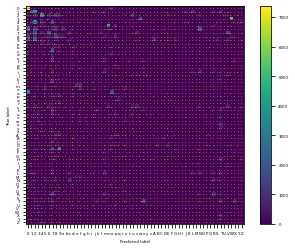

In [74]:

label=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
print(len(label))
cm=ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=label)
plt.figure(dpi=300)
cm.plot()
plt.savefig("confusion_matrix.png",dpi=300)

In [65]:
test_arr=['1','2','3','4','5','6','7','8','9']
print(test_arr[:1])
print(test_arr[1:])

['1']
['2', '3', '4', '5', '6', '7', '8', '9']


In [66]:
np.savetxt('./common_file/y_pred_classes.csv',y_pred_classes,fmt='%d',delimiter=',')